# bertrand2025/figure2
Plot figure 2 from Bertrand et al. 2025, "Increasing wintertime cloud opacity increases surface longwave radiation at a long-term  Arctic observatory".

In [2]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr

from scipy import stats
from scipy import interpolate
import statsmodels.formula.api as smf
import statsmodels.api as sm

from load_preproc_nb40 import load_arm_temp, load_abo_temp, nanmean, load_minutely_flux_hists
from prep_basecase_nb44 import *
from analyze_by_basecase_nb48 import *

from IPython.display import display, Math

# 1. temp-time trends and distributions

Pared-down figure showing both distributions (LWN only) and trends/temperature sensitivities (LWD, LWU, LWN)

In [3]:
declim = lambda ds: ds.groupby('time.month') - ds.groupby('time.month').mean()
# #fluxes
# lwx = xr.open_dataset('22-LWfluxandhist_monthly_from_hourly_mergedstreams.nc')
# lwx.flux.attrs['units'] = 'W/m$^2$'
# lwx = lwx.flux.sel(datastream='nsaqcrad1longC1.c2c1')
# lwd, lwu, lwn = lwx.sel(term='LWdn'), lwx.sel(term='LWup'), lwx.sel(term='LWnet')
# lwd.name, lwu.name, lwn.name = 'lwd','lwu','lwn'

# #features
# ds_xi_monthly = xr.open_dataset('../arm/39-monthly_features_merged.nc')
# ds_xi_monthly = ds_xi_monthly.assign({da.name:da for da in [lwd,lwu,lwn]})
# #put back (for later use)
# ds_xi_monthly = ds_xi_monthly.assign({'lwu':lwu,'lwd':lwd,'lwn':lwn})

# #add "decade" coordinate for convenient regression
# decade = ds_xi_monthly['time'].astype(int) - ds_xi_monthly['time'].astype(int).isel(time=0)
# decade = decade/(1e9*60*60*24*365.25*10) #nanoseconds to decades
# decade.attrs = {'units':'dec'}
# ds_xi_monthly = ds_xi_monthly.assign(decade=decade)

# #anomalies
# ds_anom = declim(ds_xi_monthly)
# ds_anom = ds_anom.assign(decade=decade)
#subset to DJFM
keep_months = [12,1,2,3]
#ds_anom = ds_anom.sel(time=ds_anom['time.month'].isin(keep_months))

# for name in ds_anom:
#     ds_anom[name].attrs = ds_xi_monthly[name].attrs
# data_vars = {name:da for name,da in ds_anom.items()}

In [4]:
#ds_allmos = declim(ds_xi_monthly)
#ds_allmos = ds_allmos.assign(decade=decade)
ds_submos = xr.open_dataset('monthly_mean_metcldrad_features.nc')

### 1.1.2 monthly flux histograms

In [5]:
%%time
#load high-frequency temperature data
#arm_t2m = load_arm_temp(folder=Path('~/Documents/arm_data/ipynb_processed').expanduser())
#gml_t2m = load_abo_temp()
#resample to monthly resolution
#gml_t2m = gml_t2m.resample(time='MS').map(nanmean, ifreq='H')
#arm_t2m = arm_t2m.resample(time='MS').map(nanmean, ifreq='T')
arm_t2m = xr.open_dataset('ARM_NSA_C1_surface_air_temperature.nc')
gml_t2m = xr.open_dataset('NOAA_GML_BRW_ABO_surface_air_temperature.nc')

CPU times: user 7.68 ms, sys: 2.07 ms, total: 9.75 ms
Wall time: 8.56 ms


In [6]:
#gml_t2m.to_netcdf('NOAA_GML_BRW_ABO_surface_air_temperature.nc')
#arm_t2m.to_netcdf('ARM_NSA_C1_surface_air_temperature.nc')

In [7]:
#compute all 4 regressions, saving results
def do_regression(predictand,predictor,data_submos):
    '''Ordinary least-squares regression'''
    # do DJFM-only OLS regression
    ds = data_submos
    Y, X = xr.align(ds[predictand].dropna('time'),ds[predictor].dropna('time'))
    Y, X = Y.data, X.data
    X = sm.add_constant(X)
    olsr_djfm_res = sm.OLS(Y,X, missing='drop').fit()
    return olsr_djfm_res

In [8]:
# ds_hists.attrs = {
#     'description': 'Utqiagvik surface longwave flux histograms from multiple sources',
#     'author': 'Leah Bertrand',
#     'citation': 'Bertrand, Kay, de Boer. Increasing wintertime cloud opacity increases surface longwave radiation at a long-term  Arctic observatory'
# }
# ds_submos.attrs = {
#     'description': 'Utqiagvik monthly-mean clouds, meteorology, and radiation',
#     'author': 'Leah Bertrand',
#     'citation': 'Bertrand, Kay, de Boer. Increasing wintertime cloud opacity increases surface longwave radiation at a long-term  Arctic observatory'
# }
# ds_hists.to_netcdf('surface_longwave_flux_histograms.nc')
# ds_submos.to_netcdf('monthly_mean_metcldrad_features.nc')

In [9]:
#ds_hists = load_minutely_flux_hists()
ds_hists = xr.open_dataset('surface_longwave_flux_histograms.nc')

In [10]:
#absolute temperatures
t2m_mons = { }

#add in GML and ARM met data
t2m_mons['NOAA BRW GML'] = gml_t2m
t2m_mons['ARM NSA C1'] = arm_t2m

#monthly temperature anomalies (remove seasonal cycle)
t2m_mon_anoms = { }
for label,t2m_mon in t2m_mons.items():
    t2m_mon_anom = t2m_mon.groupby('time.month') - t2m_mon.groupby('time.month').mean()
    t2m_mon_anoms[label] = t2m_mon_anom

## 1.2 analysis

In [11]:
def get_tmask(bounds,dax_std):
    '''get temporal mask indicating months with a temperature anomaly in a range'''
    thresh_inner, thresh_outer = bounds
    thresh = 0.5*(thresh_inner+thresh_outer)
    #get subset mask
    if thresh < 0: #left tail for neg
        tmask = (thresh_outer<=dax_std) & (dax_std<=thresh_inner)
    elif thresh > 0: #right tail for pos
        tmask = (thresh_outer>=dax_std) & (dax_std>=thresh_inner)
    elif thresh == 0: #all points for zero 
        tmask = xr.ones_like(dax_std,dtype=bool)
    return tmask

## 1.3 plot

In [18]:
decade = ds_submos['decade']

In [19]:
def decade_to_datetime(decade,t0):
    dt = pd.to_timedelta(decade*(1e9*60*60*24*365.25*10),unit='ns') #decades to nanoseconds
    return dt+pd.to_datetime(t0)

In [20]:
def my_precision(x, n):
    '''30897226'''
    return '{:.{}f}'.format(x, n)

In [21]:
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))

In [ ]:
ax.plot(bin_mids,icounts/icounts.sum(),zorder=-100,
                label=label,
                linestyle=linestyles[name],
                color=colors[name],**extra_kws)

In [19]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrow
import pandas as pd
import xarray as xr

from scipy import stats
from scipy import interpolate
import statsmodels.formula.api as smf
import statsmodels.api as sm

from load_preproc_nb40 import load_arm_temp, load_abo_temp, nanmean, load_minutely_flux_hists
from prep_basecase_nb44 import *
from analyze_by_basecase_nb48 import *

# 2. base cases

## 2.1 load data

In [20]:
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))

In [21]:
def get_config(which):
    if which == 'mixed':
        #segs_by_kind = {'liq':liq_segs_masked,'ice':ice_segs_masked}
        varnames_by_axis = [ 
            ['theta','rh'], 
            ['iwc','lwc'], 
            ['reice','reliq'] ]
        bounds_by_axis = [
            ['liq','liq'],
            ['ice','liq'],
            ['ice','liq'] ]
        ymax = 5e3 #3
    elif which == 'ice':
        #segs_by_kind = {'ice':this_segs_masked}
        varnames_by_axis = [ 
            ['theta','rh'], 
            ['iwc','_'], 
            ['reice','_'] ]
        bounds_by_axis = [
            ['ice','ice'],
            ['ice','_'],
            ['ice','_'] ]
        ymax = 5e3
    elif which == 'liquid':
        #segs_by_kind = {'liq':this_segs_masked}
        varnames_by_axis = [ 
            ['theta','rh'], 
            ['_','lwc'], 
            ['_','reliq'] ]
        bounds_by_axis = [
            ['liq','liq'],
            ['_','liq'],
            ['_','liq'] ]
        ymax = 5e3 #1.5
    #return segs_by_kind, varnames_by_axis, bounds_by_axis, ymax
    return varnames_by_axis, bounds_by_axis, ymax

## 2.2 plot

In [22]:
reduce_proc = lambda da: da.median(dim='time') #.mean(dim='time')

In [23]:
def post_norm(profile,wp,heights):
    '''scale water content profile to water path'''
    profile = profile-profile.min() #minimum value of 0
    profile = profile.rename(zk='height').assign_coords(height=heights) #change to physical height
    norm    = profile.fillna(0).integrate('height') #find normalization constant
    return wp/norm*profile

In [ ]:
# load weights f
da_weights_djfm = xr.open_dataset('cloud_phase_monthly_frequency.nc')
da_weights_djfm = da_weights_djfm['weights']
da_weights_avg  = da_weights_djfm.mean('time')

In [24]:
# # load weights f
# da_weights_djfm = get_weights(get_is_phase())
# da_weights_avg  = da_weights_djfm.mean('time')

dropping category "other" because it contains no observations


probably I should drop the AERI period when calculating $df_i/dT$

In [25]:
# load base case specification datasets
spec_met = xr.open_dataset('../arm/46-1-base_cases_met.nc')
spec_cld = xr.open_dataset('../arm/46-1-base_cases_cld.nc')
spec = xr.merge([spec_met,spec_cld])
cloudy = xr.DataArray(data=[True,True,True,False],dims=['type'],
                      coords={'type':np.array(['liquid', 'mixed', 'ice','clear'])})
spec = spec.assign(is_cloudy=cloudy)

In [26]:
def get_rel_norms(spec,which):
    '''return window-averaged relative profiles and column-integrated microphysics

    Parameters:
    --------------
    spec            dataset specifying base case profiles for a set of types

    Returns:
    -------------
    rel_norms       dataset of layer-integrated or layer-averaged bulk microphysics
    '''
    data_vars = [ ]
    spec_i = spec.sel(type=which)
    if spec_i.height.attrs['units'] == 'km':
        spec_i = spec_i.copy()
        spec_i['height'] = spec_i['height']*1e3
    #calculate microphysics
    if which != 'ice':
        #relative LWP
        LWP     = spec_i.lwc.fillna(0).integrate('height') 
        #relative liquid effective radius
        reliq_avg   = spec_i.reliq.where(lambda da: da>0).mean('height') #um
        #save
        data_vars.append(LWP)
        data_vars.append(reliq_avg)
    if which != 'liquid':
        #relative IWP
        IWP     = spec_i.iwc.fillna(0).integrate('height') 
        #relative ice effective radius
        reice_avg   = spec_i.reice.where(lambda da: da>0).mean('height') #um
        #save
        data_vars.append(IWP)
        data_vars.append(reice_avg)
    return xr.merge(data_vars)

In [27]:
def get_cloud_bounds(spec,which):
    '''infer layer bounds from micro profiles. Only accurate to dz/2 of spec.'''
    usage_var = {'ice':['iwc'],'liquid':['lwc'],'mixed':['iwc','lwc']}
    kind_map  = {'iwc':'ice','lwc':'liq'}
    dz        = spec.height.diff('height').mean()
    bounds    = { }
    for cldvar in usage_var[which]:
        da = spec.sel(type=which)[cldvar]
        hts = da.height.sel(height=da.notnull())
        btm = hts.min()-dz/2
        top = hts.max()+dz/2
        bounds[kind_map[cldvar]] = [btm.item(),top.item()]
    return bounds

In [28]:
def get_config(which):
    if which == 'mixed':
        #segs_by_kind = {'liq':liq_segs_masked,'ice':ice_segs_masked}
        varnames_by_axis = [ 
            ['theta','rh'] ]
        bounds_by_axis = [
            ['liq','liq'] ]
        ymax = 5 #3
    elif which == 'ice':
        #segs_by_kind = {'ice':this_segs_masked}
        varnames_by_axis = [ 
            ['theta','rh'] ]
        bounds_by_axis = [
            ['ice','ice'] ]
        ymax = 5
    elif which == 'liquid':
        #segs_by_kind = {'liq':this_segs_masked}
        varnames_by_axis = [ 
            ['theta','rh'] ]
        bounds_by_axis = [
            ['liq','liq'] ]
        ymax = 5 #1.5
    #return segs_by_kind, varnames_by_axis, bounds_by_axis, ymax
    return varnames_by_axis, bounds_by_axis, ymax

In [29]:
rel_norm_shortnames = {
    'iwc': 'IWP',
    'lwc': 'LWP',
    'reliq': r'$\overline{r_{e,liq}}$',
    'reice': r'$\overline{r_{e,ice}}$'
}

rel_norm_units = {
    'iwc': 'g/m$^2$',
    'lwc': 'g/m$^2$',
    'reliq': '$\mathrm{\mu}$m',
    'reice': '$\mathrm{\mu}$m'
}

units = {'theta': 'K',
         'rh': '%',
         'iwc': 'g/m$^3$',
         'lwc': 'g/m$^3$',
         'reliq': '$\mathrm{\mu}$m',
         'reice': '$\mathrm{\mu}$m'}

long_names = {'theta': 'Potential temperature',
              'rh': 'Relative humidity',
              'iwc': 'Ice water content',
              'lwc': 'Liquid water content',
              'reliq': 'Liquid effective radius',
              'reice': 'Ice effective radius'}

long_type_names = {'mixed': 'Mixed-phase','ice':'Ice-only',
                   'liquid':'Liquid-only','clear':'Clear-sky'}

cloud_props = ['iwc','lwc','reice','reliq']

host_color, par_color = 'b', 'k'

# 3. all-time attribution results

## 3.1 downwelling longwave by driver
Issue: somehow $dF_D/dT$ from this portion of the analysis is greater than $dF_D/dT$ from the initial part by a fair bit. Like 4.3-6.3 W/m$^2$ here vs. 3.9-4.7 W/m$^2$ earlier. Fixed -- culprit was mean vs median stuff or something like that.

### 3.1.0 load and analyze data

In [30]:
def group_by_type(ds,masks):
        '''aggregate dataset to monthly means according to times in masks'''
        ds_by_type = [ ]
        for name,mask in masks.items():
            ds_sub = ds.sel(time=mask)
            ds_sub = ds_sub.resample(time='MS').mean()
            ds_sub = ds_sub.assign_coords(type=name)
            ds_sub.attrs = ds.attrs
            ds_by_type.append(ds_sub)
        ds_by_type = xr.concat(ds_by_type,dim='type')
        return ds_by_type

def get_split_iwp(thresh=70,add_type_dim=True): #g/m2
    '''recalculate monthly-mean ice water path<thresh g/m2 and ice water path>thresh g/m2 by base case'''
    #load cloud props
    folder = Path('~/Documents/arm_data').expanduser()
    fps = sorted(Path(folder/'ipynb_processed'/'28-microshupeturn-columnint-minutely-by-year').glob('*.nc'))
    ds = xr.open_mfdataset(fps)
    iwp   = ds.iwp.compute()
    phase = ds.phase.compute()
    is_phase = bit_packed_to_broad_categories(phase.astype(int))
    #align+restrict to DJFM
    iwp = iwp.where(iwp['time.month'].isin([12,1,2,3]),drop=True)
    is_phase = sub_mos(is_phase)
    #restrict LWP/IWP be consistent with phase mask
    iwp_masked  = iwp.where(is_phase.ice | is_phase.mixed)
    #split into thresholds
    iwphi_masked = iwp_masked.where(lambda da: da>=thresh)
    iwp_masked = iwp_masked.where(lambda da: da<thresh)
    if add_type_dim:
        #minutely to monthly by base case
        iwp_masked   = group_by_type(iwp_masked,is_phase)
        iwphi_masked = group_by_type(iwphi_masked,is_phase)
    return {'iwp':iwp_masked,'iwphi':iwphi_masked}

def get_split_lwp(thresh=50,add_type_dim=True): #g/m2
    '''recalculate monthly-mean liquid water path<thresh g/m2 and ice water path>thresh g/m2 by base case'''
    #load cloud props
    folder = Path('~/Documents/arm_data').expanduser()
    fps = sorted(Path(folder/'ipynb_processed'/'28-microshupeturn-columnint-minutely-by-year').glob('*.nc'))
    ds = xr.open_mfdataset(fps)
    lwp   = ds.lwp.compute()
    phase = ds.phase.compute()
    is_phase = bit_packed_to_broad_categories(phase.astype(int))
    #align+restrict to DJFM
    lwp = lwp.where(lwp['time.month'].isin([12,1,2,3]),drop=True)
    is_phase = sub_mos(is_phase)
    #restrict LWP/IWP be consistent with phase mask
    lwp_masked  = lwp.where(is_phase.liquid | is_phase.mixed)
    #split into thresholds
    lwphi_masked = lwp_masked.where(lambda da: da>=thresh)
    lwp_masked = lwp_masked.where(lambda da: da<thresh)
    if add_type_dim:
        #minutely to monthly by base case
        lwp_masked   = group_by_type(lwp_masked,is_phase)
        lwphi_masked = group_by_type(lwphi_masked,is_phase)
    return {'lwp':lwp_masked,'lwphi':lwphi_masked}

In [31]:
def nosum_extensive(dfj_dt,fj,yj):
    '''
    total change in linear combination response variable due to changing weights
    if y = sum_j f_j*y_j, the change in y implied by changing f_j
    
    dfj_dt: slopes of response frequency 'f' to predictor 't' by case 'j'
    fj:     frequencies by cases by case 'j'
    yj:     values of response 'y' by case 'j' 
    '''
    y        = (yj*fj).sum('type')         #value of y (weighted average of yj)
    dy_dfj   = yj - (y-fj*yj)/(1-fj)       #change in y due to change in fj
    dydt_ext = (dy_dfj*dfj_dt)             #change in y due to t via changing fj
    return dydt_ext

In [32]:
def product_uncertainty(out_mean,ins_mean,ins_err):
    '''uncertainty propagation for products/quotients'''
    terms   = [(x_err/x_mean)**2 for x_mean,x_err in zip(ins_mean,ins_err)]
    rel_err = np.sqrt(sum(terms))
    return out_mean*rel_err

#product_uncertainty(dFdf_med*dfdt_med,[dFdf_med,dfdt_med],[dFdf_err,dfdt_err])
#attrib_ext_err = ([dFdf_med*dfdt_med])**2).sum('type')

In [33]:
def symmetrize_error(ds,dim='case',alpha=0.05):
    med = ds.median(dim)
    dlo = np.abs(med-ds.quantile(alpha,dim=dim))
    dhi = np.abs(ds.quantile(1-alpha,dim=dim)-med)
    err = xr.where(dlo<dhi,dlo,dhi)
    return err

In [34]:
%%time
# load x and F
ds_feat_typed = get_ds_feat_typed(file='47-monthly_features_by_base_case_mean.nc')
# recalculate new IWP
IWP_THRESH, LWP_THRESH = 130, 70 #g/m2, derived in arm2/63-
ds_feat_typed = ds_feat_typed.assign(get_split_iwp(thresh=IWP_THRESH))
ds_feat_typed = ds_feat_typed.assign(get_split_lwp(thresh=LWP_THRESH))
# subtract climatology
ds_typed_anom = get_ds_typed_anom(ds_feat_typed)
# add planck, equal to surface air temp by construction
ds_typed_anom = ds_typed_anom.assign(planck=ds_typed_anom['temp'])
#overwrite upper air temperature scaling (since lapse rate is pegged to T2m now)
ds_typed_anom['column_air_temperature'].data = ds_typed_anom['temp'].data

# estimate dx/dT and dF/dT
dxdt_med = aggregate(ds_typed_anom,'slope')
dxdt_lo  = aggregate(ds_typed_anom,'low_slope')
dxdt_hi  = aggregate(ds_typed_anom,'high_slope')
dxdt_err = 0.5*(dxdt_hi-dxdt_lo)

# load dF/dx
dFdx_full = get_processed_perturbations('18-perturbation_sensitivities_v4.2.1.nc')
# find average sensitivity and error
dFdx     = dFdx_full.mean('case')
dFdx_lo  = dFdx_full.quantile(0.05,['case'])
dFdx_hi  = dFdx_full.quantile(0.95,['case'])
dFdx_err = 0.5*(dFdx_hi-dFdx_lo) #unused
#convert to dataset
dFdx     = dFdx.to_dataset('feature')
dFdx_err = dFdx_err.to_dataset('feature')

# load weights f
is_phase        = get_is_phase()
da_weights_djfm = get_weights(is_phase)
da_weights_avg  = da_weights_djfm.mean('time')

# calculate relative cloudy weights r
da_rel_weights_djfm = da_weights_djfm/da_weights_djfm.sel(type='clear').drop('type')

# estimate df/dT
temp_anom = ds_typed_anom['temp'].where(lambda da: da.type!='all',drop=True)
dfdt_med  = find_weight_response_to_temp(da_weights_djfm,temp_anom,'slope')
dfdt_lo   = find_weight_response_to_temp(da_weights_djfm,temp_anom,'low_slope')
dfdt_hi   = find_weight_response_to_temp(da_weights_djfm,temp_anom,'high_slope')
dfdt_err  = 0.5*(dfdt_hi-dfdt_lo)

# estimate dr/dT
temp_anom = ds_typed_anom['temp'].where(lambda da: da.type!='all',drop=True)
drdt_med  = find_weight_response_to_temp(da_rel_weights_djfm,temp_anom,'slope')
drdt_lo   = find_weight_response_to_temp(da_rel_weights_djfm,temp_anom,'low_slope')
drdt_hi   = find_weight_response_to_temp(da_rel_weights_djfm,temp_anom,'high_slope')
drdt_err  = 0.5*(drdt_hi-drdt_lo)
drdt_med  = drdt_med.sel(type=['liquid','mixed','ice'])
drdt_err  = drdt_err.sel(type=['liquid','mixed','ice'])

# load F change for weight f change (dF/df)
dFdf_ensemble = xr.open_dataset('58-cloudtype_frequency_effect_on_radiation.nc')
dFdf_ensemble = dFdf_ensemble['__xarray_dataarray_variable__']
dFdf_med = (dFdf_ensemble/dFdf_ensemble.level).mean(['level','trial'])
dFdf_lo  = (dFdf_ensemble/dFdf_ensemble.level).quantile(0.05,['level','trial'])
dFdf_hi  = (dFdf_ensemble/dFdf_ensemble.level).quantile(0.95,['level','trial'])
dFdf_err = 0.5*(dFdf_hi-dFdf_lo)

# load F change for weight r change (dF/dr)
dFdr_ensemble = xr.open_dataset('58-cloudtype_frequency_effects_on_cloudy_radiation.nc')
dFdr_ensemble = dFdr_ensemble['__xarray_dataarray_variable__']
dFdr_med = (dFdr_ensemble/dFdr_ensemble.level).mean(['level','trial'])
dFdr_lo  = (dFdr_ensemble/dFdr_ensemble.level).quantile(0.05,['level','trial'])
dFdr_hi  = (dFdr_ensemble/dFdr_ensemble.level).quantile(0.95,['level','trial'])
dFdr_err = 0.5*(dFdr_hi-dFdr_lo)

# subset to only cloud types (no 'all' or anything like that)
# NOTE: is this still necessary?
case_types     = ['liquid','clear','mixed','ice']
subset_types   = lambda ds: ds.sel(type=ds.type.isin(case_types))
dxdt_med_thin  = subset_types(dxdt_med)
dxdt_err_thin  = subset_types(dxdt_err)
x_avg_thin     = subset_types(ds_feat_typed.mean('time'))
# get the list of drivers in proper order
common_vars   = set(dFdx).intersection(dxdt_med)
order = {'planck':0, 'pwv':1, 'co2':2, 'column_air_temperature':3, 
         'tot_cld':4, 'lwp':5, 'iwp':6, 'cbh':7}
common_vars = sorted(common_vars,key=lambda k: order[k])
# subset to only drivers
dxdt_med_thin = dxdt_med[common_vars]
dxdt_err_thin = dxdt_err[common_vars]
dFdx_thin     = dFdx[common_vars]
dFdx_err      = dFdx_err[common_vars]

# find dF/dT due to x_i (ignore error in dF/dx)
attributed_med = dFdx_thin*dxdt_med_thin
attributed_err = product_uncertainty(dFdx_thin*dxdt_med,[dFdx_thin,dxdt_med],[dFdx_err,dxdt_err])
yerr_under     = attributed_err
yerr_over      = attributed_err

# add separately calculated dF/dT due to LWP, IWP
attributed_med_wp, attributed_err_wp = calculate_lwp_iwp_driving(ds_typed_anom, use_dask=True)
attributed_med = attributed_med.assign(attributed_med_wp)
attributed_err = attributed_err.assign(attributed_err_wp)

# find dF/dT due to f_j
attrib_ext_med_by_case = dFdf_med*dfdt_med
attrib_ext_err_by_case = product_uncertainty(dFdf_med*dfdt_med,[dFdf_med,dfdt_med],[dFdf_err,dfdt_err])

# find dF/dT due to r_j
f_clr = da_weights_avg.sel(type='clear')
attrib_rel_med_by_case = (1-f_clr)*dFdr_med*drdt_med
attrib_rel_err_by_case = (1-f_clr)*product_uncertainty(attrib_rel_med_by_case, [dFdr_med, drdt_med], [dFdr_err, drdt_err])

# mask out spurious types for cloud phase (ice alone) and cloud cover (clear alone)
#    separate out cloud phase
attrib_phase_med_by_case = attrib_rel_med_by_case#.where(lambda da: da.type == 'ice', other=0)
attrib_phase_err_by_case = attrib_rel_err_by_case#.where(lambda da: da.type == 'ice', other=0)
#    separate out cloud cover
attrib_cover_med_by_case = attrib_ext_med_by_case.where(lambda da: da.type == 'clear', other=0)
attrib_cover_err_by_case = attrib_ext_err_by_case.where(lambda da: da.type == 'clear', other=0)

# merge liquid and ice water path into cloud opacity
add_twp = lambda ds: ds.assign({'twp':ds['iwp'].fillna(0)+ds['lwp'].fillna(0)}).drop(['iwp','lwp'])
add_twp_quad = lambda ds: ds.assign({'twp':np.sqrt(ds['iwp'].fillna(0)**2+ds['lwp'].fillna(0)**2)}).drop(['iwp','lwp'])
attribted_med_split_twp = attributed_med.copy()
attribted_err_split_twp = attributed_err.copy()
attributed_med = add_twp(attributed_med)
attributed_err = add_twp_quad(attributed_err)

#aggregate to all-sky
attrib_tot_med = (attributed_med*da_weights_avg).sum('type')
attrib_tot_err = np.sqrt(((attributed_err*da_weights_avg)**2).sum('type'))
attrib_cover_med = attrib_cover_med_by_case.sum('type') #dF/df*df/dT
attrib_cover_err = np.sqrt(attrib_cover_err_by_case**2).sum('type')
attrib_phase_med = attrib_phase_med_by_case.sum('type') #dF/df*df/dT
attrib_phase_err = np.sqrt(attrib_phase_err_by_case**2).sum('type')

#add cloud cover change effect (merge dF/dT|x_i and dF/dT|f_j)
attributed_med = attributed_med.assign(tot_cld=attrib_cover_med_by_case)
attributed_err = attributed_err.assign(tot_cld=attrib_cover_err_by_case)
attrib_tot_med = attrib_tot_med.assign(tot_cld=attrib_cover_med)
attrib_tot_err = attrib_tot_err.assign(tot_cld=attrib_cover_err)

#add cloud phase change effect (merge dF/dT|x_i and dF/dT|f_j)
attributed_med = attributed_med.assign(liq_cld=attrib_phase_med_by_case)
attributed_err = attributed_err.assign(liq_cld=attrib_phase_err_by_case)
attrib_tot_med = attrib_tot_med.assign(liq_cld=attrib_phase_med)
attrib_tot_err = attrib_tot_err.assign(liq_cld=attrib_phase_err)

#plotting order -- put tot_cld in the right place
order = ['planck','pwv','co2','column_air_temperature','twp','liq_cld','tot_cld','cbh']
attributed_med = attributed_med[order]
attributed_err = attributed_err[order]
attrib_tot_med = attrib_tot_med[order]
attrib_tot_err = attrib_tot_err[order]

#switch from vars being features to vars being coordinates
attributed_med_by_case = transpose(attributed_med)
attributed_err_by_case = transpose(attributed_err)
#set plotting order
order = ['clear','ice','mixed','liquid']
attributed_med_by_case = attributed_med_by_case[order]
attributed_err_by_case = attributed_err_by_case[order]

# Addendum: save full information about F and xi response to T
# get extensive (simple, no bootstrapping), intensive, and attributed total (int+ext)
dxdt_ext_med = weightsum_extensive(dfdt_med,da_weights_avg,x_avg_thin)
dxdt_ext_err = weightsum_extensive_err(dfdt_med,da_weights_avg,x_avg_thin,dfdt_err)
dxdt_int_med = weightsum_intensive(dxdt_med_thin,da_weights_avg)
dxdt_int_err = weightsum_intensive_err(dxdt_med_thin,da_weights_avg,dxdt_err_thin)
dxdt_tot_med = dxdt_int_med + dxdt_ext_med
dxdt_tot_err = np.sqrt(dxdt_int_err**2 + dxdt_ext_err**2)
# incorporate totals back into slopes by type
dxdt_med = add_all_sums_to_type(dxdt_med,dxdt_int_med,dxdt_ext_med,dxdt_tot_med)
dxdt_err = add_all_sums_to_type(dxdt_err,dxdt_int_err,dxdt_ext_err,dxdt_tot_err)

lwp empty, let slope = 0
lwp empty, let slope = 0
lwp empty, let slope = 0
iwp empty, let slope = 0
iwp empty, let slope = 0
iwp empty, let slope = 0
cbh empty, let slope = 0
iwphi empty, let slope = 0
iwphi empty, let slope = 0
iwphi empty, let slope = 0
lwphi empty, let slope = 0
lwphi empty, let slope = 0
lwphi empty, let slope = 0
lwp empty, let slope = 0
lwp empty, let slope = 0
lwp empty, let slope = 0
iwp empty, let slope = 0
iwp empty, let slope = 0
iwp empty, let slope = 0
cbh empty, let slope = 0
iwphi empty, let slope = 0
iwphi empty, let slope = 0
iwphi empty, let slope = 0
lwphi empty, let slope = 0
lwphi empty, let slope = 0
lwphi empty, let slope = 0
lwp empty, let slope = 0
lwp empty, let slope = 0
lwp empty, let slope = 0
iwp empty, let slope = 0
iwp empty, let slope = 0
iwp empty, let slope = 0
cbh empty, let slope = 0
iwphi empty, let slope = 0
iwphi empty, let slope = 0
iwphi empty, let slope = 0
lwphi empty, let slope = 0
lwphi empty, let slope = 0
lwphi empty, let

/Users/leah/miniforge3/envs/sci/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


dropping category "other" because it contains no observations
dropping category "other" because it contains no observations


/Users/leah/miniforge3/envs/sci/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/leah/miniforge3/envs/sci/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


0.013051310137804695 empty, let slope = 0
0.02101602912482803 empty, let slope = 0
0.03384131366982533 empty, let slope = 0
0.05449338236529867 empty, let slope = 0
0.0877486243761994 empty, let slope = 0
0.14129827780370213 empty, let slope = 0
0.22752725130705825 empty, let slope = 0
0.36637849301507097 empty, let slope = 0
0.5899653750171696 empty, let slope = 0
0.9499988409658977 empty, let slope = 0
1.529747059834289 empty, let slope = 0
2.4632936022241476 empty, let slope = 0
3.9665481503953464 empty, let slope = 0
6.3871818670737035 empty, let slope = 0
10.285036423674567 empty, let slope = 0
16.56160360512432 empty, let slope = 0
26.66852140084805 empty, let slope = 0
42.943307342981875 empty, let slope = 0
69.14997715228256 empty, let slope = 0
111.34958241502721 empty, let slope = 0
179.3020043476857 empty, let slope = 0
288.7232090666447 empty, let slope = 0
464.92002003555626 empty, let slope = 0
748.6430541161274 empty, let slope = 0
1205.5114822404491 empty, let slope = 0

In [35]:
#attributed_err     = 0.5*np.abs(attributed_hi-attributed_lo)
dlwd_dT_ca_liq     = attrib_phase_med
dlwd_dT_ca_liq_err = attrib_phase_err
dlwd_dT_ca_clr     = attrib_cover_med
dlwd_dT_ca_clr_err = attrib_cover_err

display(Math(r'$\partial_T F_D|_{CA}$'+' clear only: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(dlwd_dT_ca_clr.data.item(0),dlwd_dT_ca_clr_err.data.item(0))))
display(Math(r'$\partial_T F_D|_{CA}$'+' liquid-containing: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(dlwd_dT_ca_liq.data.item(0),dlwd_dT_ca_liq_err.data.item(0))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### 3.1.1 plot by sum (simple)

In [36]:
long_names = {
    'tot_cld': 'Cloud cover',
    'liq_cld': 'Cloud phase',
    'lwp': 'Liquid water path',
    'pwv': 'Water vapor',
    'pwv_cc': r'PWV$_\mathrm{CC}$',
    'Temp_Air': 'Air temperature',
    'temp': r'$T_{2m}$',
    'planck': 'Planck',
    'column_air_temperature': r'Lapse rate',
    'cbh': r'Cloud altitude',
    'twp': r'Cloud water path',
    'iwp': 'Ice water path',
    'iwphi': 'Opaque ice water path',
    'cloud_liquid': r'$f_{liq}$',
    'cloud_mixed': r'$f_{mix}$',
    'cloud_ice': r'$f_{ice}$',
    'co2': r'Direct CO$_2$',
    'lwu': r'$F_U$',
    'lwd': r'$F_D$',
    'lwn': r'$F_N$',
    'total':'Total'
}

## 3.3 Base case summary and LWD attribution by base case

In [37]:
if spec['height'].attrs['units'] == 'm':
    spec['height'] = spec['height']/1e3
    spec['height'].attrs['units'] = 'km'

In [38]:
labels = attributed_med_by_case.feature
labels = [long_names[key] for key in labels.data]

In [39]:
da_med = attrib_tot_med.to_array()
da_hi  = attrib_tot_med.to_array()+attrib_tot_err.to_array()
da_lo  = attrib_tot_med.to_array()-attrib_tot_err.to_array()

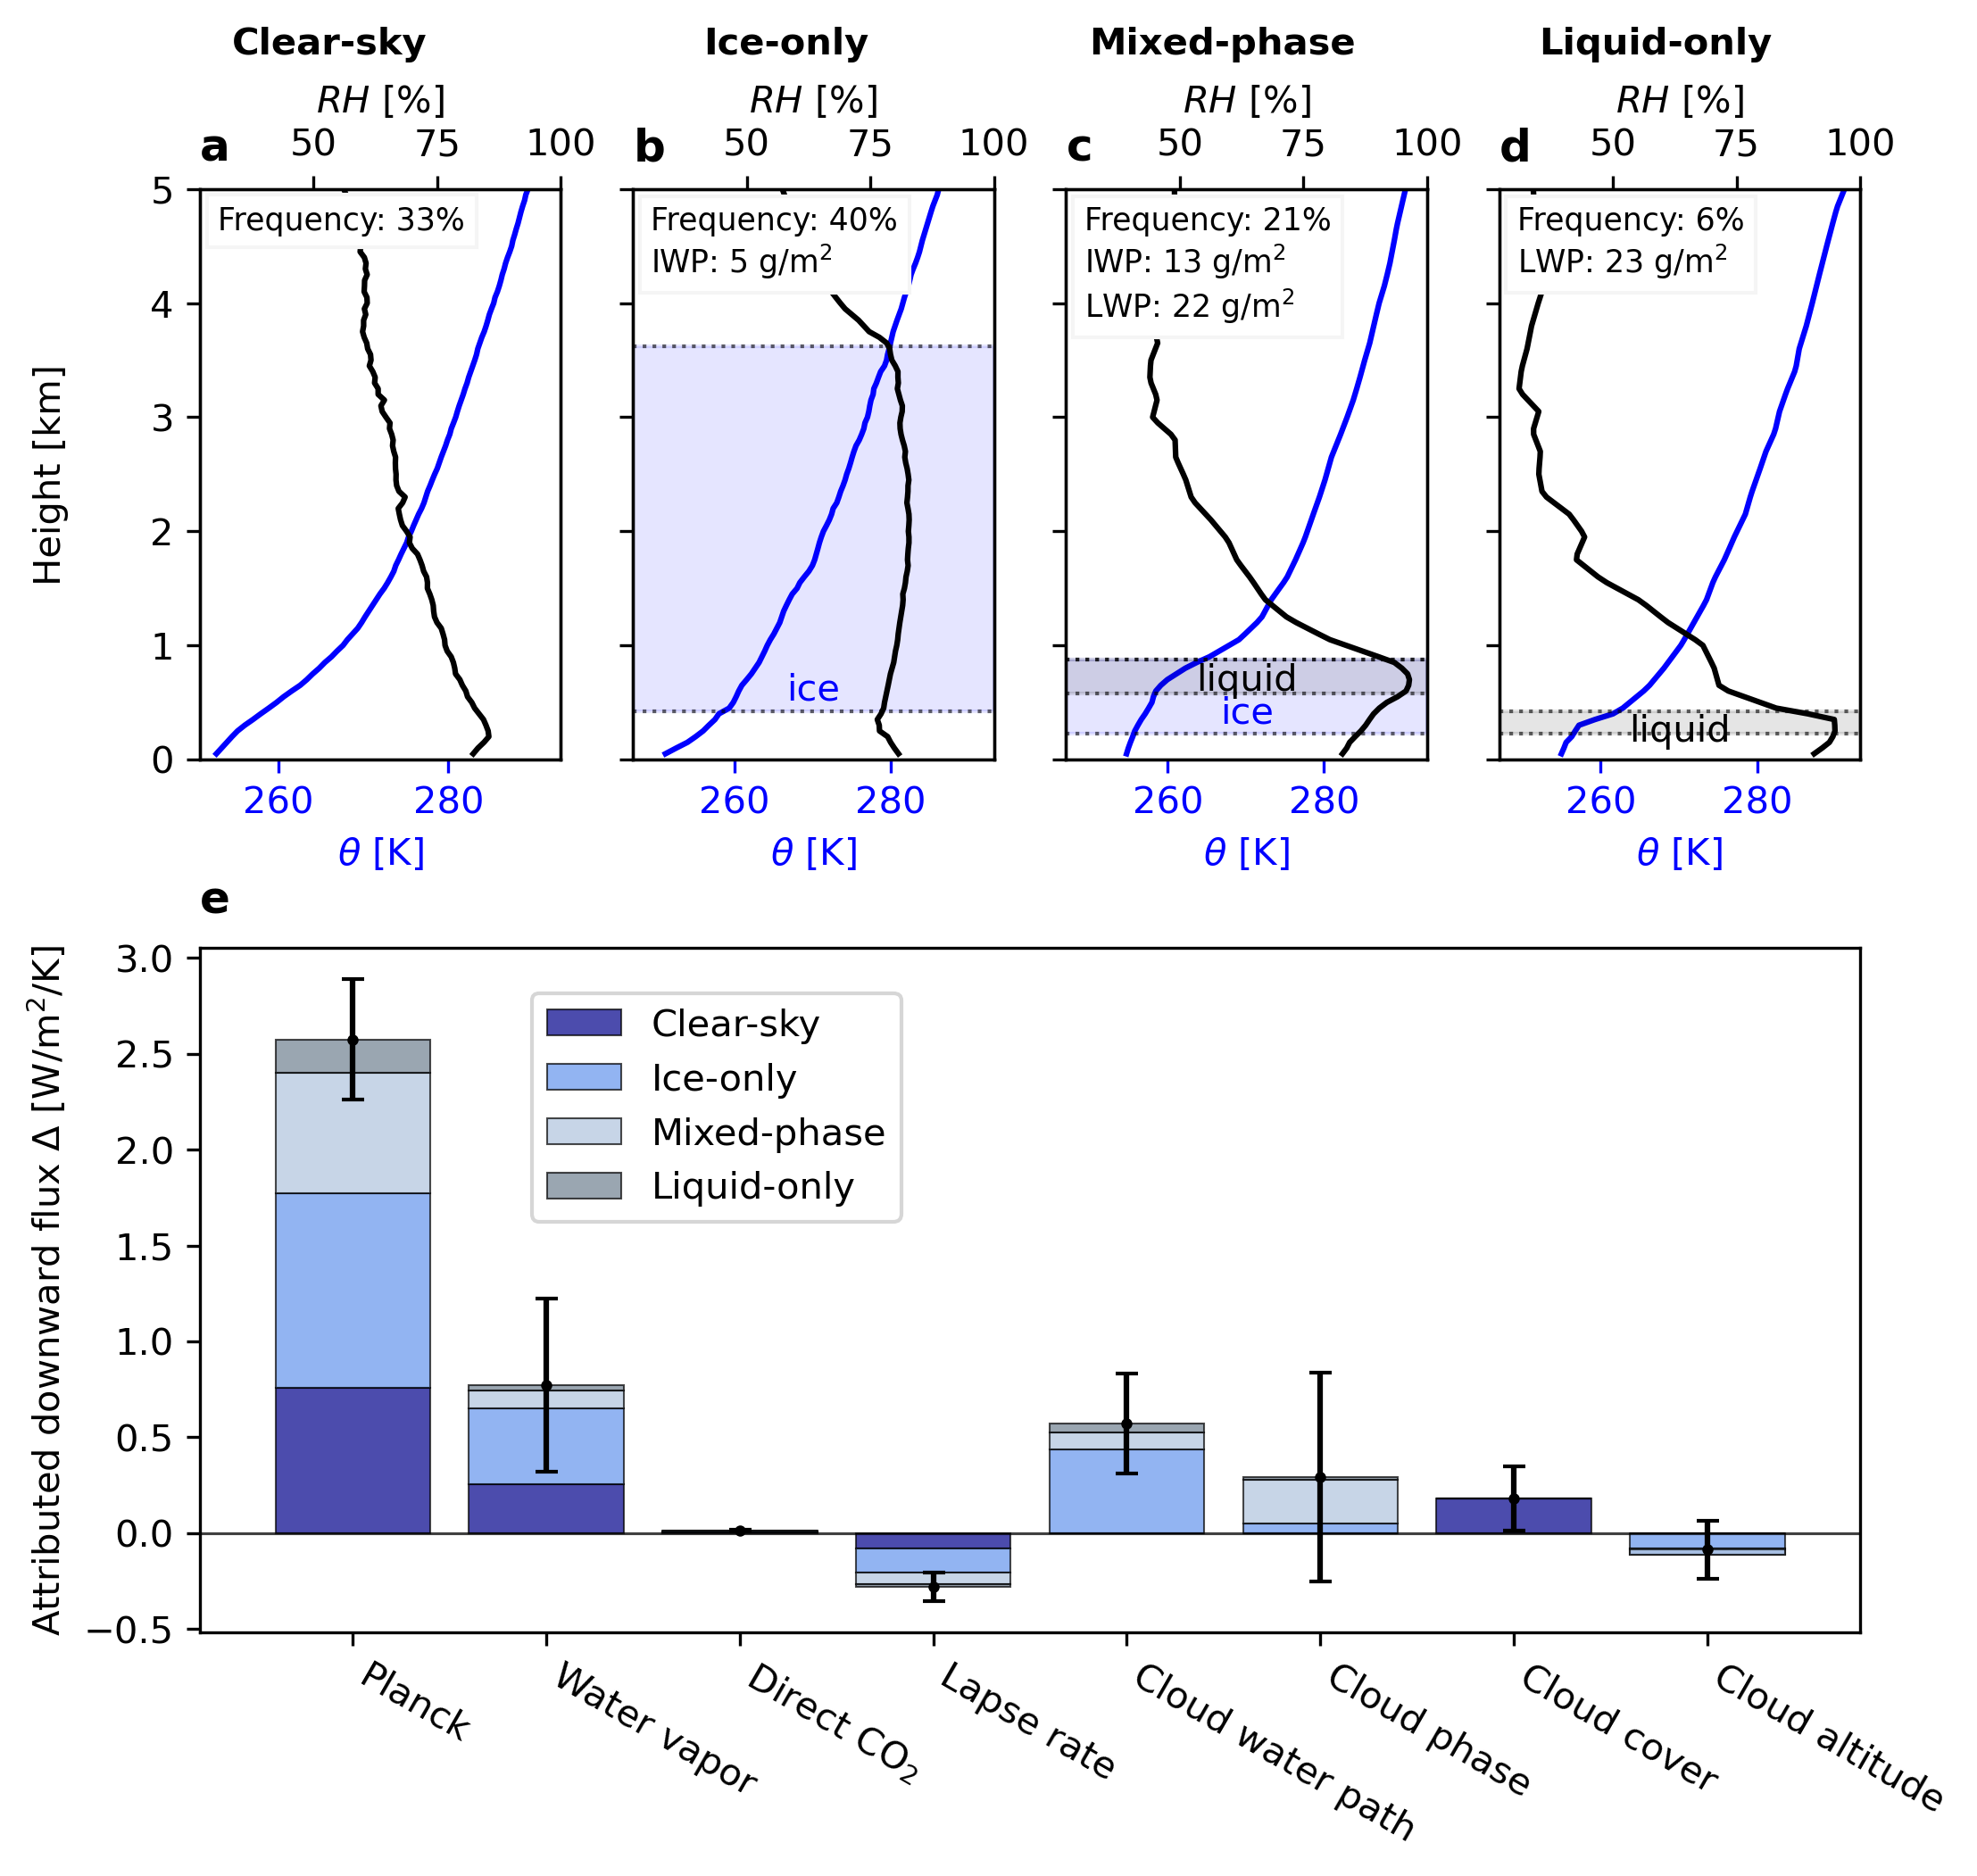

In [40]:
fig,axes = plt.subplots(2,4,dpi=300,figsize=(8,7),sharey='row',height_ratios=[1,1.2])
text_pos = iter([0.14,0.36,0.54,0.75]) #row labels

#turn second row into one long axis
gs = axes[0, 0].get_gridspec()
# remove the underlying Axes
for ax in axes[1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[1, :])

#################################
##### BASE CASE METEOROLOGY #####
#################################

rel_norm_shortnames = {
    'iwc': 'IWP',
    'lwc': 'LWP',
    'reliq': r'$\overline{r_{e,liq}}$',
    'reice': r'$\overline{r_{e,ice}}$'
}

rel_norm_units = {
    'iwc': 'g/m$^2$',
    'lwc': 'g/m$^2$',
    'reliq': '$\mathrm{\mu}$m',
    'reice': '$\mathrm{\mu}$m'
}

units = {'theta': 'K',
         'rh': '%',
         'iwc': 'g/m$^3$',
         'lwc': 'g/m$^3$',
         'reliq': '$\mathrm{\mu}$m',
         'reice': '$\mathrm{\mu}$m'}

long_names = {'theta': r'$\theta$',
              'rh': r'$RH$',
              'iwc': 'Ice water content',
              'lwc': 'Liquid water content',
              'reliq': 'Liquid effective radius',
              'reice': 'Ice effective radius'}

long_type_names = {'mixed': 'Mixed-phase','ice':'Ice-only','liquid':'Liquid-only','clear':'Clear-sky'}

cloud_props = ['iwc','lwc','reice','reliq']

host_color, par_color = 'b', 'k'

### CLEAR-SKY MET ###
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))

clear = spec.sel(type='clear')
ymax=5
ax = axes[0,0]
par = ax.twiny()
for color,xaxis,data_var in zip([host_color,par_color],[ax,par],['theta','rh']):
    #get average profile
    #plot
    p, = xaxis.plot(clear[data_var].where(clear.height.data<=ymax*1.1),clear.height,c=color)
    xaxis.set_xlabel(f'{long_names[data_var]} [{units[data_var]}]')
    xaxis.xaxis.label.set_color(p.get_color())
    xaxis.tick_params(axis='x', colors=p.get_color())
ax.set_ylim(0,ymax)
par.set_xlim([27,100])

text_x = next(text_pos)
dy=0.058
which_name = f"Clear-sky"
fig.text(text_x, 1.01-dy,
     which_name, 
     weight = 'bold',
     fontsize = 'medium',
     rotation = 'horizontal',
     ha = 'left')
par.text(0.05,0.97,
         f"Frequency: {da_weights_avg.sel(type='clear').mean():.0%}",
         fontsize = 'smaller',
         #weight = 'ultralight',
         rotation = 'horizontal',
         ha = 'left',
         va = 'top',
         transform = ax.transAxes,
         zorder=1000,
         bbox = dict(facecolor='white', edgecolor='whitesmoke',alpha=1.0, pad=3, zorder=1000))


### CLOUDY MET ###
print_props = {'ice':['iwc'],'mixed':['iwc','lwc'],'liquid':['lwc']}
for which,ax in zip(['ice','mixed','liquid'],axes[0,1:]):
    #get plot options corresponding to base case
    varnames_by_axis, bounds_by_axis, ymax = get_config(which)
    data_vars = varnames_by_axis[0]
    kinds = bounds_by_axis[0]

    #plot profiles
    dz=0
    par = ax.twiny()
    for color,xaxis,kind,data_var in zip([host_color,par_color],[ax,par],kinds,data_vars):
        if kind == '_':
            xaxis.get_xaxis().set_ticks([])
            continue
        #get average profile
        heights = spec.height
        profile = spec[data_var].sel(type=which)
        rel_norms = get_rel_norms(spec,which)
        #plot
        p, = xaxis.plot(profile.where(heights.data<=ymax*1.1),heights,c=color,zorder=-100)
        xaxis.set_xlabel(f'{long_names[data_var]} [{units[data_var]}]')
        xaxis.xaxis.label.set_color(p.get_color())
        xaxis.tick_params(axis='x', colors=p.get_color())
        ax.set_xlim([247, 293.2])
        par.set_xlim([27,100])
    
    #add cloud bounds
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    colors = {'liq':par_color,'ice':host_color}
    bounds = get_cloud_bounds(spec,which)
    for kind,[base,top] in bounds.items():
        # layer_bases = segs.base_heights.median('time')
        # base, top = layer_bases.sel(layer=1), layer_bases.sel(layer=2)
        ax.axhline(top,c=color,alpha=0.6,lw=1,ls=':')
        ax.axhline(base,c=color,alpha=0.6,lw=1,ls=':')
        ax.fill_between([x0,x1],[base,base],[top,top],color=colors[kind],alpha=0.1)
        #ax.text(1.05*(x1-x0)+x0,base,f'{kind} base',c=color,rotation='vertical',va='center')
        yloc = top-0.005*(y1-y0) if kind=='liq' else base+0.005*(y1-y0)
        ax.text(0.5*(x1-x0)+x0,yloc,
                'liquid' if kind=='liq' else kind, ha='center',
                rotation='horizontal',c=colors[kind],va='top' if kind=='liq' else 'bottom')
    ax.set_xlim([x0,x1])
    ax.set_ylim([y0,y1])

    #add row label
    N = spec.sel(type=which).accepted_counts.data
    text_x = next(text_pos)
    fig.text(text_x, 1.01-dy,
         f'{long_type_names[which]}',
         weight = 'bold',
         fontsize = 'medium',
         rotation = 'horizontal',
         ha = 'left')

    #print summary info
    text_avg=f'Frequency: {da_weights_avg.sel(type=which):.0%}\n'
    for sub_data_var in print_props[which]:
        #stats
        rel_norms = get_rel_norms(spec,which)
        text_avg += f'{rel_norm_shortnames[sub_data_var]}: {rel_norms[sub_data_var]:.0f} {rel_norm_units[sub_data_var]}\n'
    par.text(0.05,0.97,
         text_avg[:-1], 
         fontsize = 'smaller',
         #weight = 'ultralight',
         rotation = 'horizontal',
         ha = 'left',
         va = 'top',
         transform = ax.transAxes,
         zorder=1000,
         bbox = dict(facecolor='white', edgecolor='whitesmoke',alpha=1.0, pad=3, zorder=1000))

axes[0][0].set_ylim(0,5)
axes[0,0].set_ylabel("Height [km]")
fig.subplots_adjust(hspace=0.3)

###########################
##### LWD ATTRIBUTION #####
###########################
long_names = {
    'tot_cld': 'Cloud cover',
    'liq_cld': 'Cloud phase',
    'lwp': 'Liquid water path',
    'pwv': 'Water vapor',
    'pwv_cc': r'PWV$_\mathrm{CC}$',
    'Temp_Air': 'Air temperature',
    'temp': r'$T_{2m}$',
    'planck': 'Planck',
    'column_air_temperature': r'Lapse rate',
    'cbh': r'Cloud altitude',
    'twp': r'Cloud water path',
    'iwp': 'Ice water path',
    'iwphi': 'Opaque ice water path',
    'lwphi': 'Opaque liquid water path',
    'cloud_liquid': r'$f_{liq}$',
    'cloud_mixed': r'$f_{mix}$',
    'cloud_ice': r'$f_{ice}$',
    'co2': r'Direct CO$_2$',
    'lwu': r'$F_U$',
    'lwd': r'$F_D$',
    'lwn': r'$F_N$',
    'total':'Total'
}

labels = attributed_med_by_case.feature
labels = [long_names[key] for key in labels.data]

ax = axbig
bottom = np.zeros(len(labels))
bar_kws      = {'alpha':0.7,'edgecolor':'k','linewidth':0.5}
colors=iter(['darkblue','cornflowerblue','lightsteelblue','slategray'])
for case_name, drivers_in_case in attributed_med_by_case.items():
    weights = da_weights_avg.sel(type=case_name).broadcast_like(drivers_in_case)
    weights = weights.where(lambda da: ~da.feature.isin(['tot_cld','liq_cld']),other=1)
    alltime_component = (drivers_in_case*weights).fillna(0)
    p = ax.bar(labels, alltime_component, label=long_type_names[case_name], bottom=bottom,color=next(colors),**bar_kws)
    bottom += alltime_component

ax.legend(loc=(0.2,0.6))

#bar
#labels = [long_names[key] for key in da_med.coords['variable'].data]
#ax.bar(labels,csum_med,bottom=0,color=colors,**bar_kws)

#convert plot data to array
da_med = attrib_tot_med.to_array()
da_hi  = attrib_tot_med.to_array()+attrib_tot_err.to_array()
da_lo  = attrib_tot_med.to_array()-attrib_tot_err.to_array()

#bar
labels = [long_names[key] for key in da_med.coords['variable'].data]
#ax.bar(labels,da_med,color=colors,**bar_kws)
#errorbar
yerr = [np.abs(da_hi-da_med), np.abs(da_med-da_lo)]
errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
ax.errorbar(labels,da_med,yerr=yerr,**errorbar_kws)

ax.set_ylabel(r'Attributed downward flux $\Delta$ [W/m$^2$/K]')
if ax.get_ylim()[0]<=0.0:
    ax.axhline(0,c='k',lw=0.75,alpha=0.75)
#axes[0][0].set_ylim(-1,6.5)
#fig.suptitle('Attributable downwelling longwave response by base case ($\partial F_D/ \partial x_i$)')
for label in ax.get_xticklabels():
    label.set_ha("left")
    label.set_rotation(-30)
#fig.tight_layout()
#fig.savefig('55_longwave_down_total_response_by_case.pdf',bbox_inches='tight')

#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axes[0]:
    ax.text(0.0,1.05,next(letter),weight='bold',size='large',transform=ax.transAxes)
axbig.text(0.0,1.05,next(letter),weight='bold',size='large',transform=axbig.transAxes)
fig.align_ylabels()
#fig.savefig('67-2-fig02_bertrand2025_R2R_tweaks.pdf',bbox_inches='tight',transparent=False)

### 3.3.1 get numbers that go in the figure write-up

In [41]:
dlwd_dT_noncld     = attrib_tot_med.drop(['tot_cld','twp','cbh','liq_cld']).to_array().sum()
dlwd_dT_noncld_err = np.sqrt((attrib_tot_err.drop(['tot_cld','twp','cbh','liq_cld']).to_array()**2).sum())
dlwd_dT_cld        = attrib_tot_med.drop(['planck','pwv','co2','column_air_temperature']).to_array().sum()
dlwd_dT_cld_err    = np.sqrt((attrib_tot_err.drop(['planck','pwv','co2','column_air_temperature']).to_array()**2).sum())
dlwd_dT_tot        = attrib_tot_med.to_array().sum()
dlwd_dT_tot_err    = np.sqrt(attrib_tot_err.to_array()**2).sum()
from IPython.display import display, Math, Markdown

display(Markdown('### All-sky driver sums'))
display(Math(r'$\partial_T F_D$ non-cloud only: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(dlwd_dT_noncld.data.item(0),dlwd_dT_noncld_err.data.item(0))))
display(Math(r'$\partial_T F_D$ cloud only: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(dlwd_dT_cld.data.item(0),dlwd_dT_cld_err.data.item(0))))
display(Math(r'$\partial_T F_D$ total: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(dlwd_dT_tot.data.item(0),dlwd_dT_tot_err.data.item(0))))

### All-sky driver sums

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [42]:
attrib_tot_med_opac = attrib_tot_med['twp']+attrib_tot_med['liq_cld']
attrib_tot_err_opac = np.sqrt((attrib_tot_err['twp']**2)+(attrib_tot_err['liq_cld']**2))
attrib_tot_med_temp = attrib_tot_med['planck']+attrib_tot_med['column_air_temperature']
attrib_tot_err_temp = np.sqrt((attrib_tot_err['planck']**2)+(attrib_tot_err['column_air_temperature']**2))
attrib_totcase_med_twp = da_weights_avg*attributed_med_by_case.sel(feature='twp').to_array('type')
attrib_totcase_err_twp = da_weights_avg*attributed_err_by_case.sel(feature='twp').to_array('type')
attrib_tot_med_opac_liq = attrib_tot_med['liq_cld']+attrib_totcase_med_twp.sel(type=['liquid','mixed']).sum('type')
attrib_tot_err_twp_liq  = np.sqrt((attrib_totcase_err_twp.sel(type=['liquid','mixed'])**2).sum('type'))
attrib_tot_err_opac_liq = np.sqrt((attrib_tot_err['liq_cld']**2)+attrib_tot_err_twp_liq**2)


display(Markdown('### Driver quantities stated in text'))
display(Math(r'$\partial_T F_D$'+' cloud phase: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med['liq_cld'].data.item(0),attrib_tot_err['liq_cld'].data.item(0))))
display(Math(r'$\partial_T F_D$'+' cloud water path: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med['twp'].data.item(0),attrib_tot_err['twp'].data.item(0))))
display(Math(r'$\partial_T F_D$'+' ice-only water path (all-sky): {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_totcase_med_twp.sel(type='ice').data.item(0),attrib_totcase_err_twp.sel(type='ice').data.item(0))))
display(Math(r'$\partial_T F_D$'+' liquid-containing water path (all-sky): {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_totcase_med_twp.sel(type=['liquid','mixed']).sum('type').data.item(0),np.sqrt((attrib_totcase_err_twp.sel(type=['liquid','mixed'])**2).sum('type')).data.item(0))))
display(Math(r'$\partial_T F_D$'+' liquid-containing opacity (twp+phase) (all-sky): {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med_opac_liq.data.item(0),attrib_tot_err_opac_liq.data.item(0))))


display(Markdown('### Driver quantities not stated in text'))
display(Math(r'$\partial_T F_D$'+' opacity (twp+phase): {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med_opac.data.item(0),attrib_tot_err_opac.data.item(0))))
display(Math(r'$\partial_T F_D$'+' warming (planck+LR): {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med_temp.data.item(0),attrib_tot_err_temp.data.item(0))))
display(Math(r'$\partial_T F_D$'+' cloud cover: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med['tot_cld'].data.item(0),attrib_tot_err['tot_cld'].data.item(0))))
display(Math(r'$\partial_T F_D$'+' water vapor: {:.2f}$\pm${:.2f} W/m$^2$/K'.format(attrib_tot_med['pwv'].data.item(0),attrib_tot_err['pwv'].data.item(0))))

### Driver quantities stated in text

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Driver quantities not stated in text

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [43]:
print('liquid-only lwp contrib {:.5f} W/m2/K'.format((da_weights_avg*attribted_med_split_twp['lwp'].fillna(0)).sel(type='liquid').data.item(0)))
print('mixed-phase lwp contrib {:.5f} W/m2/K'.format((da_weights_avg*attribted_med_split_twp['lwp'].fillna(0)).sel(type='mixed').data.item(0)))
print('mixed-phase iwp contrib {:.5f} W/m2/K'.format((da_weights_avg*attribted_med_split_twp['iwp'].fillna(0)).sel(type='mixed').data.item(0)))

liquid-only lwp contrib 0.04958 W/m2/K
mixed-phase lwp contrib 0.08685 W/m2/K
mixed-phase iwp contrib -0.00131 W/m2/K


# 4. net longwave by cumulative drivers
Add predicted net by base case as semitransparent lines with the same color coding? Does that make any sense? I think on a basic level the stacked bar chart won't work anymore because the signs of various things will become confusing. But maybe it could work somehow. I feel like the cleanness of the four traces could work better even though the presentation is unusual.

## 4.2 LWN simple sums by base case
'Planck', 'All non-cloud', 'All', and 'total'. Should I keep the cumulative sum graphical scheme? Like 'Planck', '+ Other non-cloud' (WV, LR, CO$_2$), '+ cloud', and then 'total' or 'constraint'. And the dual y-axes? Like inferred and direct, or inferred and observed, or attributed and constraint?

In [44]:
def prepend_tot(ds_by_case,ds_tot,dim='type'):
    return xr.concat([ds_tot.assign_coords({dim:'total'}),ds_by_case],dim=dim)
def append_tot(ds_by_case,ds_tot,dim='type'):
    return xr.concat([ds_by_case,ds_tot.assign_coords({dim:'total'})],dim=dim)

In [45]:
attributed_med_all = append_tot(attributed_med,attrib_tot_med)
attributed_err_all = append_tot(attributed_err,attrib_tot_err)

In [46]:
def get_lwn_csum(which,categories='simple',append_radtotal=True):
    ERROR_PROPAGATION = 'QUAD_NAIVE' #'LINEAR','QUAD_NAIVE'
    if which != 'total':
        attributed_med_all_i = attributed_med_all.drop_vars('tot_cld')
        attributed_err_all_i = attributed_err_all.drop_vars('tot_cld')
    else:
        attributed_med_all_i = attributed_med_all
        attributed_err_all_i = attributed_err_all
    if which == 'total':
        which_i = 'all'
    else:
        which_i = which
    da_med = attributed_med_all_i.sel(type=which).to_array()
    da_err = attributed_err_all_i.sel(type=which).to_array()
    da_hi  = da_med+da_err
    da_lo  = da_med-da_err

    #subtract lwu from first value to convert to lwn
    #med
    arr = da_med.data.copy()
    arr[0] = arr[0]-dxdt_med['lwu'].sel(type=which_i)
    da_med.data = arr
    #hi
    arr = da_hi.data.copy()
    arr[0] = arr[0]-dxdt_hi['lwu'].sel(type=which_i)
    da_hi.data = arr
    #lo
    arr = da_lo.data.copy()
    arr[0] = arr[0]-dxdt_lo['lwu'].sel(type=which_i)
    da_lo.data = arr
    #cumulative sum by feature
    csum_med = da_med.cumsum('variable')
    if ERROR_PROPAGATION == 'LINEAR':
        csum_hi  = da_hi.cumsum('variable')
        csum_lo  = da_lo.cumsum('variable')
    elif ERROR_PROPAGATION == 'QUAD_NAIVE':
        #get standard error from confidence interval
        alpha = 0.05 #95% CI
        df = 44 #shupeturner number of DJFM months minus 1
        q = stats.t.ppf(1 - alpha / 2, df)
        bse_1 = np.abs(da_med-da_lo)/q
        bse_2 = np.abs(da_hi-da_med)/q
        bse = 0.5*(bse_1+bse_2) #symmetrize CI
        #propagate standard errors
        csum_yerr = np.sqrt((bse**2).cumsum('variable'))
        #back to CI
        csum_lo = csum_med-q*csum_yerr
        csum_hi = csum_med+q*csum_yerr
    
    #convert to simplified categories
    if categories == 'simple':
        csum_med = csum_med.sel(variable=['planck','column_air_temperature','cbh'])
        csum_lo  = csum_lo.sel(variable=['planck','column_air_temperature','cbh'])
        csum_hi  = csum_hi.sel(variable=['planck','column_air_temperature','cbh'])

    #get direct observed radiometric response
    dxdt_med_i = dxdt_med['lwn'].sel(type=which_i)
    dxdt_err_i = dxdt_err['lwn'].sel(type=which_i)
    dxdt_hi_i  = dxdt_med_i + dxdt_err_i
    dxdt_lo_i  = dxdt_med_i - dxdt_err_i

    if append_radtotal:
        csum_med   = append_tot(csum_med,dxdt_med_i,dim='variable')
        csum_lo    = append_tot(csum_lo,dxdt_lo_i,dim='variable')
        csum_hi    = append_tot(csum_hi,dxdt_hi_i,dim='variable')

    drop_cbh = lambda da: da.sel(variable=da['variable'] != 'cbh')
    
    if which == 'clear':
        csum_med = drop_cbh(csum_med)
        csum_lo  = drop_cbh(csum_lo)
        csum_hi  = drop_cbh(csum_hi)

    return csum_med, csum_lo, csum_hi

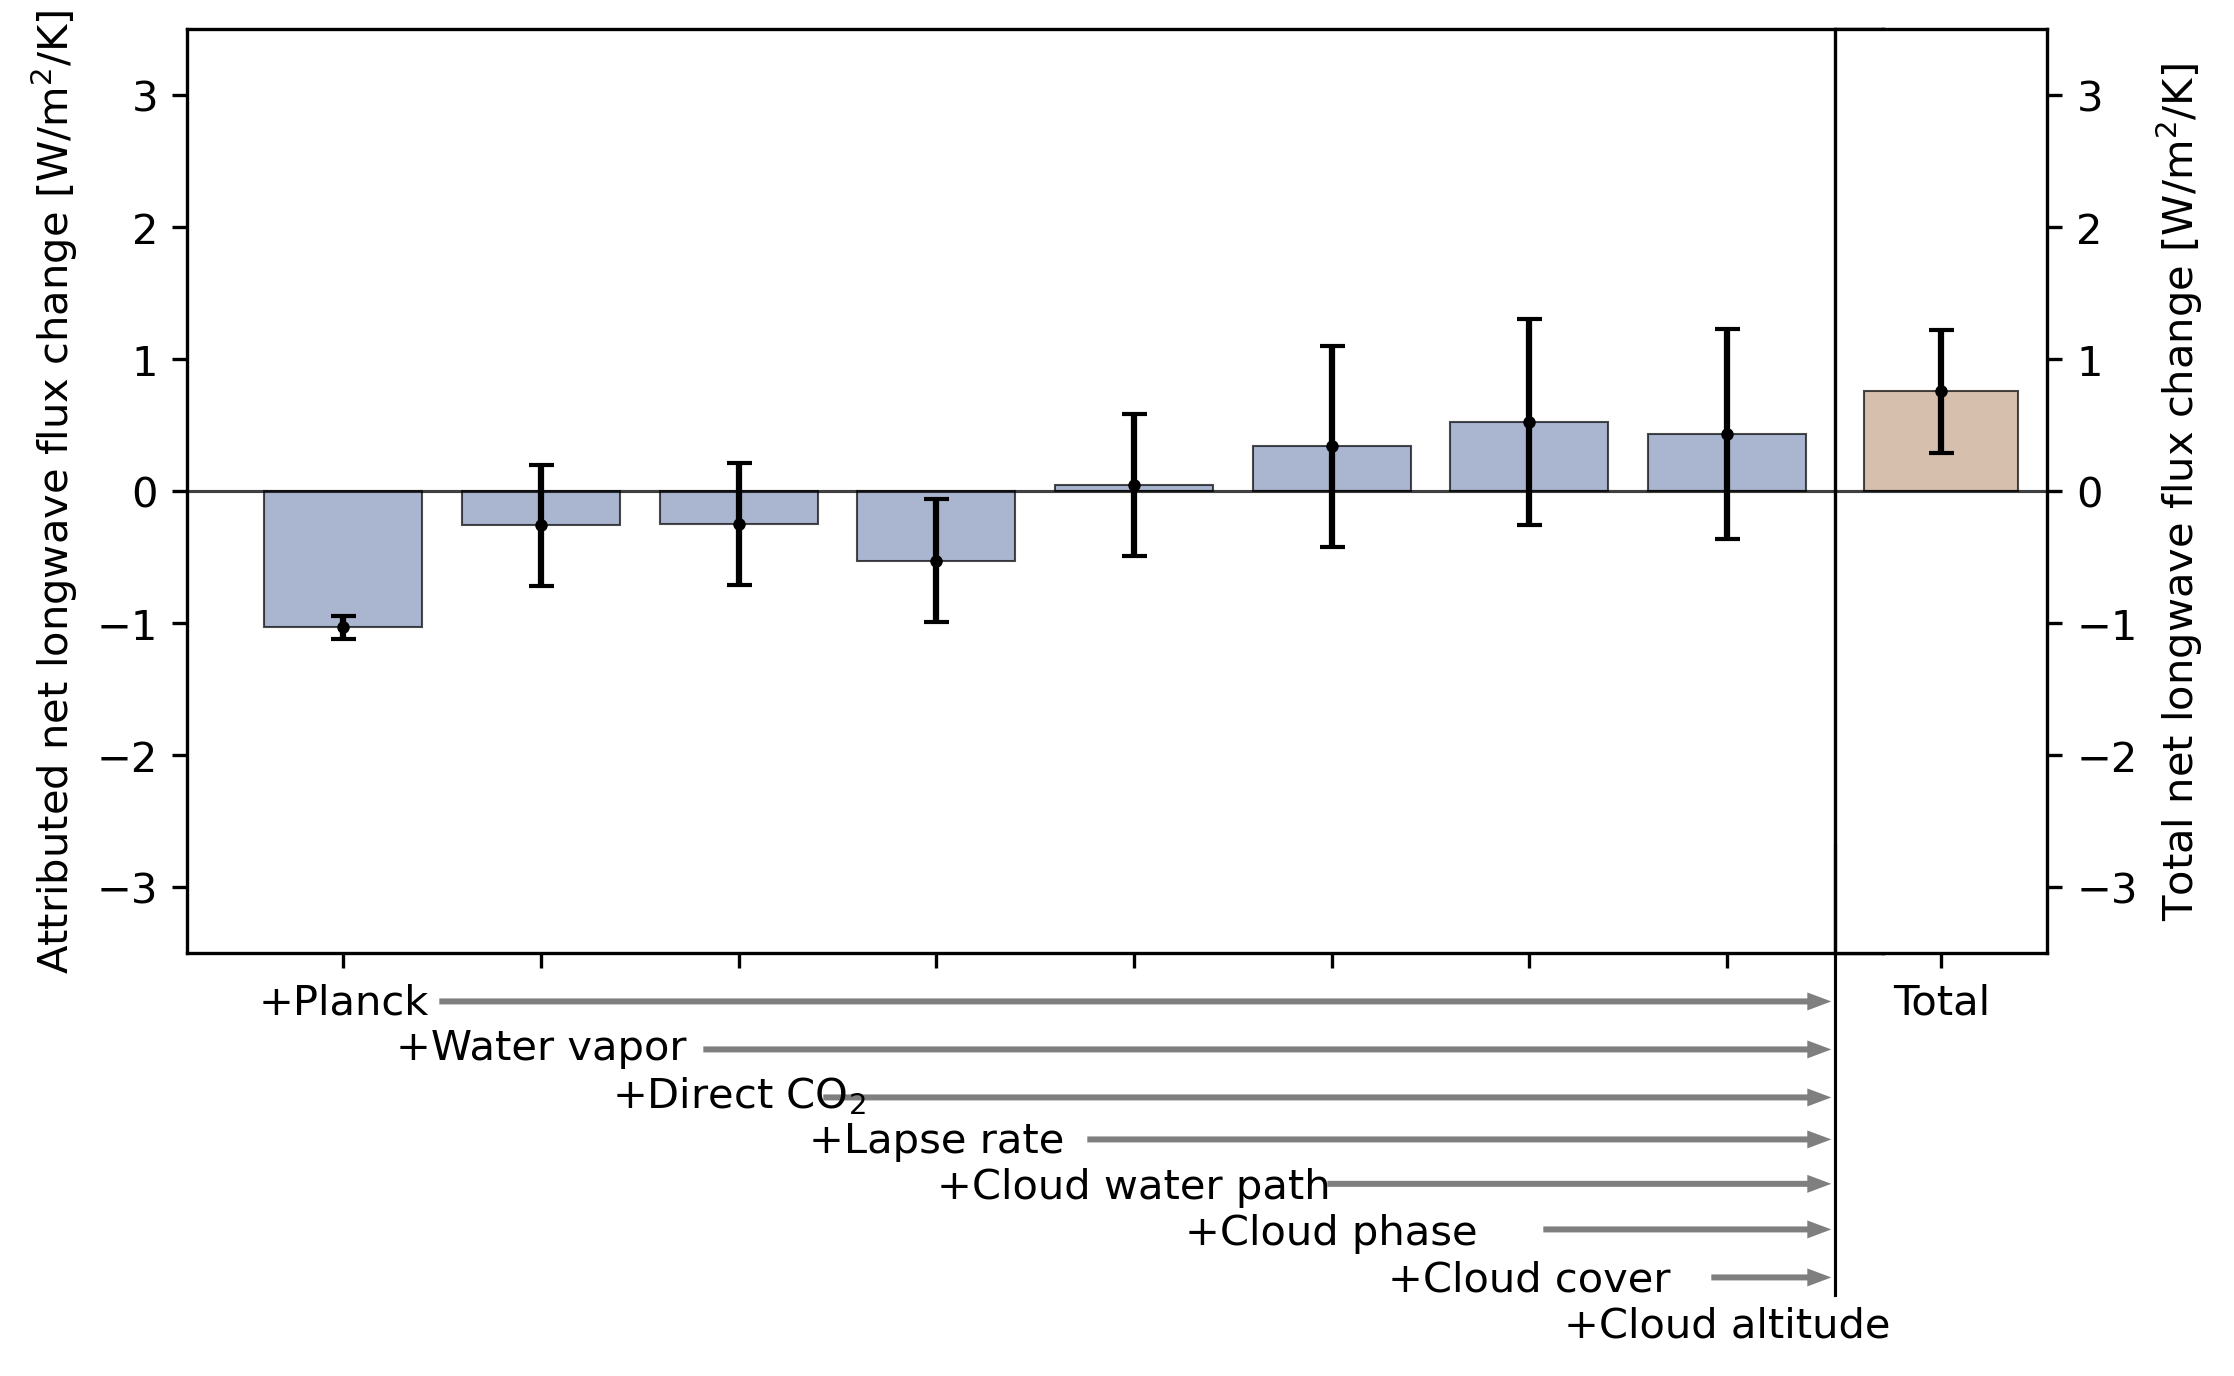

In [47]:
ERROR_PROPAGATION = 'QUAD_NAIVE' #'LINEAR','QUAD_NAIVE'

fig, axes = plt.subplots(1,2,sharex=False,sharey=False,figsize=(8,4),dpi=300,width_ratios=[8,1])
ax = axes[0]
colors = ['#8698BD','#8698BD','#8698BD','#8698BD','#8698BD','#8698BD','#8698BD','#8698BD','#8698BD','#C6A48A','darkgrey'] #orange, blue, grey
csum_med, csum_lo, csum_hi = get_lwn_csum('total',categories='complex',append_radtotal=False)

#bar
labels = [long_names[key] for key in da_med.coords['variable'].data]
labels_cr = [(i*'\n')+'+'+s for i,s in enumerate(labels)]
ax.bar(labels_cr,csum_med,bottom=0,color=colors,**bar_kws)
# ax.bar(labels,width=0.8,bottom=csum_med.shift(variable=1),height=da_med,
#        facecolor='salmon',alpha=0.3,edgecolor='k',linewidth=0.5)
#errorbar     
yerr = [np.abs(csum_hi-csum_med), np.abs(csum_med-csum_lo)]
ax.errorbar(labels_cr,csum_med,yerr=yerr,**errorbar_kws)
#labels
ax.set_ylabel('Attributed net longwave flux change [W/m$^2$/K]')
if ax.get_ylim()[0]<=0.0:
    ax.axhline(0,c='k',lw=0.75,alpha=0.75)
#ax.text(0.02,0.055,'Cumulative sum$\longrightarrow$',transform=ax.transAxes)
# for label in ax.get_xticklabels():
#     label.set_ha("left")
#     label.set_rotation(-30)
ax.set_ylim(-3.5,3.5)
#raw total from radiometer
ax = axes[1]
hi, med, lo = dxdt_hi['lwn'].sel(type='all'), dxdt_med['lwn'].sel(type='all'), dxdt_lo['lwn'].sel(type='all')
hi, med, lo = hi.data[np.newaxis], med.data[np.newaxis], lo.data[np.newaxis]
ax.bar(['Total'],med,width=0.725,color='#C6A48A',**bar_kws)
yerr = [np.abs(hi-med), np.abs(med-lo)]
ax.errorbar(['Total'],med,yerr=yerr,**errorbar_kws)
ax.set_xlim(-0.5,0.5)
if ax.get_ylim()[0]<=0.0:
    ax.axhline(0,c='k',lw=0.75,alpha=0.75)
ax.set_ylabel('Total net longwave flux change [W/m$^2$/K]')
# for label in ax.get_xticklabels():
#     label.set_ha("left")
#     label.set_rotation(-30)
ax.set_ylim(*axes[0].get_ylim())
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
fig.subplots_adjust(wspace=-0.05)
#fig.tight_layout()
xx = [0.23,0.34,0.39,0.5,0.6,0.69,0.76]
yy = [0.07,0.03,-0.01,-0.045,-0.082,-0.12,-0.16]
for xi,yi in zip(xx,yy):
    x,y = np.array([[xi, 0.8], [yi, yi]])
    line = FancyArrow(xi, yi, 0.8-xi, 0, color='k',ec='none',alpha=0.5, width=0.005, head_width=0.015, head_length=0.01)
    fig.add_artist(line)
line = Line2D([0.8115,0.8115],[-0.175,0.2],c='k',lw=0.75)
fig.add_artist(line)
#fig.savefig('60-net_longwave_sum_linegrow_allsky_OLS_newboot_complex_neworder2.pdf',bbox_inches='tight')

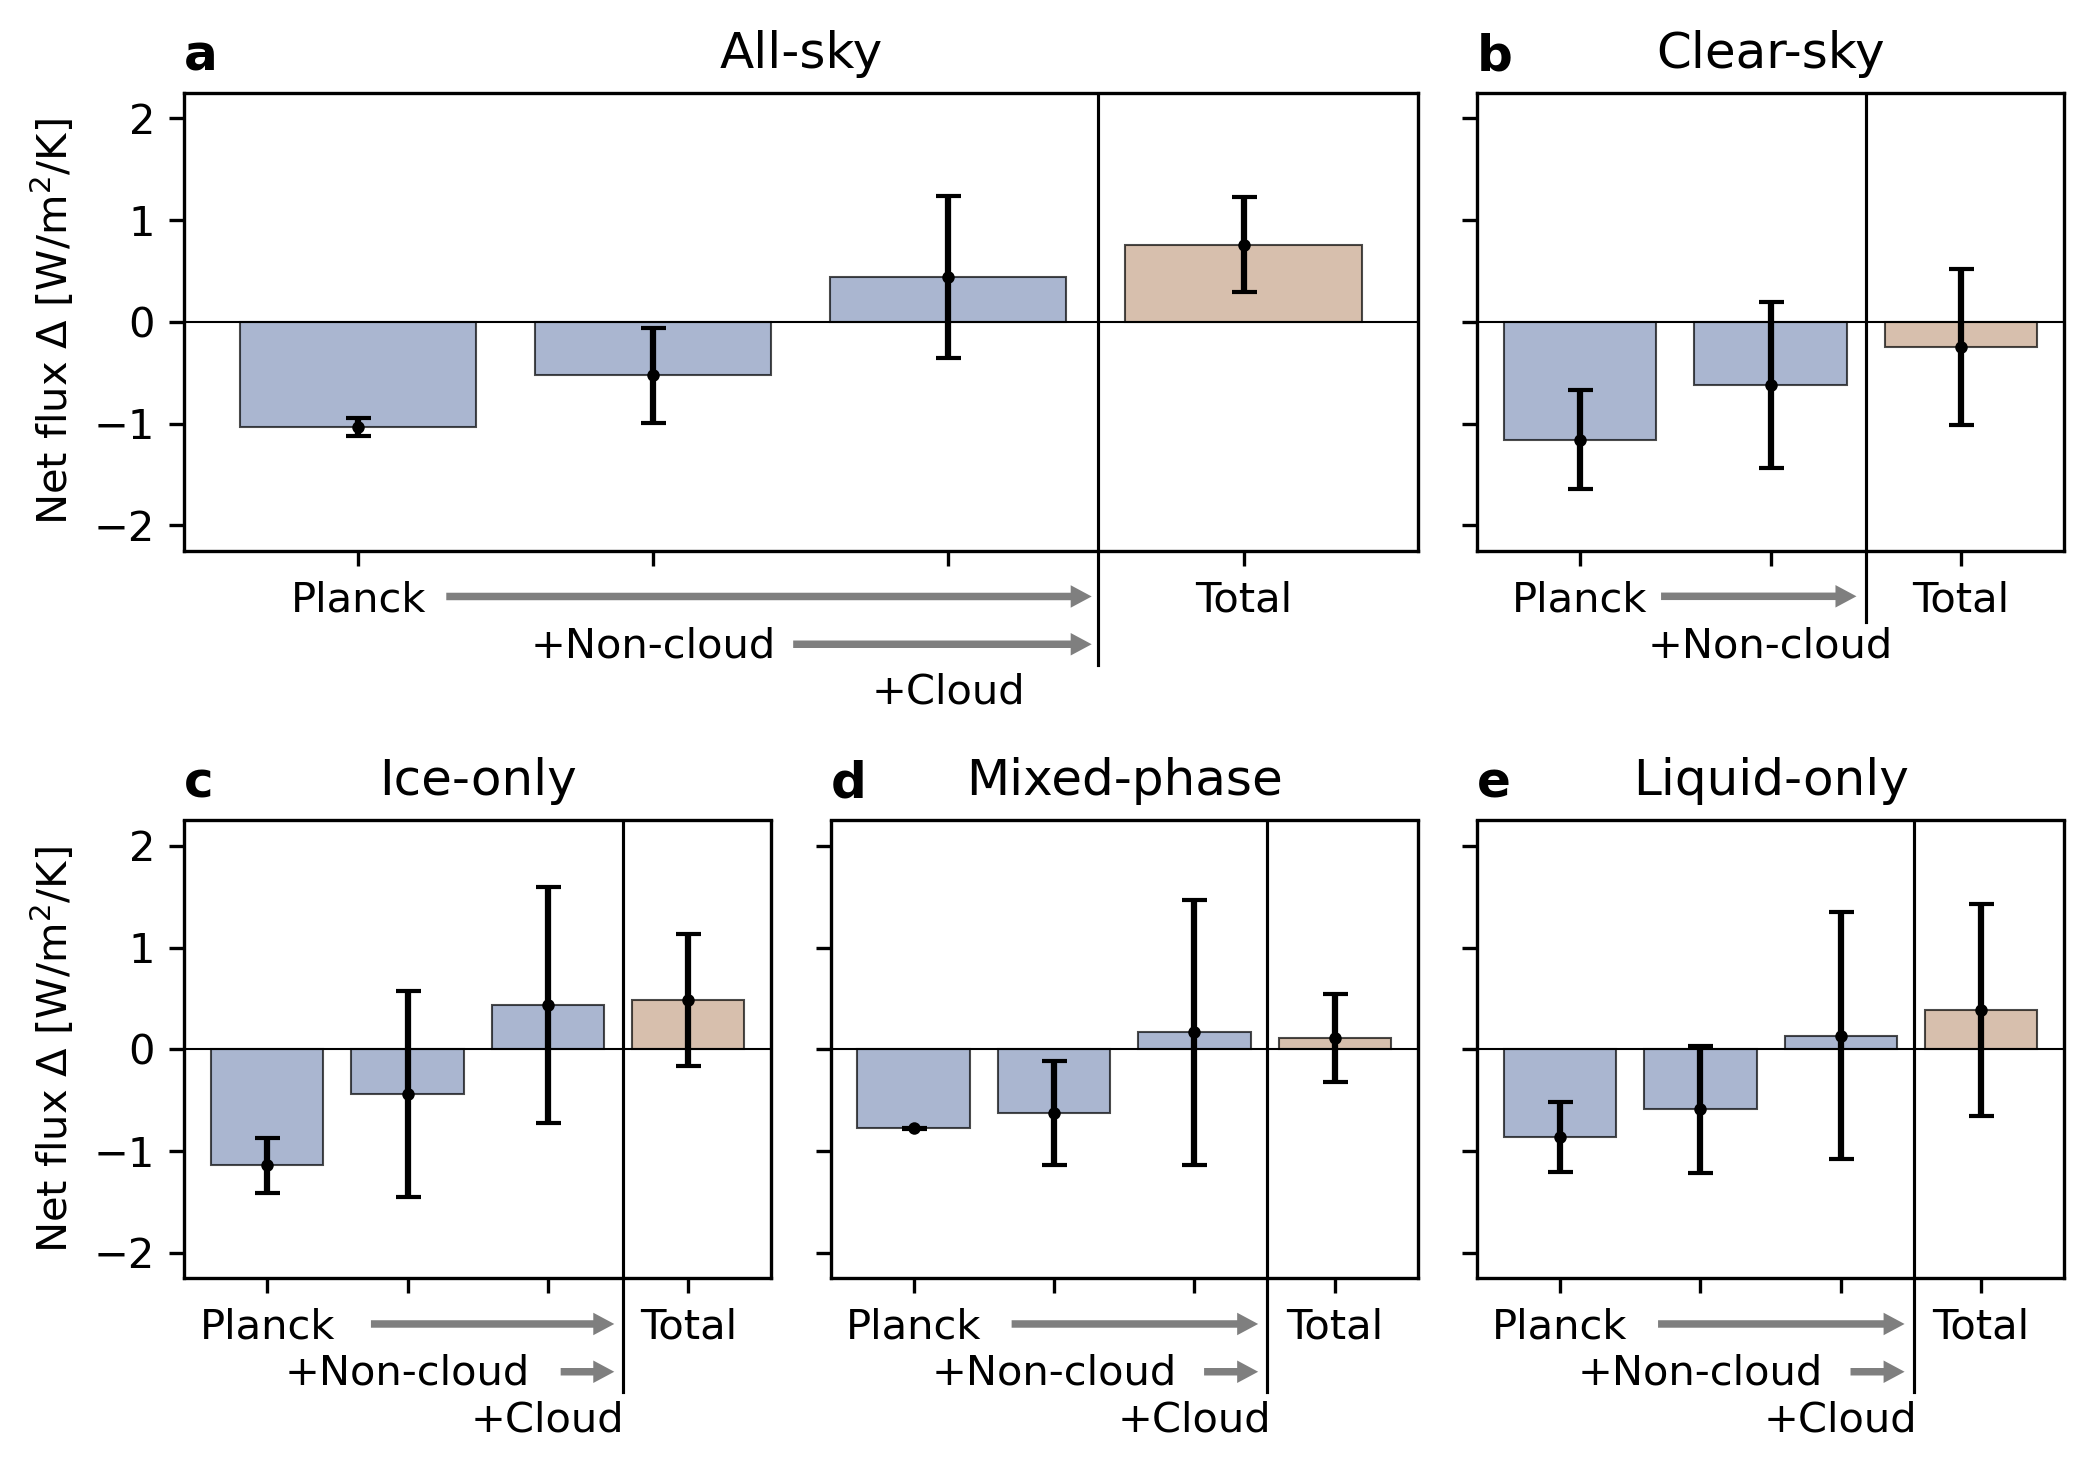

In [48]:
fig,axes = plt.subplots(2,3,dpi=300,figsize=(7,5),sharey=True,height_ratios=[1,1])
colors = ['#8698BD','#8698BD','#8698BD','#C6A48A','darkgrey'] #orange, blue, grey

#turn second row into one long axis
gs = axes[0, 0].get_gridspec()
# remove the underlying Axes
for ax in axes[0, :2]:
    ax.remove()
axbig = fig.add_subplot(gs[0, :2])

axlist = [axbig,*axes.flatten()[2:]]

long_type_names = {'mixed': 'Mixed-phase',
                   'ice':'Ice-only',
                   'liquid':'Liquid-only',
                   'clear':'Clear-sky',
                   'total':'All-sky'}


for ax,which in zip(axlist,['total','clear','ice','mixed','liquid']):        
    #bar
    csum_med, csum_lo, csum_hi = get_lwn_csum(which)
    if which == 'clear':
        labels = ['Planck','Non-cloud','Total']
    else:
        labels = ['Planck','Non-cloud','Cloud','Total']
    labels_cr = [(i*'\n')+'+'+s for i,s in enumerate(labels)]
    labels_cr[0] = labels_cr[0][1:]
    labels_cr[-1] = labels[-1]
    icolors = colors[1:] if which == 'clear' else colors
    ax.bar(labels_cr,csum_med,bottom=0,color=icolors,**bar_kws)
    #errorbar     
    yerr = [np.abs(csum_hi-csum_med), np.abs(csum_med-csum_lo)]
    ax.errorbar(labels_cr,csum_med,yerr=yerr,**errorbar_kws)
    ax.set_title(long_type_names[which])
    ax.axhline(0,c='k',lw=0.5,alpha=1)


fig.tight_layout()
axbig.set_ylim([-2.25,2.25])
axes[1,0].set_ylim([-2.25,2.25])
axbig.set_ylabel('Net flux $\Delta$ [W/m$^2$/K]')
axes[1,0].set_ylabel('Net flux $\Delta$ [W/m$^2$/K]')
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axlist:
    ax.text(0.0,1.05,next(letter),weight='bold',size='large',transform=ax.transAxes)
#add arrows
#regular ones
for ax in axlist[2:]:
    [x0,y0],[x1,y1] = ax.get_tightbbox().get_points()
    width, height = fig.get_size_inches()*fig.dpi
    x0, y0, x1, y1 = x0/width, y0/height, x1/width, y1/height
    dx,dy = x1-x0, y1-y0
    if ax in [axbig,axes[1,0]]:
        x0 = x0+0.2*dx
        dx = dx*0.8
    xx = [x0+0.325*dx,x0+0.645*dx]
    yy = [y0+0.17*dy,y0+0.1*dy]
    for xi,yi in zip(xx,yy):
        x,y = np.array([[xi, 0.8], [yi, yi]])
        line = FancyArrow(xi, yi, x0+0.7*dx-xi, 0, color='k',ec='none',alpha=0.5, width=0.005, head_width=0.015, head_length=0.01)
        fig.add_artist(line)
    line = Line2D([x0+0.75*dx,x0+0.75*dx],[y0+0.07*dy,0.91*y1],c='k',lw=0.75)
    fig.add_artist(line)

#all-sky
ax = axbig
if True:
    [x0,y0],[x1,y1] = ax.get_tightbbox().get_points()
    width, height = fig.get_size_inches()*fig.dpi
    x0, y0, x1, y1 = x0/width, y0/height, x1/width, y1/height
    dx,dy = x1-x0, y1-y0
    xx = [x0+0.3*dx,x0+0.55*dx]
    yy = [y0+0.17*dy,y0+0.1*dy]
    for xi,yi in zip(xx,yy):
        x,y = np.array([[xi, 0.8], [yi, yi]])
        line = FancyArrow(xi, yi, x0+0.75*dx-xi, 0, color='k',ec='none',alpha=0.5, width=0.005, head_width=0.015, head_length=0.01)
        fig.add_artist(line)
    line = Line2D([x0+0.77*dx,x0+0.77*dx],[y0+0.07*dy,0.955*y1],c='k',lw=0.75)
    fig.add_artist(line)

#clear-sky
ax = axlist[1]
if True:
    [x0,y0],[x1,y1] = ax.get_tightbbox().get_points()
    width, height = fig.get_size_inches()*fig.dpi
    x0, y0, x1, y1 = x0/width, y0/height, x1/width, y1/height
    dx,dy = x1-x0, y1-y0
    xx = [x0+0.33*dx]#,x0+0.55*dx]
    yy = [y0+0.11*dy]#,y0+0.1*dy]
    for xi,yi in zip(xx,yy):
        line = FancyArrow(xi, yi, x0+0.62*dx-xi, 0, color='k',ec='none',alpha=0.5, width=0.005, head_width=0.015, head_length=0.01)
        fig.add_artist(line)
    line = Line2D([x0+0.67*dx,x0+0.67*dx],[y0+0.07*dy,0.955*y1],c='k',lw=0.75)
    fig.add_artist(line)
#fig.savefig('67-2-fig03_bertrand2025_R2R_tweaks.pdf',bbox_inches='tight')

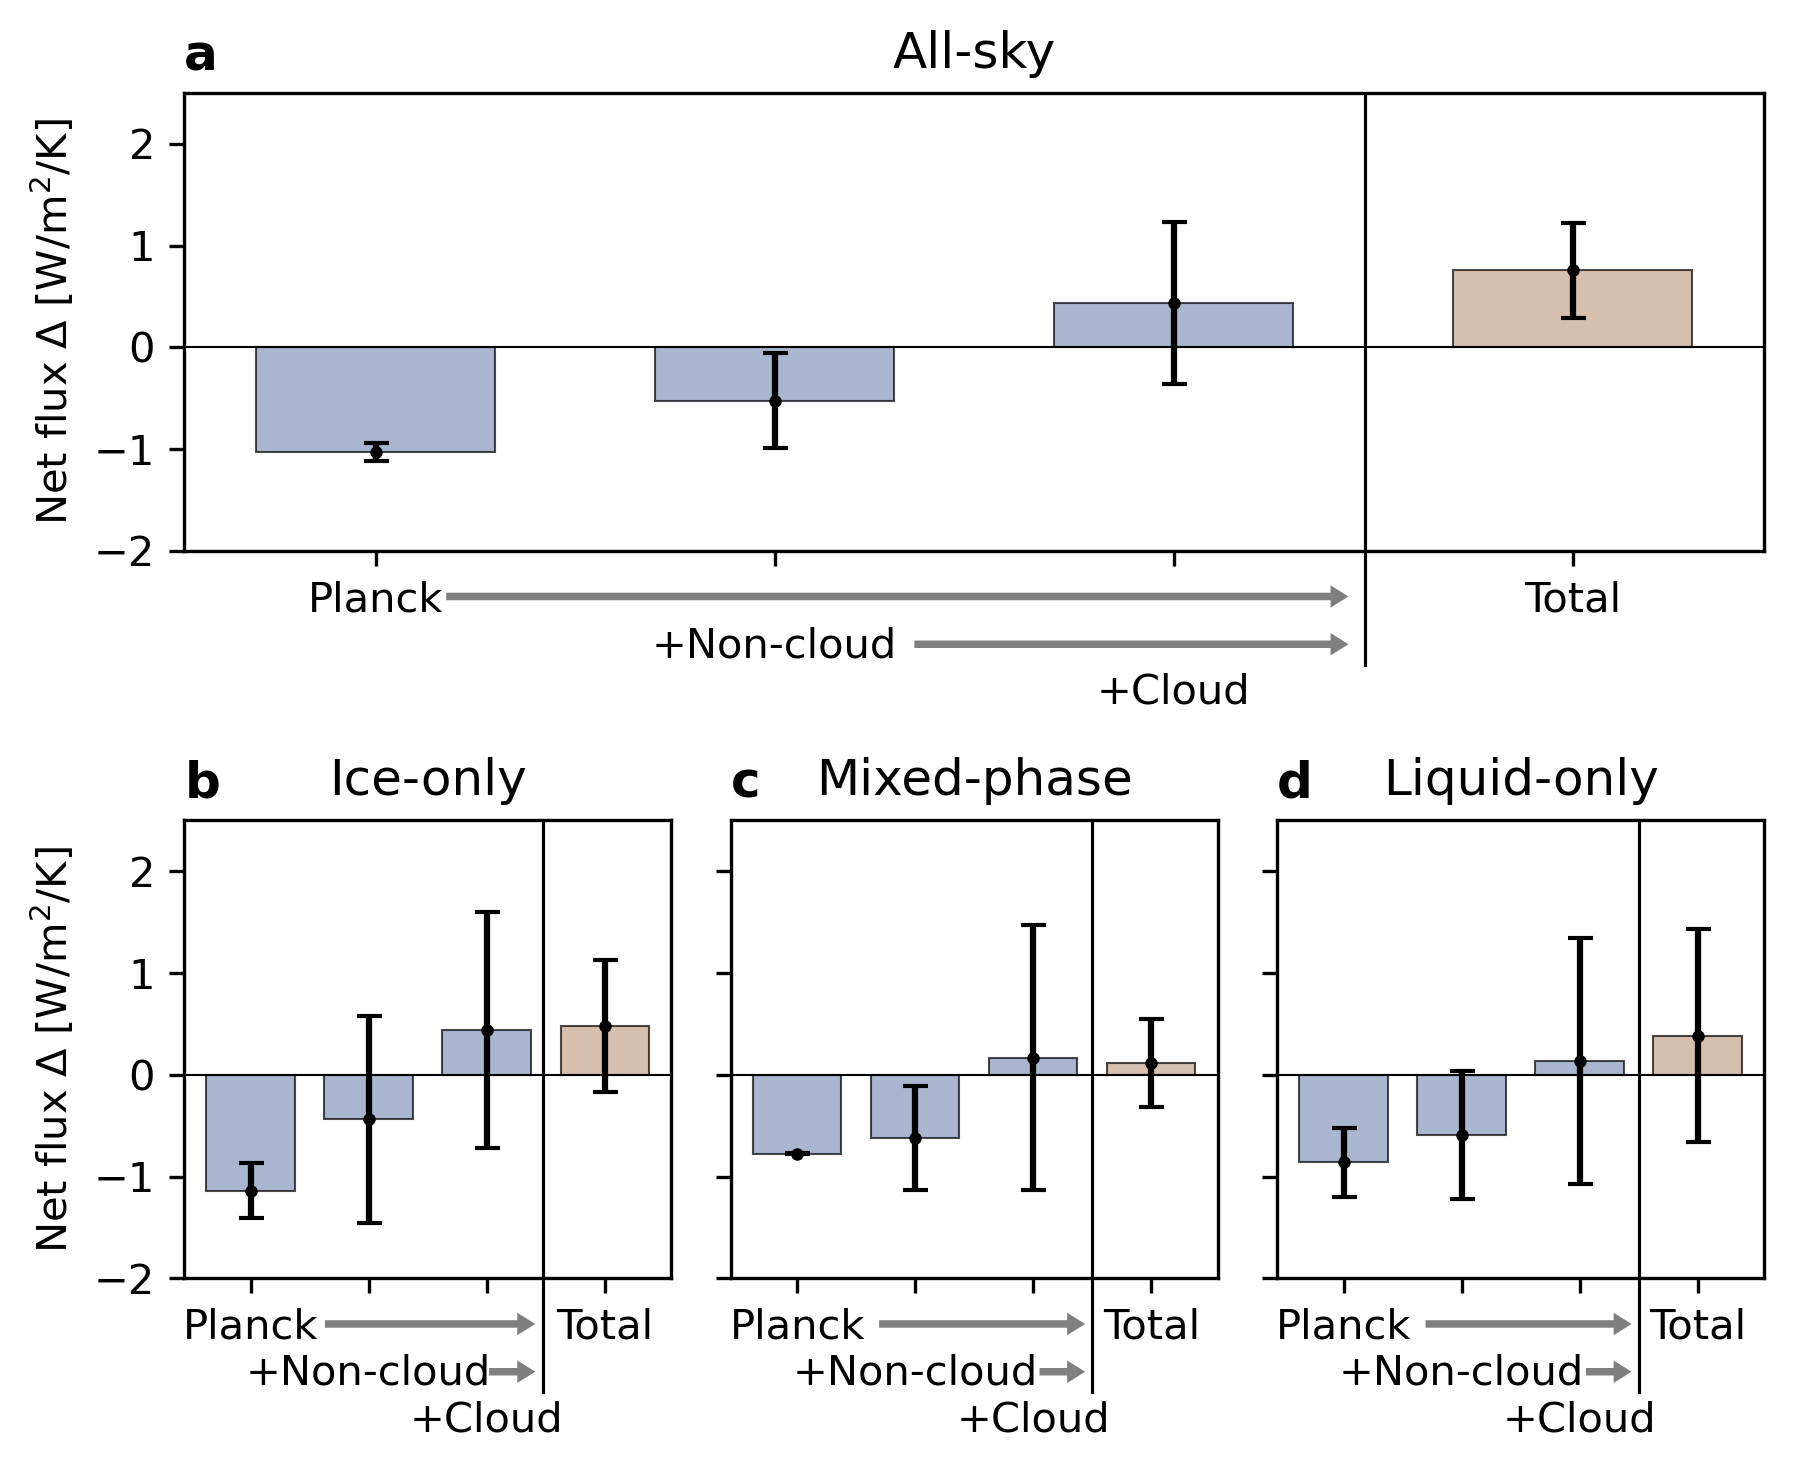

In [49]:
fig,axes = plt.subplots(2,3,dpi=300,figsize=(6,5),sharey=True,height_ratios=[1,1])
colors = ['#8698BD','#8698BD','#8698BD','#C6A48A','darkgrey'] #orange, blue, grey

#turn second row into one long axis
gs = axes[0, 0].get_gridspec()
# remove the underlying Axes
for ax in axes[0, :]:
    ax.remove()
axbig = fig.add_subplot(gs[0, :])

axlist = [axbig,*axes.flatten()[3:]]

for ax,which in zip(axlist,['total','ice','mixed','liquid']):
    width = 0.6 if which == 'total' else 0.75
    #bar
    csum_med, csum_lo, csum_hi = get_lwn_csum(which)
    labels = ['Planck','Non-cloud','Cloud','Total']
    labels_cr = [(i*'\n')+'+'+s for i,s in enumerate(labels)]
    labels_cr[0] = labels_cr[0][1:]
    labels_cr[-1] = labels[-1]
    ax.bar(labels_cr,csum_med,width=width,bottom=0,color=colors,**bar_kws)
# ax.bar(labels,width=0.8,bottom=csum_med.shift(variable=1),height=da_med,
#        facecolor='salmon',alpha=0.3,edgecolor='k',linewidth=0.5)
    #errorbar     
    yerr = [np.abs(csum_hi-csum_med), np.abs(csum_med-csum_lo)]
    ax.errorbar(labels_cr,csum_med,yerr=yerr,**errorbar_kws)
    ax.set_title(long_type_names[which])
    ax.axhline(0,c='k',lw=0.5,alpha=1)
    #ax.text(0.5,0.9,which.capitalize(),weight='regular',ha='center',transform=ax.transAxes)

fig.tight_layout()
axbig.set_ylim([-2,2.5])
axes[1,0].set_ylim([-2,2.5])
axbig.set_ylabel('Net flux $\Delta$ [W/m$^2$/K]')
axes[1,0].set_ylabel('Net flux $\Delta$ [W/m$^2$/K]')
#axbig.set_ylabel('$\partial_T F_N$ [W/m$^2$/K]')
#axes[1,0].set_ylabel('$\partial_T F_N$ [W/m$^2$/K]')
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axlist:
    ax.text(0.0,1.05,next(letter),weight='bold',size='large',transform=ax.transAxes)
#add arrows
for ax in axlist[1:]:
    [x0,y0],[x1,y1] = ax.get_tightbbox().get_points()
    width, height = fig.get_size_inches()*fig.dpi
    x0, y0, x1, y1 = x0/width, y0/height, x1/width, y1/height
    dx,dy = x1-x0, y1-y0
    if ax in [axbig,axes[1,0]]:
        x0 = x0+0.2*dx
        dx = dx*0.8
    xx = [x0+0.325*dx,x0+0.645*dx]
    yy = [y0+0.17*dy,y0+0.1*dy]
    for xi,yi in zip(xx,yy):
        x,y = np.array([[xi, 0.8], [yi, yi]])
        line = FancyArrow(xi, yi, x0+0.7*dx-xi, 0, color='k',ec='none',alpha=0.5, width=0.005, head_width=0.015, head_length=0.01)
        fig.add_artist(line)
    line = Line2D([x0+0.75*dx,x0+0.75*dx],[y0+0.07*dy,0.91*y1],c='k',lw=0.75)
    fig.add_artist(line)

ax = axbig
if True:
    [x0,y0],[x1,y1] = ax.get_tightbbox().get_points()
    width, height = fig.get_size_inches()*fig.dpi
    x0, y0, x1, y1 = x0/width, y0/height, x1/width, y1/height
    dx,dy = x1-x0, y1-y0
    xx = [x0+0.24*dx,x0+0.51*dx]
    yy = [y0+0.17*dy,y0+0.1*dy]
    for xi,yi in zip(xx,yy):
        x,y = np.array([[xi, 0.8], [yi, yi]])
        line = FancyArrow(xi, yi, x0+0.75*dx-xi, 0, color='k',ec='none',alpha=0.5, width=0.005, head_width=0.015, head_length=0.01)
        fig.add_artist(line)
    line = Line2D([x0+0.77*dx,x0+0.77*dx],[y0+0.07*dy,0.955*y1],c='k',lw=0.75)
    fig.add_artist(line)
#fig.savefig('65-net_longwave_sum_simple_noclr_OLS_newboot_newax.pdf',bbox_inches='tight')

# 5. Circulation influence
With the updated analysis (11/6/24), cloud amount alone no longer explains the increase in net flux with warming.

However, IWP alone can still explain the increase (but do I trust it?), as does a combination of LWP and CA. However, LWP+CA is still just barely positive (see `60-net_longwave_sum_linegrow_ allsky_OLS_newboot_complex_neworder2.pdf`).

__Ideas:__
1. ~~Current: net flux and cloud amount~~ (insufficient)
2. net flux and ice water path
3. net flux, cloud amount, and ice water path
4. net flux, liquid water path, and ice water path
5. ~~net flux, cloud amount, liquid water path, and ice water path~~ (too many)
6. net flux, cloud amount, total water path (stacked liquid+ice)
7. net flux, total water path (stacked liquid+ice)

I shouldn't over-emphasize ice-microphysical feedbacks, but cloud-macrophysical feedbacks aren't the whole story anymore.

And now a question: __which types should be considered in the regressions?__

In [50]:
day,dax = ds_typed_anom.lwd.sel(type='all'), ds_typed_anom.temp.sel(type='all')

In [51]:
Y, X = xr.align(day.dropna('time'),dax.dropna('time'))
Y, X = Y.data, X.data
X = sm.add_constant(X)
olsr_djfm_res = sm.OLS(Y,X, missing='drop').fit()

### get long (longer than armbeatm) met
It agrees very well with armbeatm pressure (shown in `55-1`).

In [52]:
from dask.distributed import Client, progress, LocalCluster # used for scheduler/compute cluster
from dask import delayed, compute  # currently unused (1/27, 7-3.ipynb)
import dask.bag as db              # used only for writing nc4s to disk (ibid.)
import dask.multiprocessing        # where does this get used? maybe I saw it in a S/O answer?
### INITIALIZE CLUSTER ###
n_workers = 8
threads_per_worker = 1
cluster = LocalCluster(n_workers=n_workers, 
        threads_per_worker=threads_per_worker)
client = Client(cluster)
print(f'initialized dask cluster with {n_workers} workers and {threads_per_worker} threads per worker.')
print(f'View the cluster at {client.dashboard_link}')

/Users/leah/miniforge3/envs/sci/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58217 instead
  warnings.warn(


initialized dask cluster with 8 workers and 1 threads per worker.
View the cluster at http://127.0.0.1:58217/status


In [53]:
REPROCESS=False
if REPROCESS:
    folder = Path('~/Documents/arm_data/nsaqcrad1longC1.c1').expanduser()
    fpaths = sorted(folder.glob('*.cdf'))
    #load c1 time period
    sample = xr.open_dataset(fpaths[0])
    pres_c1 = xr.open_mfdataset(fpaths,drop_variables=set(sample).difference(['press']))
    pres_c1 = pres_c1.compute()
    folder = Path('~/Documents/arm_data/nsaqcrad1longC1.c2').expanduser()
    fpaths = sorted(folder.glob('*.cdf'))
    #load c2 time period
    sample = xr.open_dataset(fpaths[0])
    pres_c2 = xr.open_mfdataset(fpaths,drop_variables=set(sample).difference(['press']))
    pres_c2 = pres_c2.compute()
    #fill in with c1 if c2 is missing and c1 is nonzero
    pres_c1, pres_c2 = xr.align(pres_c1,pres_c2,join='outer')
    pres_c1c2 = xr.where(np.isnan(pres_c2), pres_c1, pres_c2)
    #resample, convert units
    pres = pres_c1c2.press.resample(time='D').mean()*10
    folder=Path('~/Documents/arm_data/ipynb_processed').expanduser()
    pres.to_netcdf(folder/'60-nsa_daily_local_sfc_press.nc')
else:
    folder=Path('~/Documents/arm_data/ipynb_processed').expanduser()
    pres = xr.open_dataset(folder/'60-nsa_daily_local_sfc_press.nc').press
slp = pres

### data prep

In [54]:
declim = lambda ds: ds.groupby('time.month') - ds.groupby('time.month').mean()

dp = 10 #hPa
#bins = np.arange(slp.min(),slp.mean()-dp/2,dp)
#bins = np.concatenate([bins,np.arange(slp.mean()+dp/2,slp.max(),dp)])
bins = np.arange(-30,30+dp,dp)
mids = 0.5*(bins[1:]+bins[:-1])

#prep met
tanom = declim(load_arm_temp())
slp = declim(pres)

#load cloud props
fps = sorted(Path(folder/'28-microshupeturn-columnint-minutely-by-year').glob('*.nc'))
ds = xr.open_mfdataset(fps)
iwp   = ds.iwp.compute()#get_split_iwp(add_type_dim=False)['iwp'] #don't consider IWP>thresh (200 g/m2)
lwp   = ds.lwp.compute()
twp   = iwp+lwp
cf    = ds.tot_cld.compute()

In [55]:
#load phase classification
def bit_packed_to_broad_categories(phases):
    '''convert bit-packed phase mask to bool for a group of bits'''
    
    #define phase categories via the flag values satisifying each category
    cloud_liquid = [3,5]              #liquid, liquid+drizzle
    cloud_mixed  = [7]                #mixed-phase
    cloud_ice    = [1,2]              #ice, snow
    phase_vars   = {'liquid': cloud_liquid,
                    'mixed': cloud_mixed,
                    'ice': cloud_ice}
    
    #get profiles satisfying broad categories specified in phase_vars
    phase_res = { }
    for name,flags in phase_vars.items():
        #convert list of flag values to int with bits on for flag values
        flag_map = bitlist_to_int(flags)
        #check if at least one of the flag values is present in profile
        flag_res = (phases&flag_map) > 0
        phase_res[name] = flag_res

    #exclude liquid-containing profiles as ice
    phase_res['ice'] = phase_res['ice'] & ~(phase_res['mixed'] | phase_res['liquid'])

    #exclude mixed-containing profiles as liquid
    phase_res['liquid'] = phase_res['liquid'] & ~phase_res['mixed']

    #return as dataset
    return xr.Dataset(phase_res)

#load column-integrated phases and convert to broad categories
folder = Path('~/Documents/arm_data/').expanduser()
fps = sorted((folder/'ipynb_processed'/'28-microshupeturn-columnint-minutely-by-year').glob('*.nc'))
st_prof  = xr.open_mfdataset(fps)
is_phase = st_prof.phase.compute().astype(int)
is_phase = bit_packed_to_broad_categories(is_phase)
residual = (st_prof.tot_cld>0) & ~(is_phase['liquid'] | is_phase['mixed'] | is_phase['ice'])
clear    = st_prof.tot_cld==0
is_phase = is_phase.assign({'clear':clear,'other':residual})
is_phase = is_phase.assign(all=xr.ones_like(is_phase['liquid']))
is_phase = is_phase.compute()
for name,total in is_phase.sum('time').items():
    if total == 0:
        print(f'dropping category "{name}" because it contains no observations')
        is_phase = is_phase.drop(name)
#apply layer-based screening of liquid-only cases
fps = sorted((folder/'ipynb_processed'/'59-betterliquidonly-columnint-minutely-by-year').glob('*.nc'))
is_liquid = xr.open_mfdataset(fps).compute()
is_phase['mixed']  = is_phase['mixed']  | is_liquid['liquid_snowing']
is_phase['liquid'] = is_phase['liquid'] & is_liquid['liquid_nosnow']

dropping category "other" because it contains no observations


In [56]:
#load in hourly flux data
c1 = xr.open_dataset('21-LWfluxhourly-NSA_C1-nsaqcrad1longC1.c1.nc')
c2 = xr.open_dataset('21-LWfluxhourly-NSA_C1-nsaqcrad1longC1.c2.nc')
c1, c2 = xr.align(c1,c2,join='outer')

#merge qcrad1long processing levels
#fill in with c1 if c2 is missing and c1 is nonzero
ds_hr = xr.where(np.isnan(c2), c1, c2)

#apply QC (minimum number minutes for an hourly mean)
ds_hr = ds_hr.drop('n_bad')
ds_hr = ds_hr.where(ds_hr.n_miss<30, other=np.nan)

#subsample/anomalize
lwn = ds_hr.flux.sel(term='LWnet')

In [57]:
#enforce phase-condensate consistency
iwp = iwp.where(is_phase['ice'] | is_phase['mixed'])
lwp = lwp.where(is_phase['mixed'] | is_phase['liquid'])
twp = twp.where(cf>0)

#daily frequency
lwn_d = sub_mos(lwn).resample(time='D').mean()
lwn_anom = declim(lwn_d)
iwp_d = sub_mos(iwp).resample(time='D').mean()
iwp_anom = declim(iwp_d)
lwp_d = sub_mos(lwp).resample(time='D').mean()
lwp_anom = declim(lwp_d)
twp_d = sub_mos(twp).resample(time='D').mean()
twp_anom = declim(twp_d)
cf_d = sub_mos(cf).resample(time='D').mean()
cf_anom = declim(cf_d)
tanom = tanom.resample(time='D').mean()

#align
iwp_anom, lwp_anom, twp_anom, cf_anom, lwn_anom, tanom, slp = xr.align(
    iwp_anom, lwp_anom, twp_anom, cf_anom, lwn_anom, tanom, slp, join='outer')
#lwn_anom, tanom2, slp2 = xr.align(lwn_anom, tanom, slp)
cf_anom = 100*cf_anom

#sanity check lwp
lwp_anom.sel(time=lwp_anom>200)

<xarray.DataArray 'lwp' (time: 4)>
array([534.0836 , 500.4448 , 354.18262, 270.43253], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-07 2017-01-08 2017-01-09 2017-01-11
    month    (time) float64 1.0 1.0 1.0 1.0

In [58]:
#mask four consecutive days with unphysically high daily LWP
lwp_anom = lwp_anom.where(lwp_anom<200)
twp_anom = twp_anom.where(lwp_anom<200)

In [59]:
def do_regression(resp_mos,tanom_mos):
    Y, X = xr.align(resp_mos.dropna('time'),tanom_mos.dropna('time'))
    Y, X = Y.data, X.data
    X = sm.add_constant(X)
    olsr_djfm_res = sm.OLS(Y,X, missing='drop').fit()
    return olsr_djfm_res

def gather_strata(resp,tanom,slp):
    reses = [ ]
    for pi,pf in zip(bins[:-1],bins[1:]):
        msk = (pi<=slp) & (slp<pf)
        resp_sub  = resp.sel(time=msk)
        tanom_sub = tanom.sel(time=msk)
        resp_mos  = resp_sub.resample(time='MS').mean()
        tanom_mos = tanom_sub.resample(time='MS').mean()
        olsr_djfm_res = do_regression(resp_mos,tanom_mos)
        reses.append(olsr_djfm_res)
    return reses

def parse_results(reses,alpha=0.05):
    slope_lo, slope_hi, slope_med = [], [], []
    for res in reses:
        slope_lo.append(res.conf_int(alpha)[1,0])
        slope_hi.append(res.conf_int(alpha)[1,1])
        slope_med.append(res.params[1])
    return np.array(slope_lo), np.array(slope_hi), np.array(slope_med)

In [60]:
resp = cf_anom
reses = gather_strata(resp, tanom, slp)
slope_lo, slope_hi, slope_med = parse_results(reses)

In [61]:
cf_d, slp_d, tanom_d = xr.align(cf_d, slp, tanom)
resp = cf_d
resp_strata = [ ]
for pi,pf in zip(bins[:-1],bins[1:]):
    msk = (pi<=slp_d) & (slp_d<pf)
    resp_sub  = resp.sel(time=msk)
    tanom_sub = tanom_d.sel(time=msk)
    resp_mos  = resp_sub.resample(time='MS').mean()
    tanom_mos = tanom_sub.resample(time='MS').mean()
    #olsr_djfm_res = do_regression(resp_mos,tanom_mos)
    resp_strata.append(resp_mos)

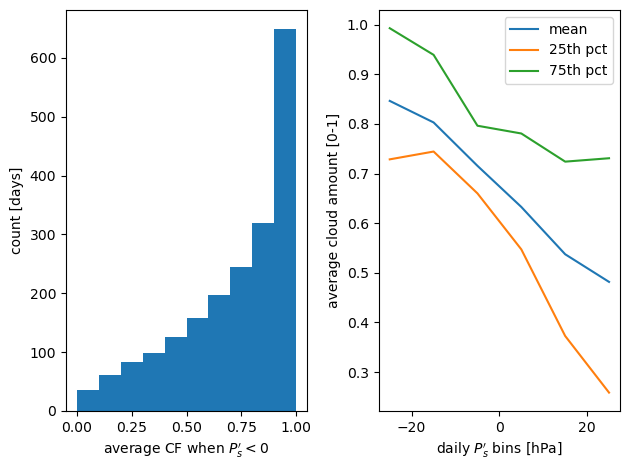

In [62]:
plt.subplot(121)
resp_sub = resp.sel(time=slp_d<0)
counts, _, _ = plt.hist(resp_sub,cumulative=True)
plt.ylabel('count [days]')
plt.xlabel('average CF when $P_s^\prime<0$')
plt.subplot(122)
cf_avg_strata = [strata.mean('time') for strata in resp_strata]
cf_low_strata = [strata.quantile(0.25) for strata in resp_strata]
cf_hi_strata  = [strata.quantile(0.75) for strata in resp_strata]
plt.plot(0.5*(bins[:-1]+bins[1:]), cf_avg_strata, label='mean')
plt.plot(0.5*(bins[:-1]+bins[1:]), cf_low_strata, label='25th pct')
plt.plot(0.5*(bins[:-1]+bins[1:]), cf_hi_strata, label='75th pct')
plt.legend()
plt.xlabel('daily $P_s^\prime$ bins [hPa]')
plt.ylabel('average cloud amount [0-1]')
plt.tight_layout()

## 5.1 Net flux and cloud amount

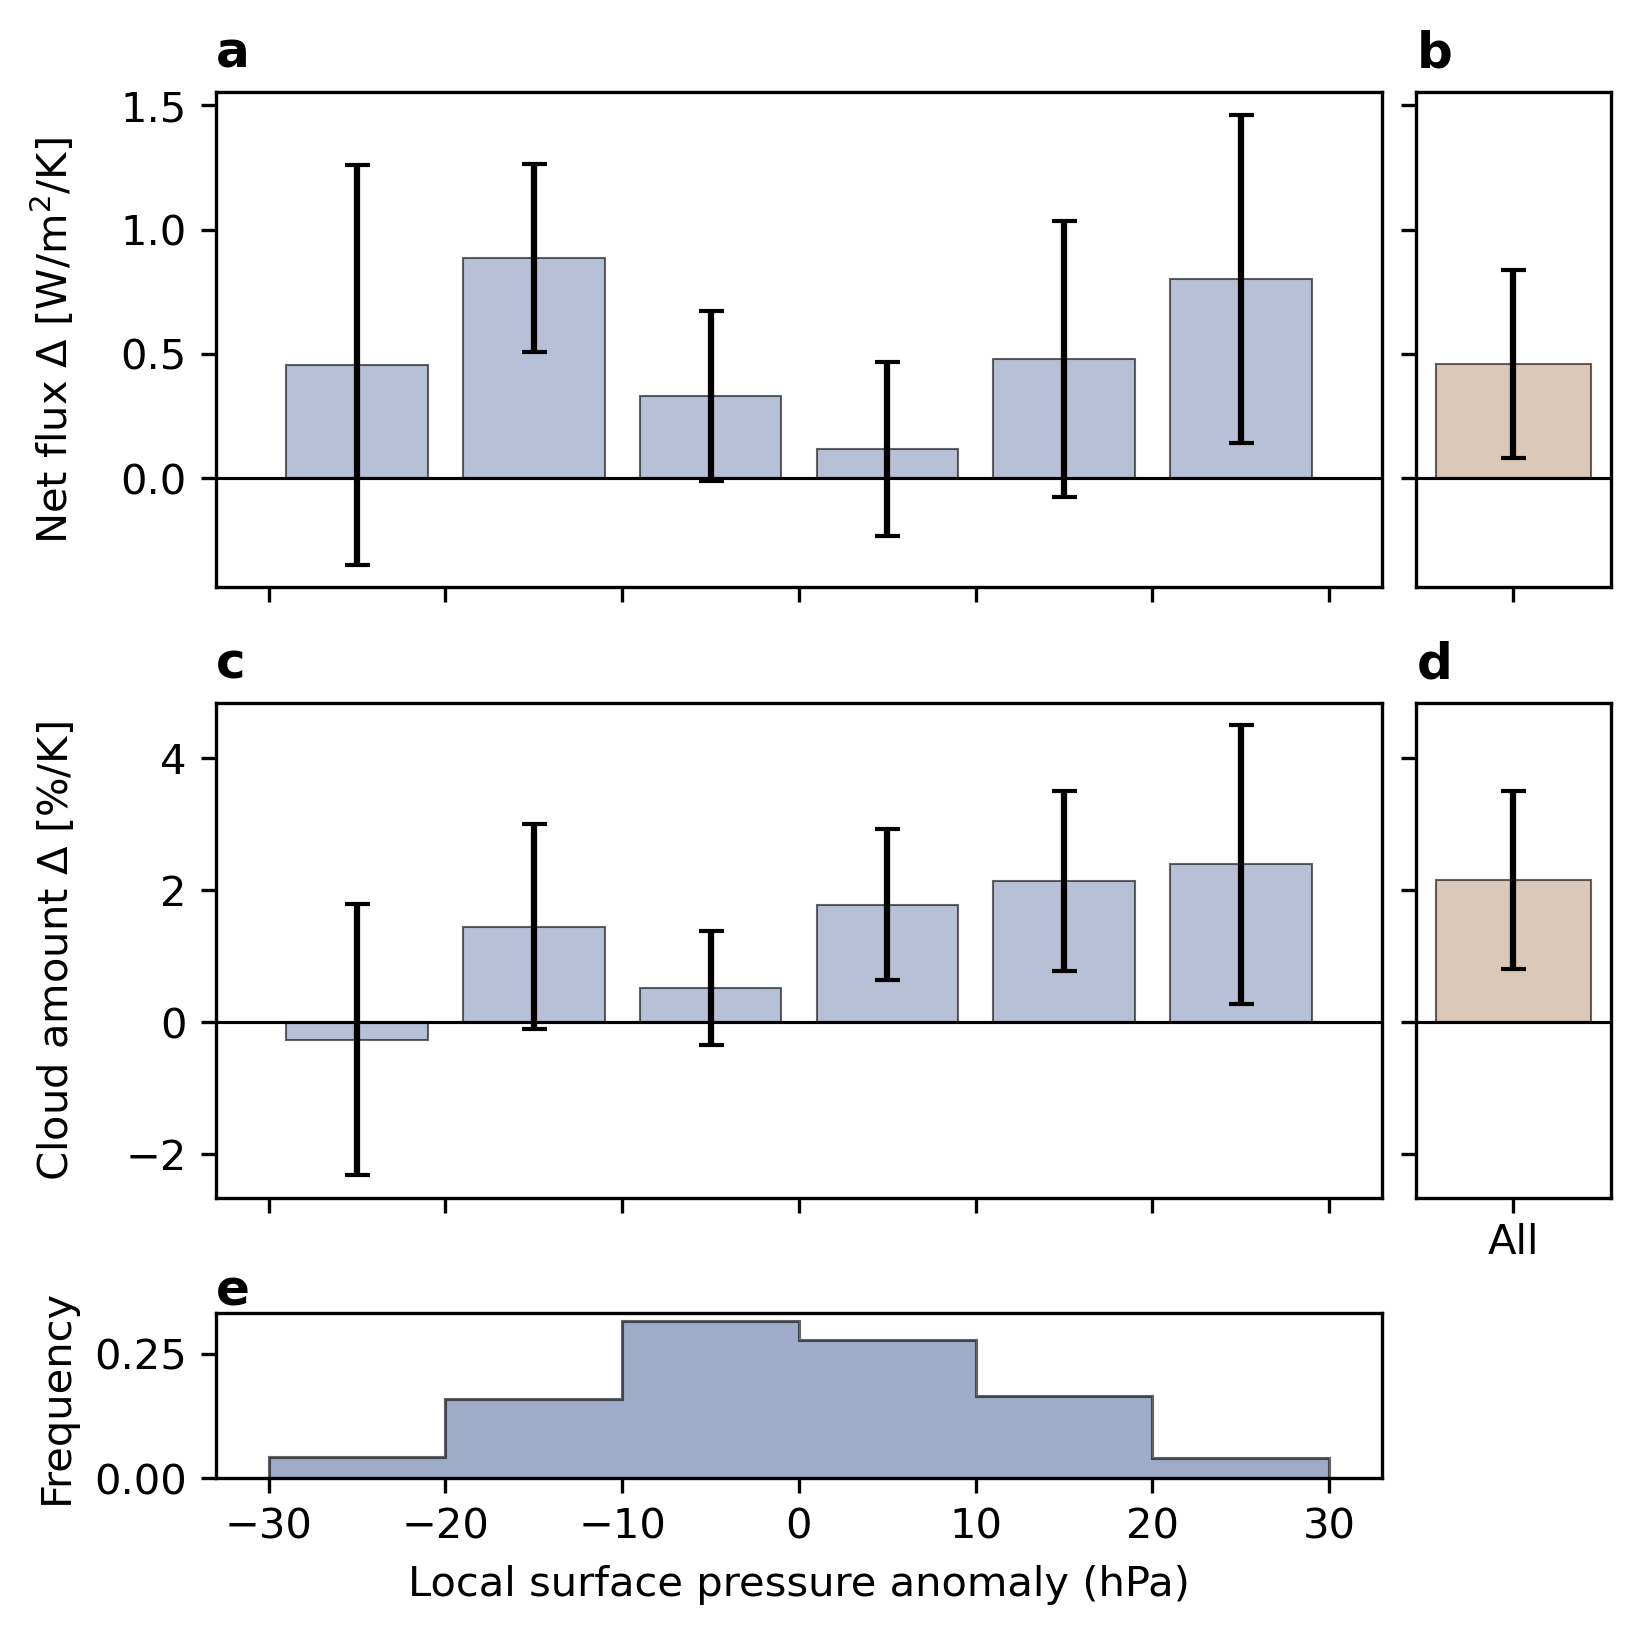

In [63]:
errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
bar_kws      = {'alpha':0.6,'edgecolor':'k','linewidth':0.5}
fig, axes = plt.subplots(3,2,sharex='col',figsize=(6,6),width_ratios=[6,1],height_ratios=[3,3,1],sharey='row',dpi=300)
for i,resp in enumerate([lwn_anom,cf_anom]):
    #stratified estimate
    ax = axes[i,0]
    reses = gather_strata(resp, tanom, slp)
    slope_lo, slope_hi, slope_med = parse_results(reses,alpha=0.05)
    #  bar
    ax.bar(mids,slope_med,color='#8698BD',width=0.8*dp,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(mids,slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    #crude estimate
    ax = axes[i,1]
    resp = resp.resample(time='MS').mean()
    pred = tanom.resample(time='MS').mean()
    res = do_regression(resp, pred)
    slope_lo, slope_hi, slope_med = parse_results([res])
    if i>0: ax.text(0.5,-0.05,'All',ha='center',va='top',transform=ax.transAxes)
    #  bar
    ax.bar(['Total'],slope_med,color='#C6A48A',width=0.8,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(['Total'],slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    ax.set_xlim(-0.5,0.5)

#histogram
ax = axes[-1,0]
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))
slp_djfm = sub_mos(slp)
counts, _ = np.histogram(slp_djfm,bins=bins)
ax.stairs(counts/np.sum(counts),bins,facecolor='#8698BD',alpha=0.8,fill=True)
ax.stairs(counts/np.sum(counts),bins,color='k',lw=0.75,alpha=0.6)
plt.xlabel('surface pressure [hPa]')
plt.ylabel('days')
axes[2,0].set_xlabel('Local surface pressure anomaly (hPa)')
axes[2,0].set_ylabel('Frequency')
axes[1,0].set_ylabel('Cloud amount $\Delta$ [%/K]')
axes[0,0].set_ylabel('Net flux $\Delta$ [W/m$^2$/K]')
axes[2,1].set_visible(False)
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axes.flatten()[:-1]:
    ax.text(0.0,1.05,next(letter),weight='bold',size='large',transform=ax.transAxes)
fig.align_ylabels()
fig.subplots_adjust(wspace=0.05,hspace=0.3)
#fig.savefig('60-stratified_regression_net_flux_and_cloud_amount.pdf',bbox_inches='tight')

## 5.2 Net flux and ice water path

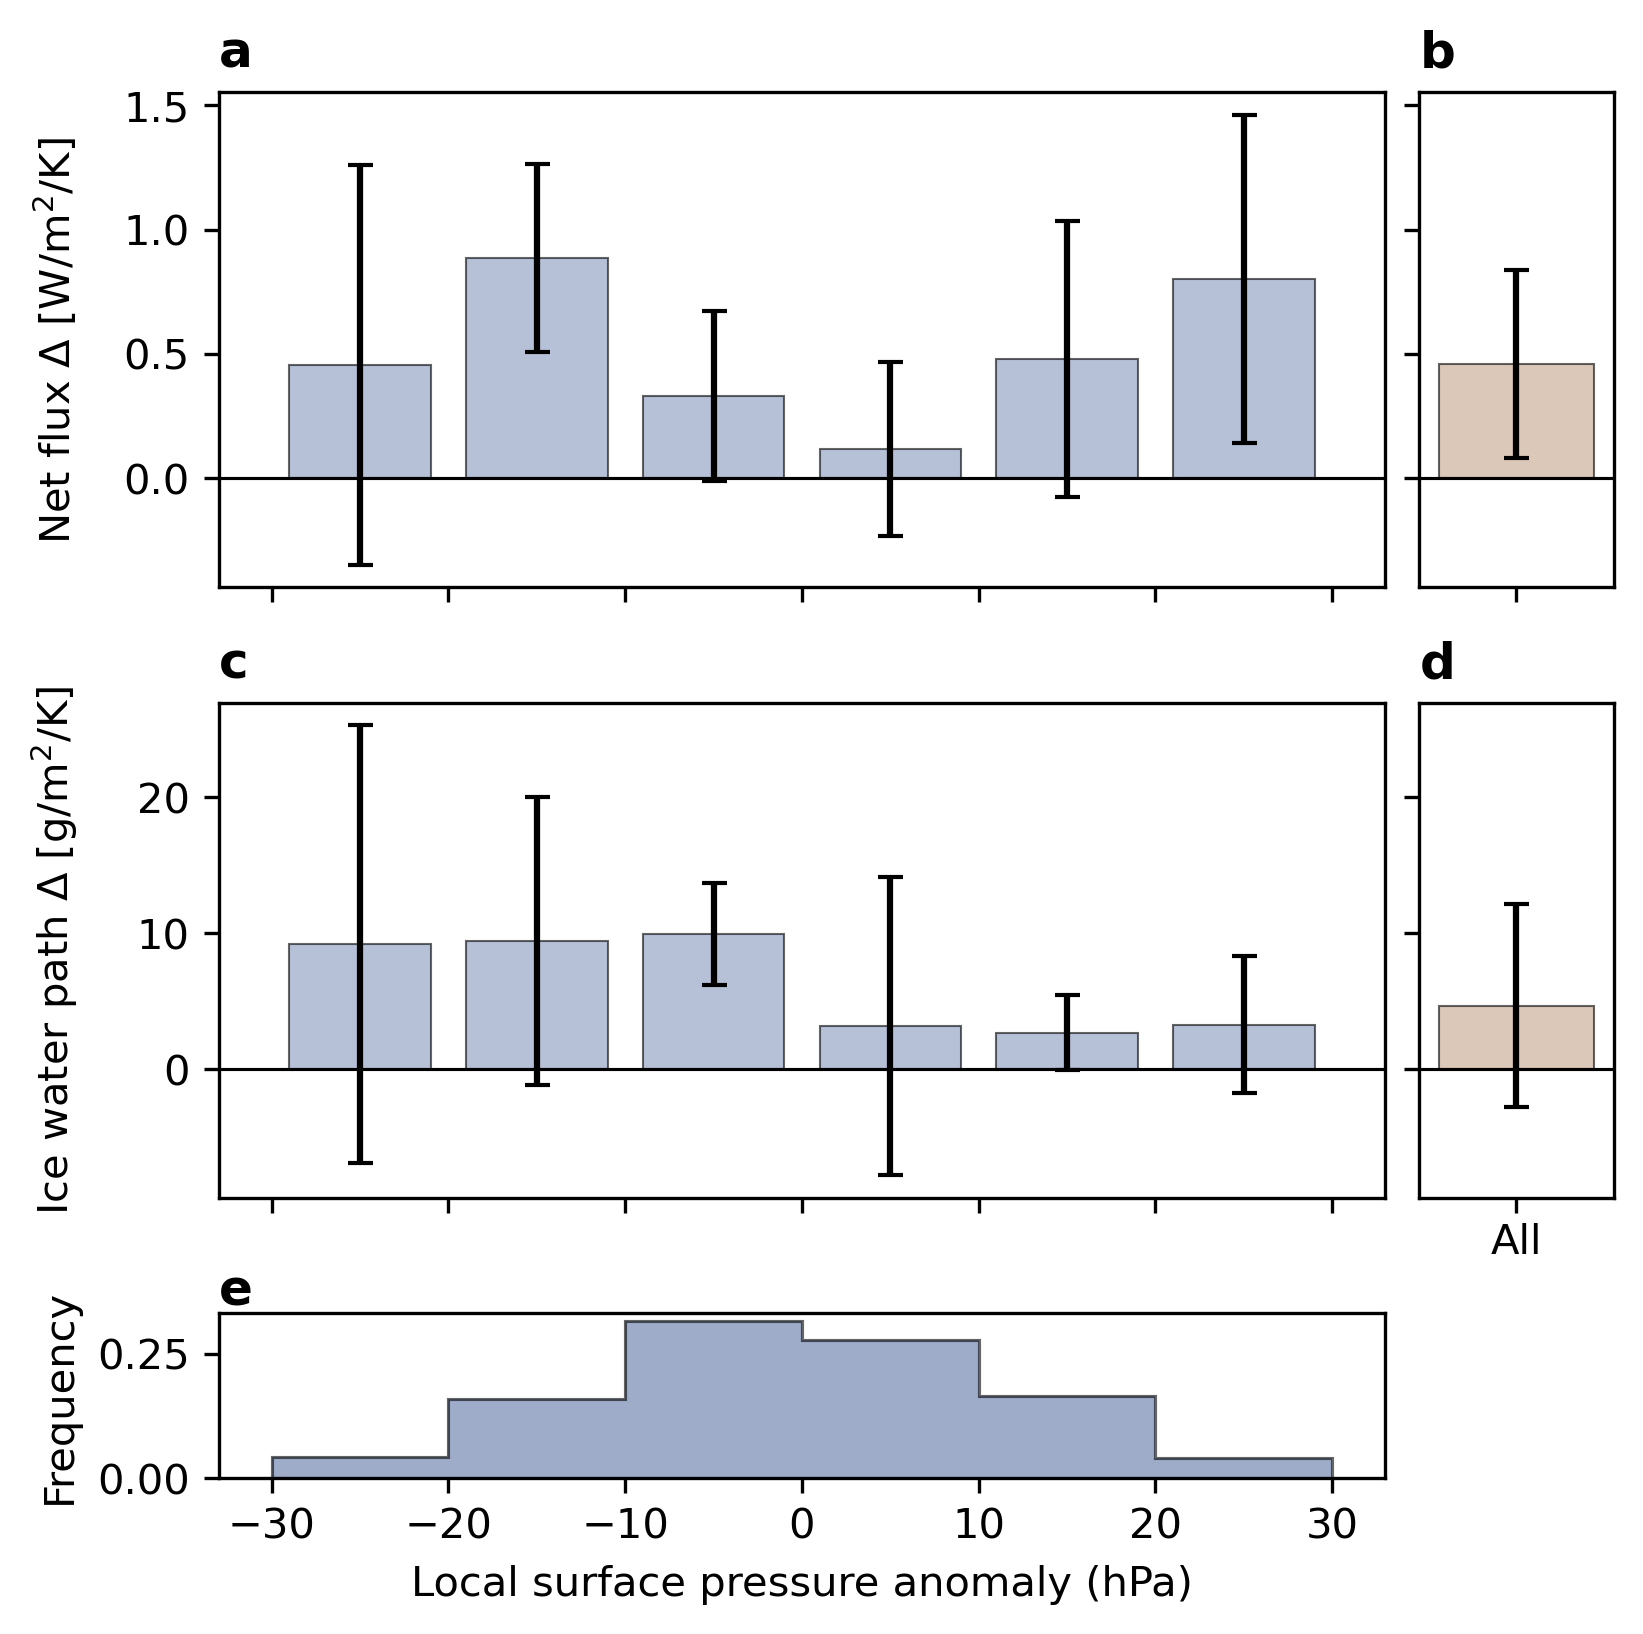

In [64]:
errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
bar_kws      = {'alpha':0.6,'edgecolor':'k','linewidth':0.5}
fig, axes = plt.subplots(3,2,sharex='col',figsize=(6,6),width_ratios=[6,1],height_ratios=[3,3,1],sharey='row',dpi=300)
for i,resp in enumerate([lwn_anom,iwp_anom]):
    #stratified estimate
    ax = axes[i,0]
    reses = gather_strata(resp, tanom, slp)
    slope_lo, slope_hi, slope_med = parse_results(reses,alpha=0.05)
    #  bar
    ax.bar(mids,slope_med,color='#8698BD',width=0.8*dp,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(mids,slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    #crude estimate
    ax = axes[i,1]
    resp = resp.resample(time='MS').mean()
    pred = tanom.resample(time='MS').mean()
    res = do_regression(resp, pred)
    slope_lo, slope_hi, slope_med = parse_results([res])
    if i>0: ax.text(0.5,-0.05,'All',ha='center',va='top',transform=ax.transAxes)
    #  bar
    ax.bar(['Total'],slope_med,color='#C6A48A',width=0.8,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(['Total'],slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    ax.set_xlim(-0.5,0.5)

#histogram
ax = axes[-1,0]
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))
slp_djfm = sub_mos(slp)
counts, _ = np.histogram(slp_djfm,bins=bins)
ax.stairs(counts/np.sum(counts),bins,facecolor='#8698BD',alpha=0.8,fill=True)
ax.stairs(counts/np.sum(counts),bins,color='k',lw=0.75,alpha=0.6)
plt.xlabel('surface pressure [hPa]')
plt.ylabel('days')
axes[2,0].set_xlabel('Local surface pressure anomaly (hPa)')
axes[2,0].set_ylabel('Frequency')
axes[1,0].set_ylabel('Ice water path $\Delta$ [g/m$^2$/K]')
axes[0,0].set_ylabel('Net flux $\Delta$ [W/m$^2$/K]')
axes[2,1].set_visible(False)
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axes.flatten()[:-1]:
    ax.text(0.0,1.05,next(letter),weight='bold',size='large',transform=ax.transAxes)
fig.align_ylabels()
fig.subplots_adjust(wspace=0.05,hspace=0.3)
#fig.savefig('60-stratified_regression_net_flux_and_ice_water_path.pdf',bbox_inches='tight')

## 5.3 Net flux, cloud amount, and ice water path

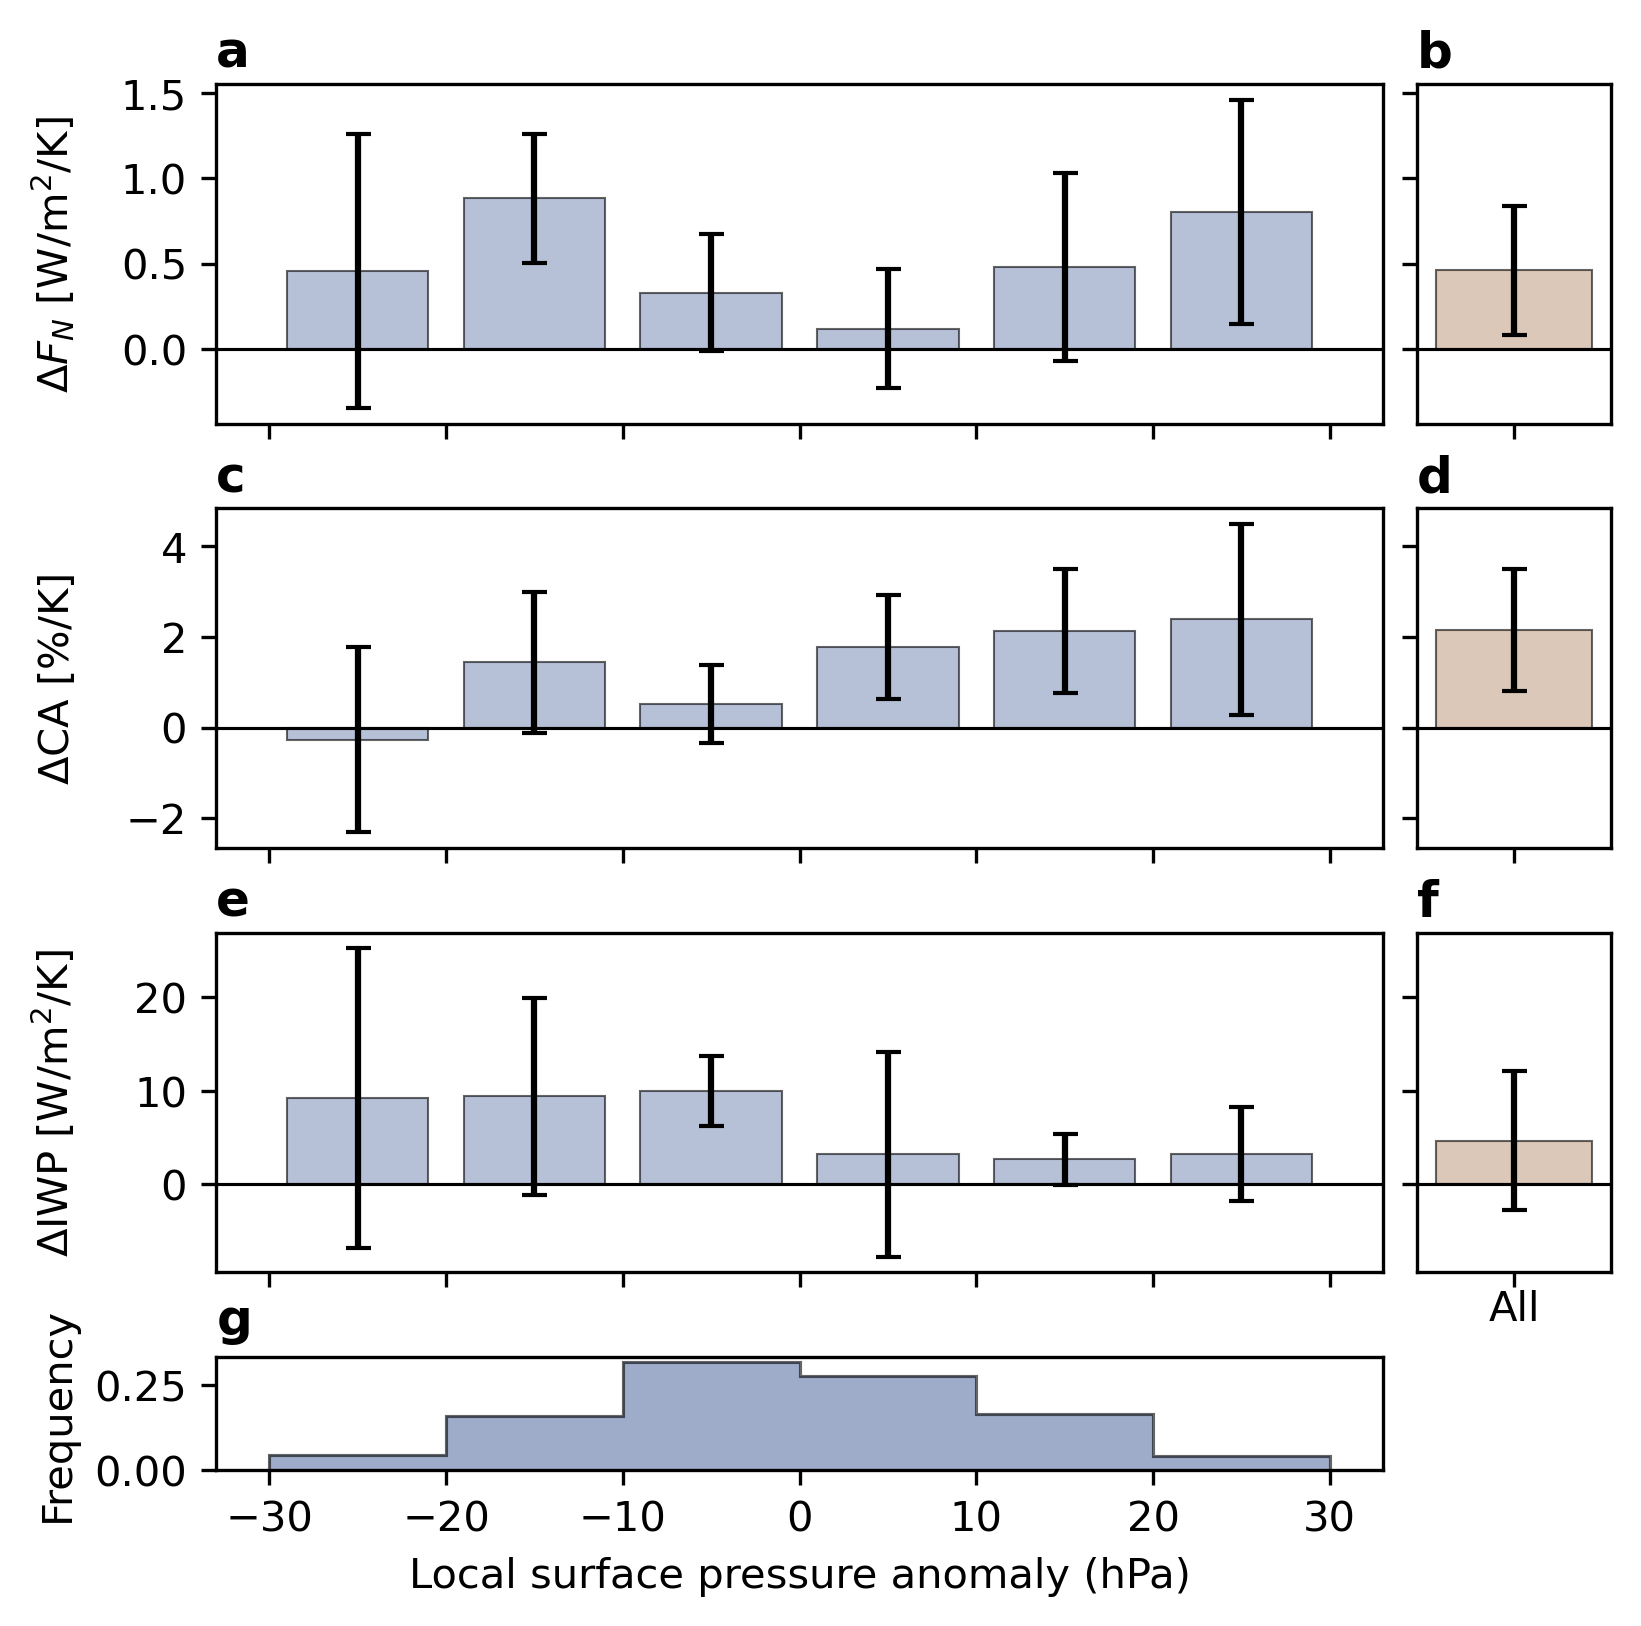

In [65]:
errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
bar_kws      = {'alpha':0.6,'edgecolor':'k','linewidth':0.5}
fig, axes = plt.subplots(4,2,sharex='col',figsize=(6,6),width_ratios=[6,1],height_ratios=[3,3,3,1],sharey='row',dpi=300)
for i,resp in enumerate([lwn_anom,cf_anom,iwp_anom]):
    #stratified estimate
    ax = axes[i,0]
    reses = gather_strata(resp, tanom, slp)
    slope_lo, slope_hi, slope_med = parse_results(reses,alpha=0.05)
    #  bar
    ax.bar(mids,slope_med,color='#8698BD',width=0.8*dp,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(mids,slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    #crude estimate
    ax = axes[i,1]
    resp = resp.resample(time='MS').mean()
    pred = tanom.resample(time='MS').mean()
    res = do_regression(resp, pred)
    slope_lo, slope_hi, slope_med = parse_results([res])
    if i>1: ax.text(0.5,-0.05,'All',ha='center',va='top',transform=ax.transAxes)
    #  bar
    ax.bar(['Total'],slope_med,color='#C6A48A',width=0.8,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(['Total'],slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    ax.set_xlim(-0.5,0.5)

#histogram
ax = axes[-1,0]
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))
slp_djfm = sub_mos(slp)
counts, _ = np.histogram(slp_djfm,bins=bins)
ax.stairs(counts/np.sum(counts),bins,facecolor='#8698BD',alpha=0.8,fill=True)
ax.stairs(counts/np.sum(counts),bins,color='k',lw=0.75,alpha=0.6)
plt.xlabel('surface pressure [hPa]')
plt.ylabel('days')
axes[3,0].set_xlabel('Local surface pressure anomaly (hPa)')
axes[3,0].set_ylabel('Frequency')
axes[2,0].set_ylabel('$\Delta$IWP [W/m$^2$/K]')
axes[1,0].set_ylabel('$\Delta$CA [%/K]')
axes[0,0].set_ylabel('$\Delta F_N$ [W/m$^2$/K]')
axes[3,1].set_visible(False)
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axes.flatten()[:-1]:
    if ax == axes[-1,0]:
        pos = 0.0,1.2
    else:
        pos = 0.0,1.05
    ax.text(*pos,next(letter),weight='bold',size='large',transform=ax.transAxes)
fig.align_ylabels()
fig.subplots_adjust(wspace=0.05,hspace=0.3)
#fig.savefig('60-stratified_regression_net_flux_and_cloud_amount_and_ice_water_path.pdf',bbox_inches='tight')

## 5.4 Net flux, ice water path, liquid water path

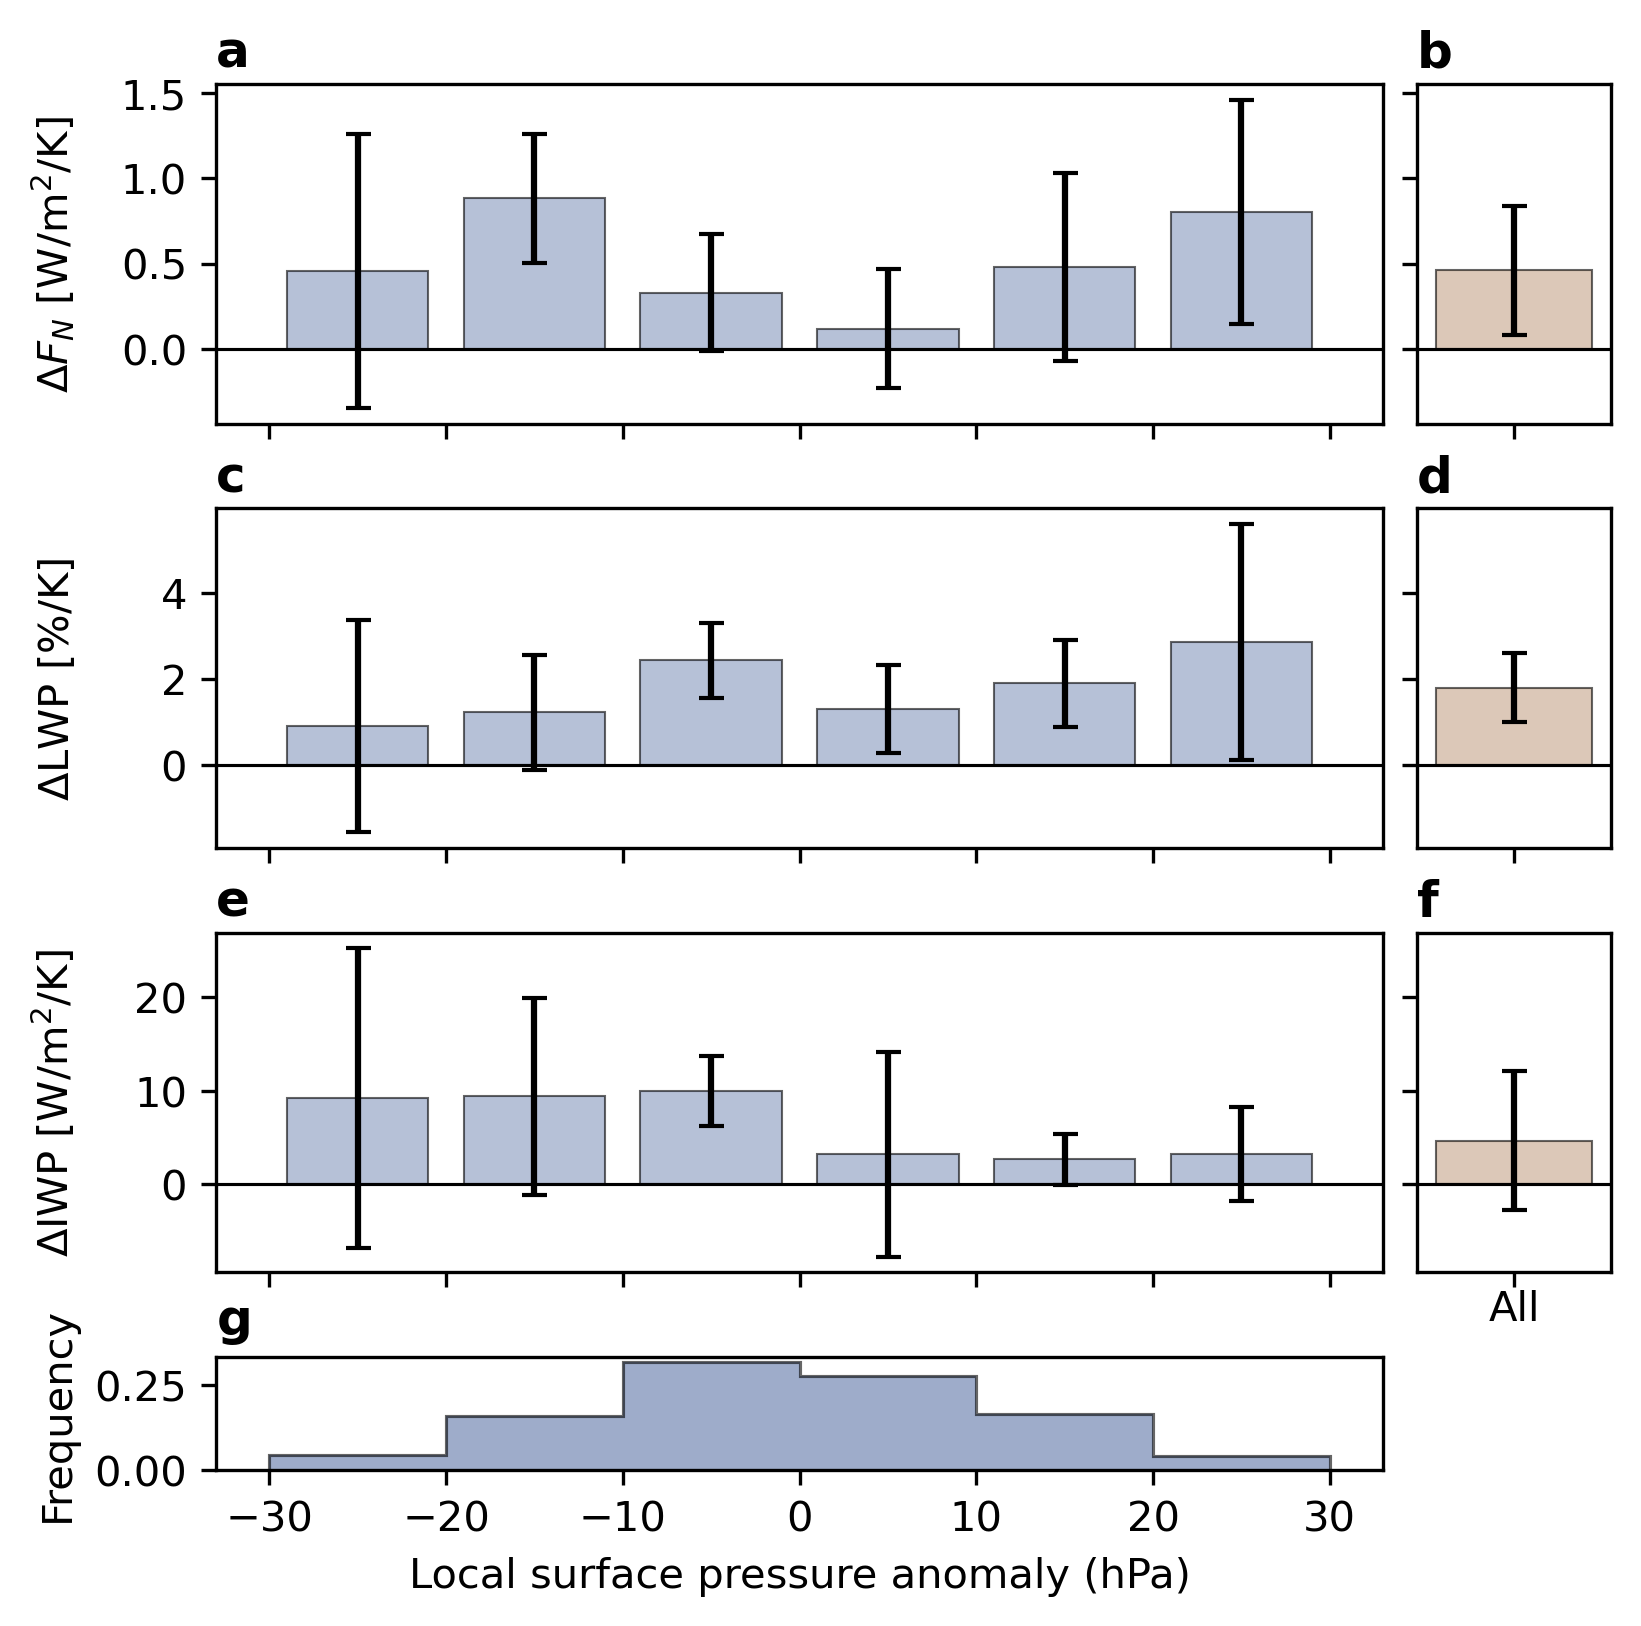

In [66]:
errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
bar_kws      = {'alpha':0.6,'edgecolor':'k','linewidth':0.5}
fig, axes = plt.subplots(4,2,sharex='col',figsize=(6,6),width_ratios=[6,1],height_ratios=[3,3,3,1],sharey='row',dpi=300)
for i,resp in enumerate([lwn_anom,lwp_anom,iwp_anom]):
    #stratified estimate
    ax = axes[i,0]
    reses = gather_strata(resp, tanom, slp)
    slope_lo, slope_hi, slope_med = parse_results(reses,alpha=0.05)
    #  bar
    ax.bar(mids,slope_med,color='#8698BD',width=0.8*dp,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(mids,slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    #crude estimate
    ax = axes[i,1]
    resp = resp.resample(time='MS').mean()
    pred = tanom.resample(time='MS').mean()
    res = do_regression(resp, pred)
    slope_lo, slope_hi, slope_med = parse_results([res])
    if i>1: ax.text(0.5,-0.05,'All',ha='center',va='top',transform=ax.transAxes)
    #  bar
    ax.bar(['Total'],slope_med,color='#C6A48A',width=0.8,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(['Total'],slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    ax.set_xlim(-0.5,0.5)

#histogram
ax = axes[-1,0]
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))
slp_djfm = sub_mos(slp)
counts, _ = np.histogram(slp_djfm,bins=bins)
ax.stairs(counts/np.sum(counts),bins,facecolor='#8698BD',alpha=0.8,fill=True)
ax.stairs(counts/np.sum(counts),bins,color='k',lw=0.75,alpha=0.6)
plt.xlabel('surface pressure [hPa]')
plt.ylabel('days')
axes[3,0].set_xlabel('Local surface pressure anomaly (hPa)')
axes[3,0].set_ylabel('Frequency')
axes[2,0].set_ylabel('$\Delta$IWP [W/m$^2$/K]')
axes[1,0].set_ylabel('$\Delta$LWP [%/K]')
axes[0,0].set_ylabel('$\Delta F_N$ [W/m$^2$/K]')
axes[3,1].set_visible(False)
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axes.flatten()[:-1]:
    if ax == axes[-1,0]:
        pos = 0.0,1.2
    else:
        pos = 0.0,1.05
    ax.text(*pos,next(letter),weight='bold',size='large',transform=ax.transAxes)
fig.align_ylabels()
fig.subplots_adjust(wspace=0.05,hspace=0.3)
#fig.savefig('60-stratified_regression_net_flux_and_liquid_water_path_and_ice_water_path.pdf',bbox_inches='tight')

## 5.5 Net flux, total water path, cloud amount

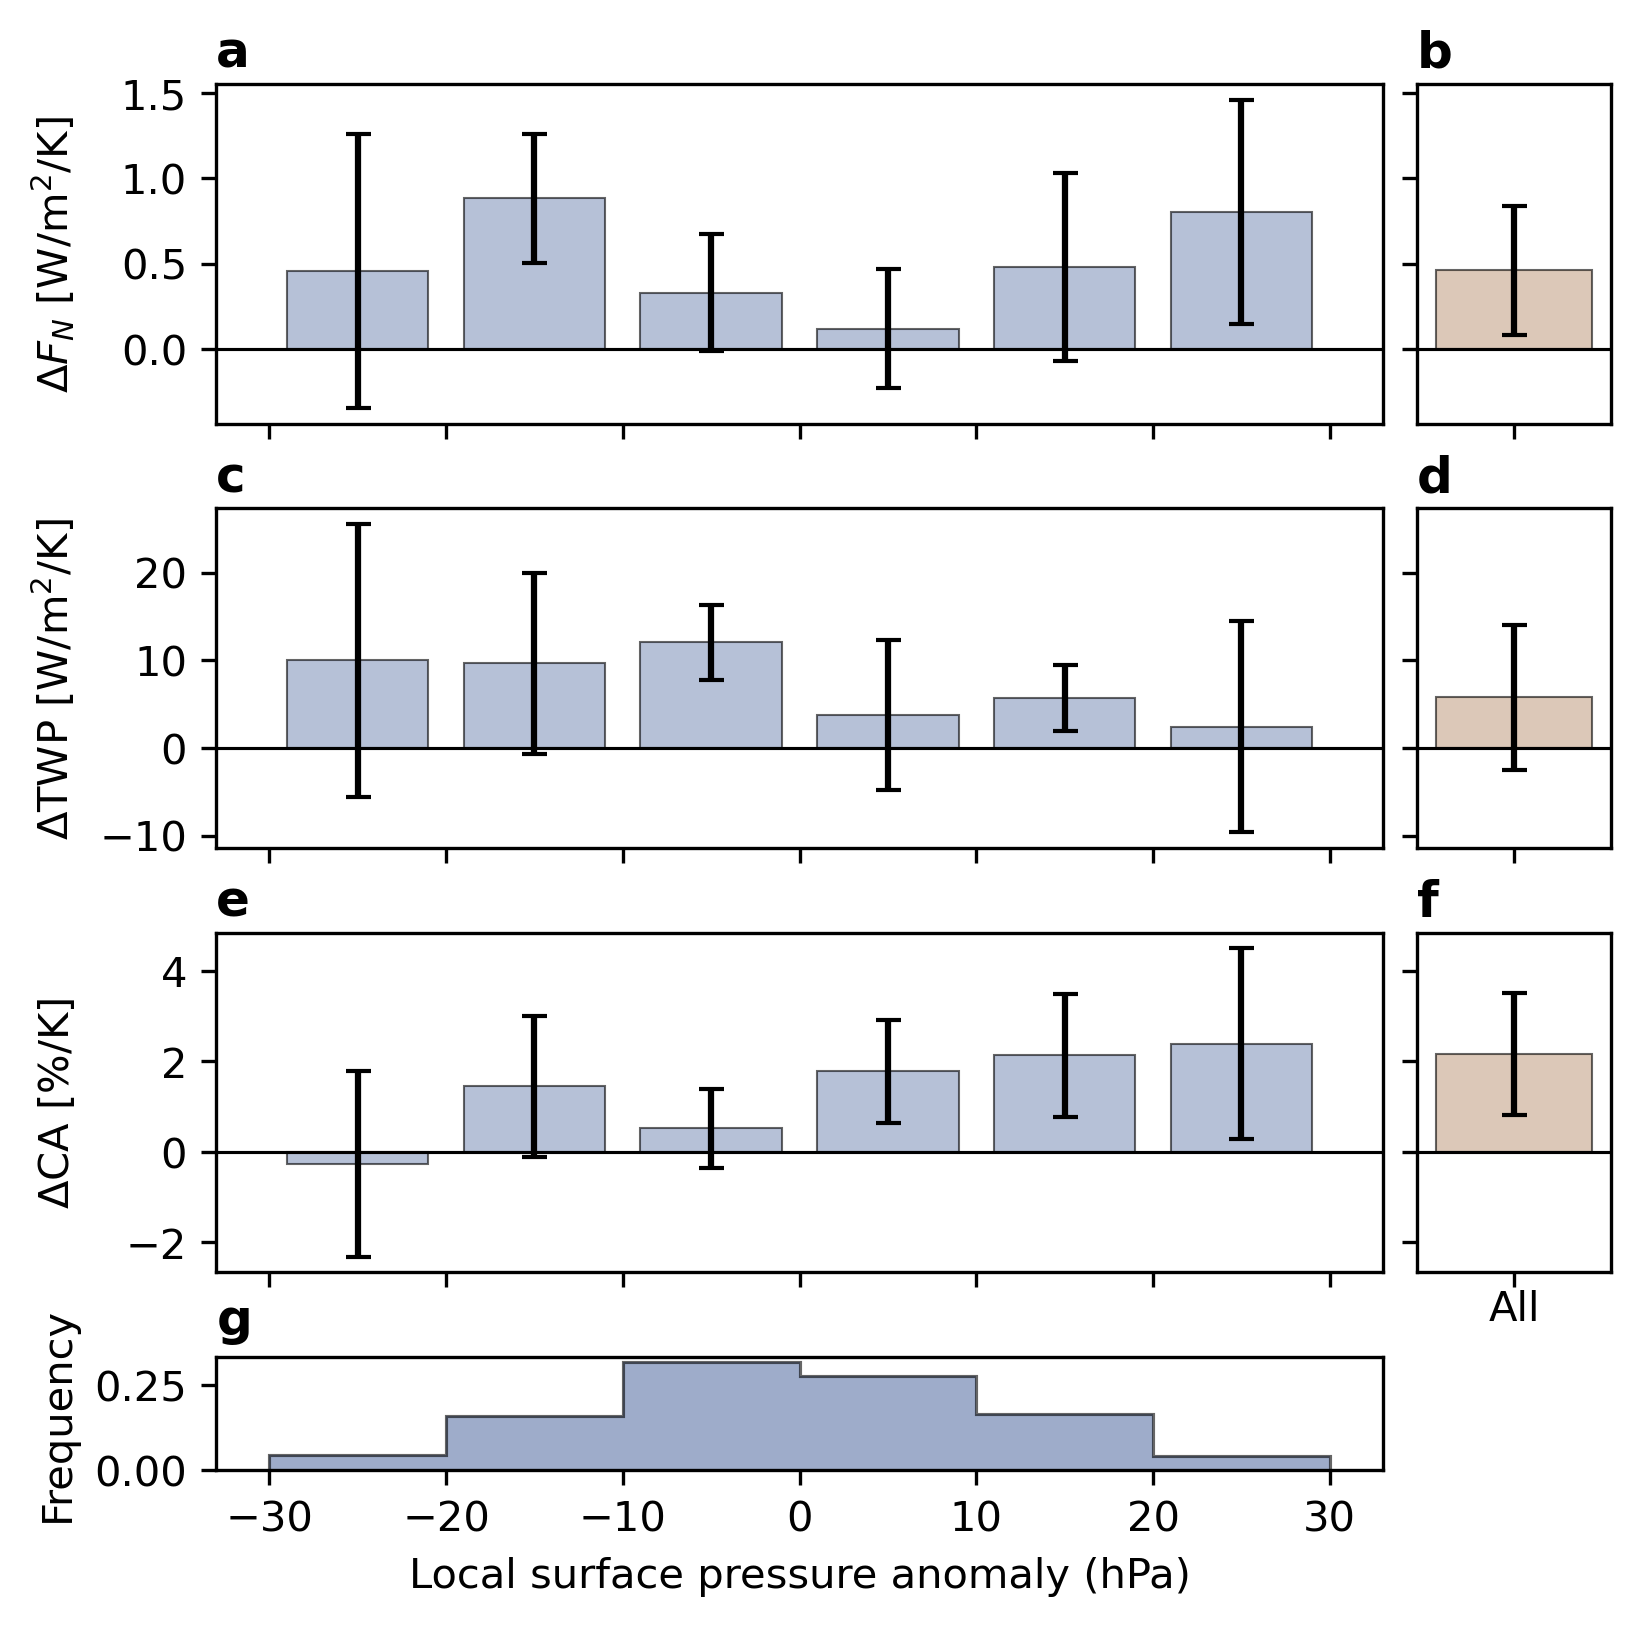

In [67]:
errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
bar_kws      = {'alpha':0.6,'edgecolor':'k','linewidth':0.5}
fig, axes = plt.subplots(4,2,sharex='col',figsize=(6,6),width_ratios=[6,1],height_ratios=[3,3,3,1],sharey='row',dpi=300)
for i,resp in enumerate([lwn_anom,twp_anom,cf_anom]):
    #stratified estimate
    ax = axes[i,0]
    reses = gather_strata(resp, tanom, slp)
    slope_lo, slope_hi, slope_med = parse_results(reses,alpha=0.05)
    #  bar
    ax.bar(mids,slope_med,color='#8698BD',width=0.8*dp,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(mids,slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    #crude estimate
    ax = axes[i,1]
    resp = resp.resample(time='MS').mean()
    pred = tanom.resample(time='MS').mean()
    res = do_regression(resp, pred)
    slope_lo, slope_hi, slope_med = parse_results([res])
    if i>1: ax.text(0.5,-0.05,'All',ha='center',va='top',transform=ax.transAxes)
    #  bar
    ax.bar(['Total'],slope_med,color='#C6A48A',width=0.8,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(['Total'],slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    ax.set_xlim(-0.5,0.5)

#histogram
ax = axes[-1,0]
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))
slp_djfm = sub_mos(slp)
counts, _ = np.histogram(slp_djfm,bins=bins)
ax.stairs(counts/np.sum(counts),bins,facecolor='#8698BD',alpha=0.8,fill=True)
ax.stairs(counts/np.sum(counts),bins,color='k',lw=0.75,alpha=0.6)
plt.xlabel('surface pressure [hPa]')
plt.ylabel('days')
axes[3,0].set_xlabel('Local surface pressure anomaly (hPa)')
axes[3,0].set_ylabel('Frequency')
axes[1,0].set_ylabel('$\Delta$TWP [W/m$^2$/K]')
axes[2,0].set_ylabel('$\Delta$CA [%/K]')
axes[0,0].set_ylabel('$\Delta F_N$ [W/m$^2$/K]')
axes[3,1].set_visible(False)
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axes.flatten()[:-1]:
    if ax == axes[-1,0]:
        pos = 0.0,1.2
    else:
        pos = 0.0,1.05
    ax.text(*pos,next(letter),weight='bold',size='large',transform=ax.transAxes)
fig.align_ylabels()
fig.subplots_adjust(wspace=0.05,hspace=0.3)
#fig.savefig('60-stratified_regression_net_flux_and_total_water_path_and_cloud_amount_nosplit_lwpfilt.pdf',bbox_inches='tight')

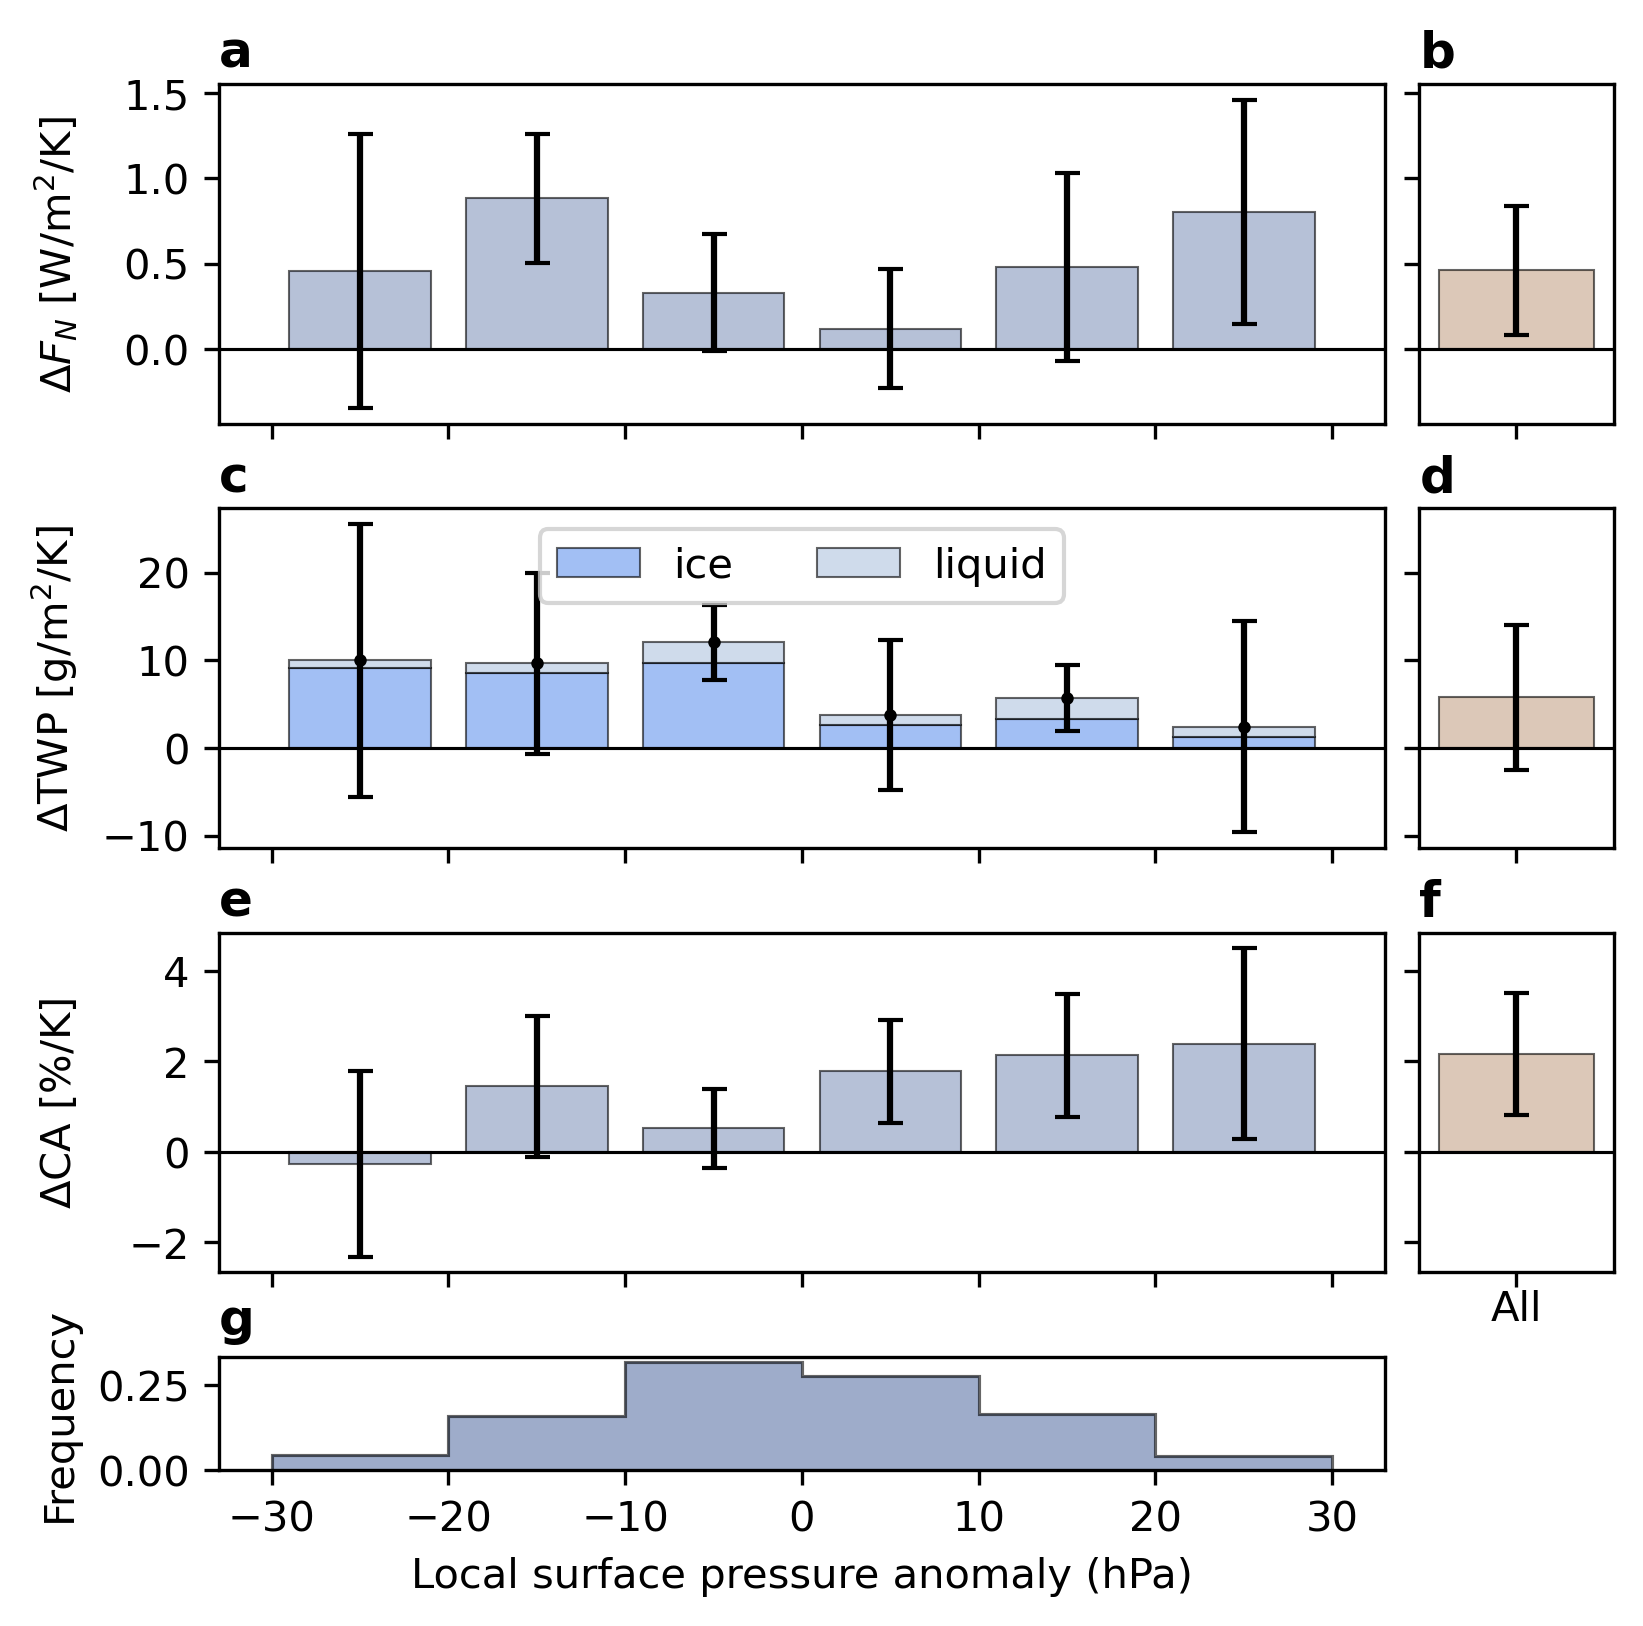

In [68]:
#errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
bar_kws      = {'alpha':0.6,'edgecolor':'k','linewidth':0.5}
fig, axes = plt.subplots(4,2,sharex='col',figsize=(6,6),width_ratios=[6,1],height_ratios=[3,3,3,1],sharey='row',dpi=300)
#clear, ice, mixed, liquid
#colors=iter(['royalblue','cornflowerblue','lightsteelblue','slategray'])
for i,resp in enumerate([lwn_anom,twp_anom,cf_anom]):
    #stratified estimate
    ax = axes[i,0]
    reses = gather_strata(resp, tanom, slp)
    slope_lo, slope_hi, slope_med = parse_results(reses,alpha=0.05)
    if ax==axes[1,0]:
        #  stacked bar
        reses_ice = gather_strata(iwp_anom, tanom, slp)
        reses_liq = gather_strata(lwp_anom, tanom, slp)
        _, _, slope_med_ice = parse_results(reses_ice,alpha=0.05)
        _, _, slope_med_liq = parse_results(reses_liq,alpha=0.05)
        scaling = slope_med/(slope_med_ice+slope_med_liq)
        slope_med_ice = slope_med_ice*scaling
        slope_med_liq = slope_med_liq*scaling
        errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
        ax.bar(mids,slope_med_ice,color='cornflowerblue',width=0.8*dp,label='ice',**bar_kws)
        ax.bar(mids,slope_med_liq,bottom=slope_med_ice,color='lightsteelblue',width=0.8*dp,label='liquid',**bar_kws)
    else:
        errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
        #  bar
        ax.bar(mids,slope_med,color='#8698BD',width=0.8*dp,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(mids,slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    #crude estimate
    ax = axes[i,1]
    resp = resp.resample(time='MS').mean()
    pred = tanom.resample(time='MS').mean()
    res = do_regression(resp, pred)
    slope_lo, slope_hi, slope_med = parse_results([res])
    if i>1: ax.text(0.5,-0.05,'All',ha='center',va='top',transform=ax.transAxes)
    #  bar
    ax.bar(['Total'],slope_med,color='#C6A48A',width=0.8,**bar_kws)
    #  errorbar
    errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(['Total'],slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    ax.set_xlim(-0.5,0.5)

#histogram
ax = axes[-1,0]
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))
slp_djfm = sub_mos(slp)
counts, _ = np.histogram(slp_djfm,bins=bins)
ax.stairs(counts/np.sum(counts),bins,facecolor='#8698BD',alpha=0.8,fill=True)
ax.stairs(counts/np.sum(counts),bins,color='k',lw=0.75,alpha=0.6)
plt.xlabel('surface pressure [hPa]')
plt.ylabel('days')
axes[3,0].set_xlabel('Local surface pressure anomaly (hPa)')
axes[3,0].set_ylabel('Frequency')
axes[1,0].set_ylabel('$\Delta$TWP [g/m$^2$/K]')
axes[1,0].legend(loc='upper center',ncols=2)
axes[2,0].set_ylabel('$\Delta$CA [%/K]')
axes[0,0].set_ylabel('$\Delta F_N$ [W/m$^2$/K]')
axes[3,1].set_visible(False)
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axes.flatten()[:-1]:
    if ax == axes[-1,0]:
        pos = 0.0,1.2
    else:
        pos = 0.0,1.05
    ax.text(*pos,next(letter),weight='bold',size='large',transform=ax.transAxes)
fig.align_ylabels()
fig.subplots_adjust(wspace=0.05,hspace=0.3)
#fig.savefig('60-stratified_regression_net_flux_and_total_water_path_and_cloud_amount_split.pdf',bbox_inches='tight')

## 5.6 Net flux, total water path

(-11.403857367007497, 27.328292696850514)


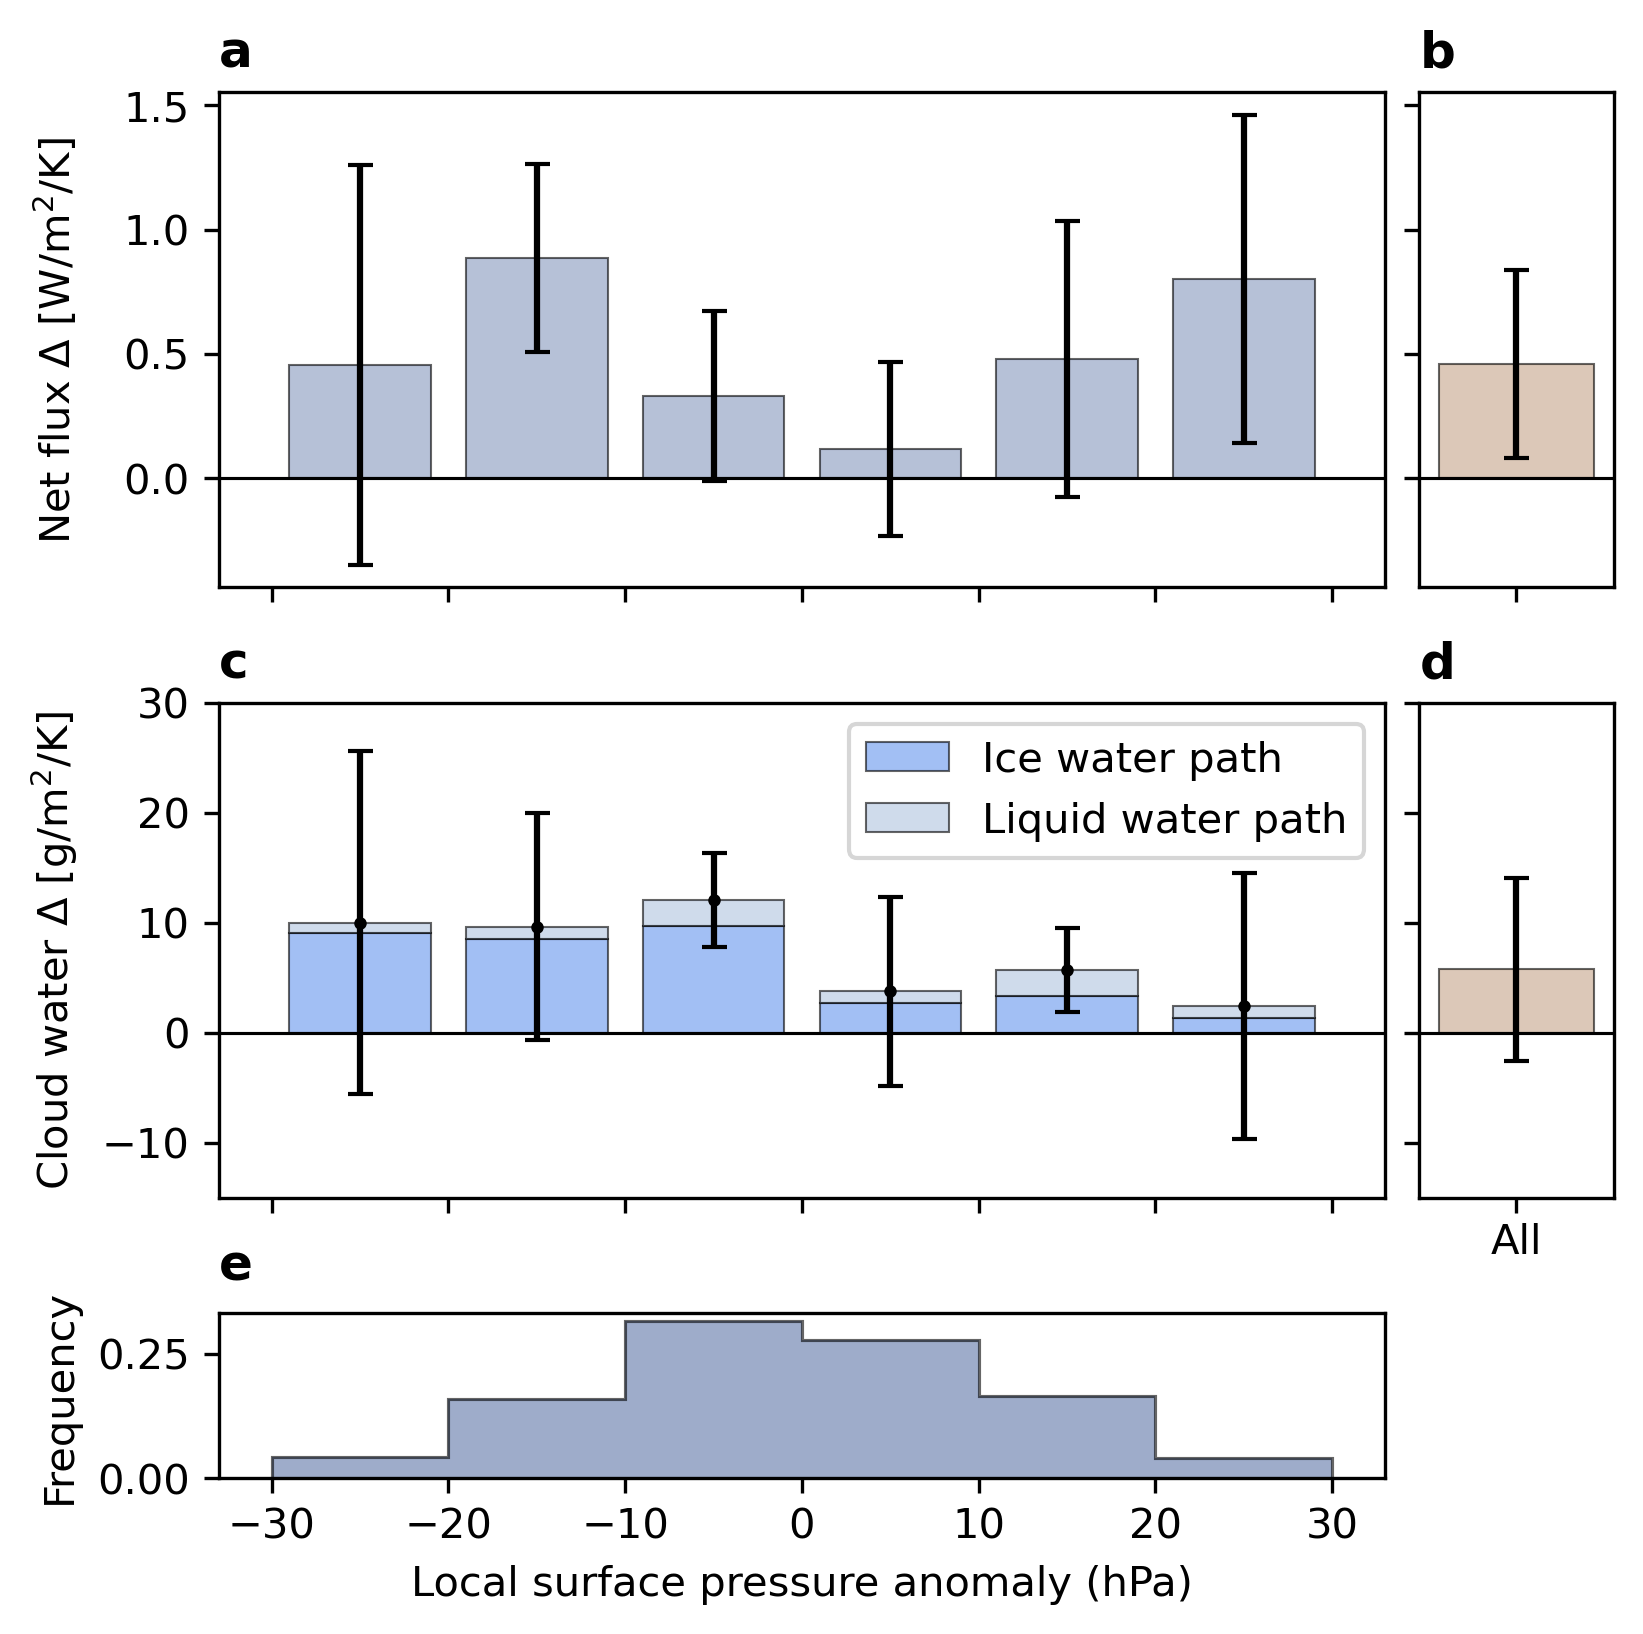

In [69]:
#errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
bar_kws      = {'alpha':0.6,'edgecolor':'k','linewidth':0.5}
fig, axes = plt.subplots(3,2,sharex='col',figsize=(6,6),width_ratios=[6,1],height_ratios=[3,3,1],sharey='row',dpi=300)
#clear, ice, mixed, liquid
#colors=iter(['royalblue','cornflowerblue','lightsteelblue','slategray'])
for i,resp in enumerate([lwn_anom,twp_anom]):
    #stratified estimate
    ax = axes[i,0]
    reses = gather_strata(resp, tanom, slp)
    slope_lo, slope_hi, slope_med = parse_results(reses,alpha=0.05)
    if ax==axes[1,0]:
        #  stacked bar
        reses_ice = gather_strata(iwp_anom, tanom, slp)
        reses_liq = gather_strata(lwp_anom, tanom, slp)
        _, _, slope_med_ice = parse_results(reses_ice,alpha=0.05)
        _, _, slope_med_liq = parse_results(reses_liq,alpha=0.05)
        scaling = slope_med/(slope_med_ice+slope_med_liq)
        slope_med_ice = slope_med_ice*scaling
        slope_med_liq = slope_med_liq*scaling
        errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
        ax.bar(mids,slope_med_ice,color='cornflowerblue',width=0.8*dp,label='Ice water path',**bar_kws)
        ax.bar(mids,slope_med_liq,bottom=slope_med_ice,color='lightsteelblue',width=0.8*dp,label='Liquid water path',**bar_kws)
    else:
        errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
        #  bar
        ax.bar(mids,slope_med,color='#8698BD',width=0.8*dp,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(mids,slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    #crude estimate
    ax = axes[i,1]
    resp = resp.resample(time='MS').mean()
    pred = tanom.resample(time='MS').mean()
    res = do_regression(resp, pred)
    slope_lo, slope_hi, slope_med = parse_results([res])
    if i>0: ax.text(0.5,-0.05,'All',ha='center',va='top',transform=ax.transAxes)
    #  bar
    ax.bar(['Total'],slope_med,color='#C6A48A',width=0.8,**bar_kws)
    #  errorbar
    errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(['Total'],slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    ax.set_xlim(-0.5,0.5)

#histogram
ax = axes[-1,0]
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))
slp_djfm = sub_mos(slp)
counts, _ = np.histogram(slp_djfm,bins=bins)
ax.stairs(counts/np.sum(counts),bins,facecolor='#8698BD',alpha=0.8,fill=True)
ax.stairs(counts/np.sum(counts),bins,color='k',lw=0.75,alpha=0.6)
plt.xlabel('surface pressure [hPa]')
plt.ylabel('days')
axes[2,0].set_xlabel('Local surface pressure anomaly (hPa)')
axes[2,0].set_ylabel('Frequency')
axes[1,0].set_ylabel('Cloud water $\Delta$ [g/m$^2$/K]')
axes[1,0].legend(loc='upper right',ncols=1)#,bbox_to_anchor=(0.565,1.0),columnspacing=1.5)
print(axes[1,0].get_ylim())
axes[1,0].set_ylim(-15,30)
axes[0,0].set_ylabel('Net flux $\Delta$ [W/m$^2$/K]')
axes[2,1].set_visible(False)
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axes.flatten()[:-1]:
    if ax == axes[-1,0]:
        pos = 0.0,1.2
    else:
        pos = 0.0,1.05
    ax.text(*pos,next(letter),weight='bold',size='large',transform=ax.transAxes)
fig.align_ylabels()
fig.subplots_adjust(wspace=0.05,hspace=0.3)
#fig.savefig('67-stratified_regression_net_flux_and_total_water_path_nothresh.pdf',bbox_inches='tight')

In [70]:
counts, _ = np.histogram(slp_djfm,bins=bins)
print(f'95% confidence: {np.sum(counts[[1,2,4]])/np.sum(counts):%} of obs')
print(f'90% confidence: {np.sum(counts[[1,2,4,5]])/np.sum(counts):%} of obs')

95% confidence: 63.859885% of obs
90% confidence: 67.935332% of obs


In [71]:
np.sum(counts[[1,2,5]])/np.sum(counts)

0.5146513977770293

(-11.403857367007497, 27.328292696850514)


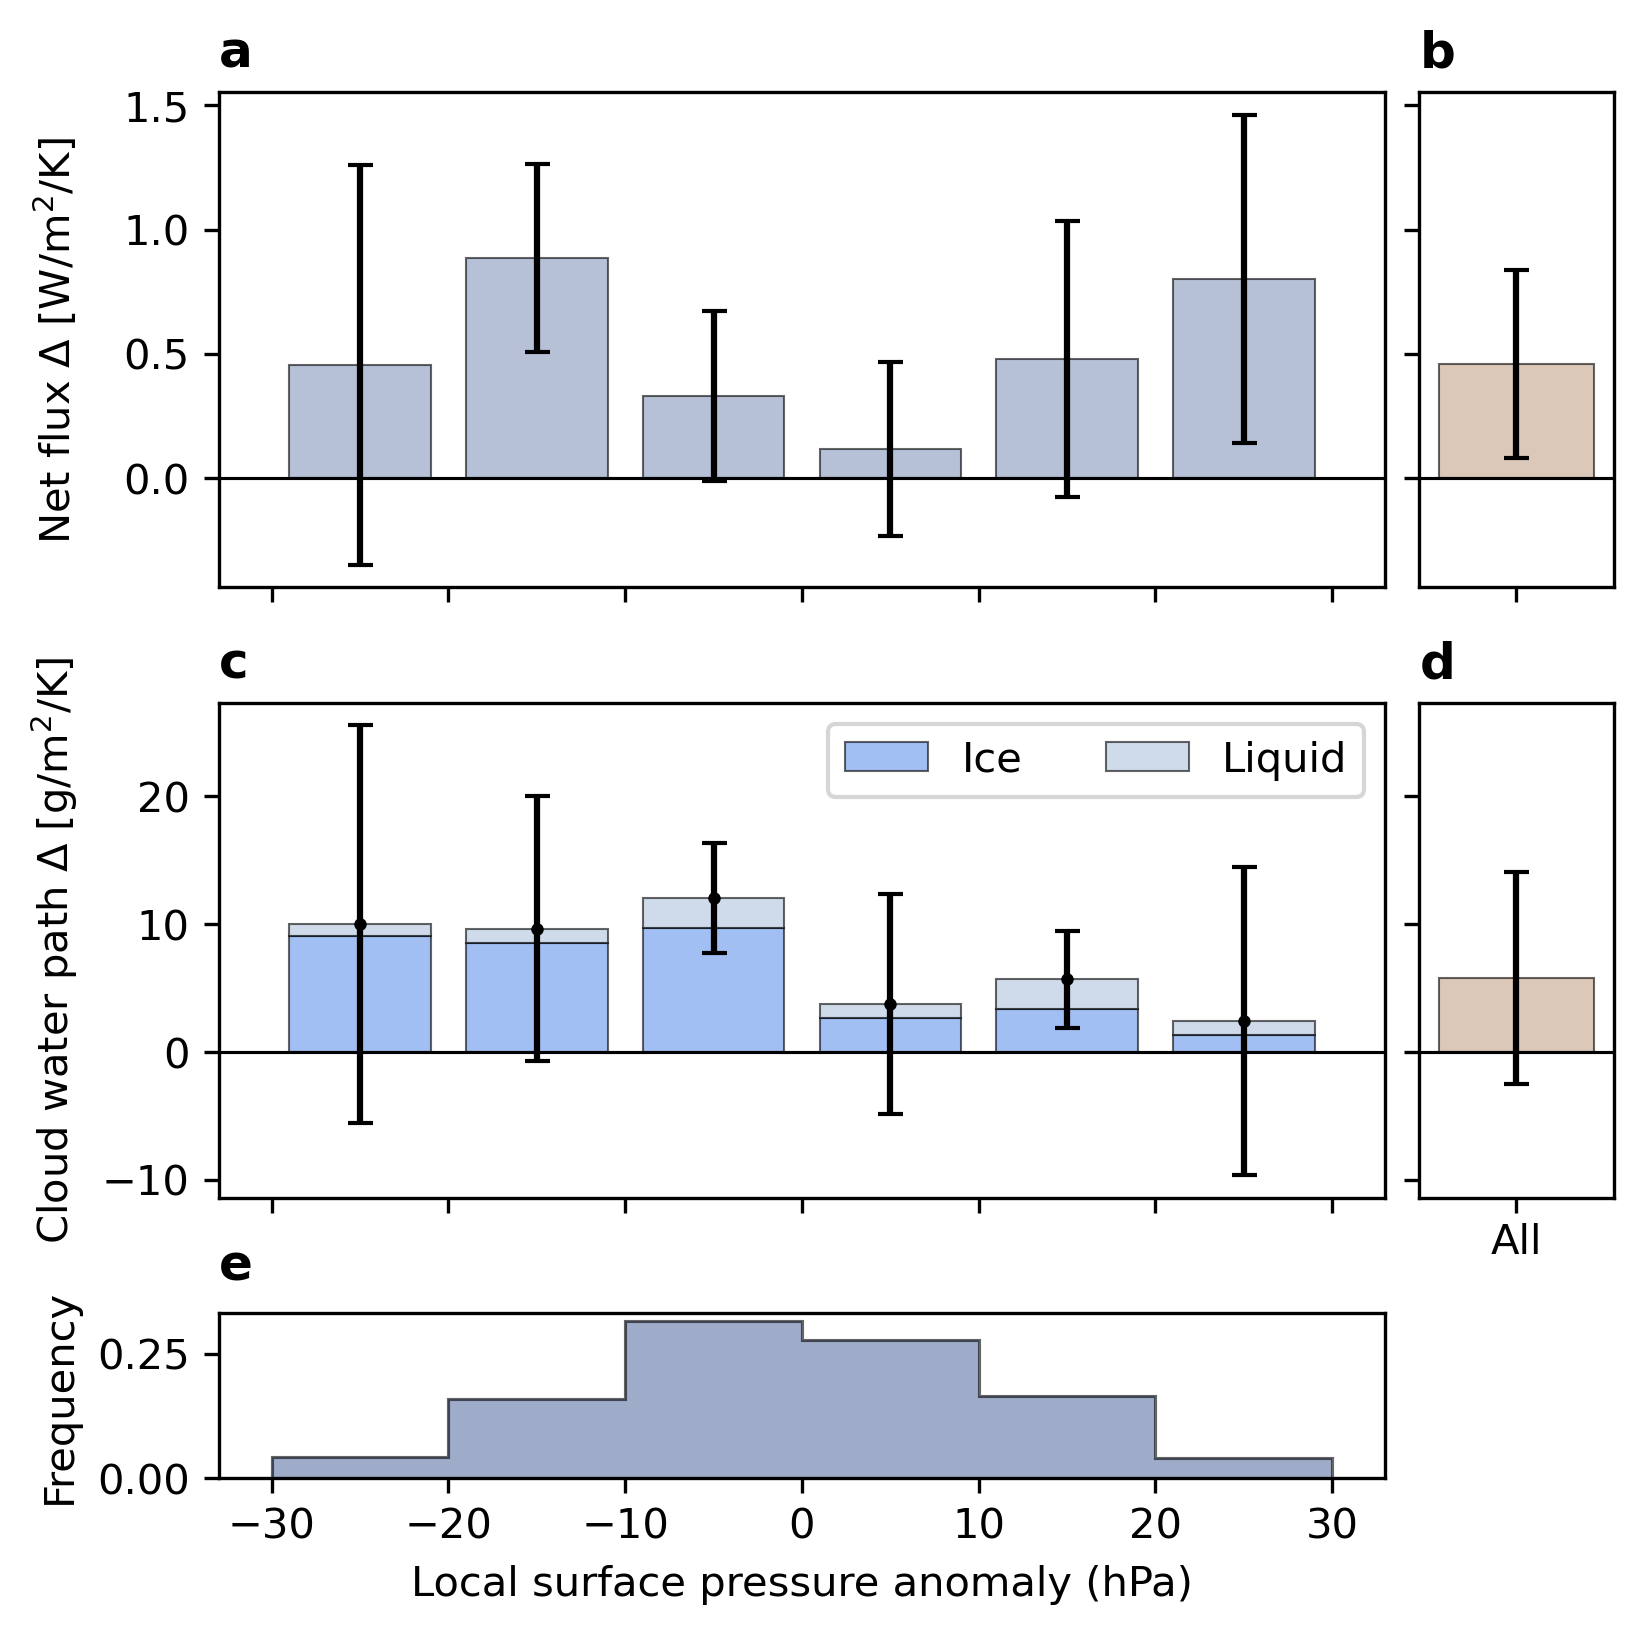

In [72]:
#errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
bar_kws      = {'alpha':0.6,'edgecolor':'k','linewidth':0.5}
fig, axes = plt.subplots(3,2,sharex='col',figsize=(6,6),width_ratios=[6,1],height_ratios=[3,3,1],sharey='row',dpi=300)
#clear, ice, mixed, liquid
#colors=iter(['royalblue','cornflowerblue','lightsteelblue','slategray'])
for i,resp in enumerate([lwn_anom,twp_anom]):
    #stratified estimate
    ax = axes[i,0]
    reses = gather_strata(resp, tanom, slp)
    slope_lo, slope_hi, slope_med = parse_results(reses,alpha=0.05)
    if ax==axes[1,0]:
        #  stacked bar
        reses_ice = gather_strata(iwp_anom, tanom, slp)
        reses_liq = gather_strata(lwp_anom, tanom, slp)
        _, _, slope_med_ice = parse_results(reses_ice,alpha=0.05)
        _, _, slope_med_liq = parse_results(reses_liq,alpha=0.05)
        scaling = slope_med/(slope_med_ice+slope_med_liq)
        slope_med_ice = slope_med_ice*scaling
        slope_med_liq = slope_med_liq*scaling
        errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
        ax.bar(mids,slope_med_ice,color='cornflowerblue',width=0.8*dp,label='Ice',**bar_kws)
        ax.bar(mids,slope_med_liq,bottom=slope_med_ice,color='lightsteelblue',width=0.8*dp,label='Liquid',**bar_kws)
    else:
        errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
        #  bar
        ax.bar(mids,slope_med,color='#8698BD',width=0.8*dp,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(mids,slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    #crude estimate
    ax = axes[i,1]
    resp = resp.resample(time='MS').mean()
    pred = tanom.resample(time='MS').mean()
    res = do_regression(resp, pred)
    slope_lo, slope_hi, slope_med = parse_results([res])
    if i>0: ax.text(0.5,-0.05,'All',ha='center',va='top',transform=ax.transAxes)
    #  bar
    ax.bar(['Total'],slope_med,color='#C6A48A',width=0.8,**bar_kws)
    #  errorbar
    errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(['Total'],slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    ax.set_xlim(-0.5,0.5)

#histogram
ax = axes[-1,0]
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))
slp_djfm = sub_mos(slp)
counts, _ = np.histogram(slp_djfm,bins=bins)
ax.stairs(counts/np.sum(counts),bins,facecolor='#8698BD',alpha=0.8,fill=True)
ax.stairs(counts/np.sum(counts),bins,color='k',lw=0.75,alpha=0.6)
plt.xlabel('surface pressure [hPa]')
plt.ylabel('days')
axes[2,0].set_xlabel('Local surface pressure anomaly (hPa)')
axes[2,0].set_ylabel('Frequency')
axes[1,0].set_ylabel('Cloud water path $\Delta$ [g/m$^2$/K]')
axes[1,0].legend(loc='upper right',ncols=2)#,bbox_to_anchor=(0.565,1.0),columnspacing=1.5)
print(axes[1,0].get_ylim())
#axes[1,0].set_ylim(-0.7575774160469368,7.99)
axes[0,0].set_ylabel('Net flux $\Delta$ [W/m$^2$/K]')
axes[2,1].set_visible(False)
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axes.flatten()[:-1]:
    if ax == axes[-1,0]:
        pos = 0.0,1.2
    else:
        pos = 0.0,1.05
    ax.text(*pos,next(letter),weight='bold',size='large',transform=ax.transAxes)
fig.align_ylabels()
fig.subplots_adjust(wspace=0.05,hspace=0.3)
#fig.savefig('60-stratified_regression_net_flux_and_total_water_path_split.pdf',bbox_inches='tight')

# 6. ERA advection circulation influence

In [74]:
declim = lambda ds: ds.groupby('time.month') - ds.groupby('time.month').mean()

dp = 10 #hPa
#bins = np.arange(slp.min(),slp.mean()-dp/2,dp)
#bins = np.concatenate([bins,np.arange(slp.mean()+dp/2,slp.max(),dp)])
bins = np.arange(0,20,4)
mids = 0.5*(bins[1:]+bins[:-1])

#prep met
tanom  = sub_mos(declim(load_arm_temp()))
slp    = sub_mos(declim(pres))
ds_era = xr.open_dataset(folder/'ipynb_processed'/'68-nsaecmwften_merged.nc')
dT     = np.sqrt((ds_era['T_total']*24*60*60)**2)
dT     = dT.isel(pres=slice(0,4)).mean('pres')
dT     = sub_mos(dT).resample(time='D').mean()

#load cloud props
folder = Path('~/Documents/arm_data/ipynb_processed').expanduser()
fps = sorted(Path(folder/'28-microshupeturn-columnint-minutely-by-year').glob('*.nc'))
ds = xr.open_mfdataset(fps)
iwp   = ds.iwp.compute()#get_split_iwp(add_type_dim=False)['iwp'] #don't consider IWP>thresh (200 g/m2)
lwp   = ds.lwp.compute()
twp   = iwp+lwp
cf    = ds.tot_cld.compute()

In [75]:
#load phase classification
def bit_packed_to_broad_categories(phases):
    '''convert bit-packed phase mask to bool for a group of bits'''
    
    #define phase categories via the flag values satisifying each category
    cloud_liquid = [3,5]              #liquid, liquid+drizzle
    cloud_mixed  = [7]                #mixed-phase
    cloud_ice    = [1,2]              #ice, snow
    phase_vars   = {'liquid': cloud_liquid,
                    'mixed': cloud_mixed,
                    'ice': cloud_ice}
    
    #get profiles satisfying broad categories specified in phase_vars
    phase_res = { }
    for name,flags in phase_vars.items():
        #convert list of flag values to int with bits on for flag values
        flag_map = bitlist_to_int(flags)
        #check if at least one of the flag values is present in profile
        flag_res = (phases&flag_map) > 0
        phase_res[name] = flag_res

    #exclude liquid-containing profiles as ice
    phase_res['ice'] = phase_res['ice'] & ~(phase_res['mixed'] | phase_res['liquid'])

    #exclude mixed-containing profiles as liquid
    phase_res['liquid'] = phase_res['liquid'] & ~phase_res['mixed']

    #return as dataset
    return xr.Dataset(phase_res)

#load column-integrated phases and convert to broad categories
folder = Path('~/Documents/arm_data/').expanduser()
fps = sorted((folder/'ipynb_processed'/'28-microshupeturn-columnint-minutely-by-year').glob('*.nc'))
st_prof  = xr.open_mfdataset(fps)
is_phase = st_prof.phase.compute().astype(int)
is_phase = bit_packed_to_broad_categories(is_phase)
residual = (st_prof.tot_cld>0) & ~(is_phase['liquid'] | is_phase['mixed'] | is_phase['ice'])
clear    = st_prof.tot_cld==0
is_phase = is_phase.assign({'clear':clear,'other':residual})
is_phase = is_phase.assign(all=xr.ones_like(is_phase['liquid']))
is_phase = is_phase.compute()
for name,total in is_phase.sum('time').items():
    if total == 0:
        print(f'dropping category "{name}" because it contains no observations')
        is_phase = is_phase.drop(name)
#apply layer-based screening of liquid-only cases
fps = sorted((folder/'ipynb_processed'/'59-betterliquidonly-columnint-minutely-by-year').glob('*.nc'))
is_liquid = xr.open_mfdataset(fps).compute()
is_phase['mixed']  = is_phase['mixed']  | is_liquid['liquid_snowing']
is_phase['liquid'] = is_phase['liquid'] & is_liquid['liquid_nosnow']

dropping category "other" because it contains no observations


In [76]:
#load surface longwave flux at high temporal frequency
ds_flux = xr.open_dataset(folder/'ipynb_processed'/'47-qcrad_lwflux_minutely_DJFM.nc')
lwn = ds_flux['net_long_hemisp']

In [77]:
%%time
#enforce phase-condensate consistency
iwp = iwp.where(is_phase['ice'] | is_phase['mixed'])
lwp = lwp.where(is_phase['mixed'] | is_phase['liquid'])
twp = twp.where(cf>0)

#daily frequency
lwn_d = sub_mos(lwn).resample(time='D',label='left').mean()
lwn_anom = declim(lwn_d)
iwp_d = sub_mos(iwp).resample(time='D',label='left').mean()
iwp_anom = declim(iwp_d)
lwp_d = sub_mos(lwp).resample(time='D',label='left').mean()
lwp_anom = declim(lwp_d)
twp_d = sub_mos(twp).resample(time='D',label='left').mean()
twp_anom = declim(twp_d)
cf_d = sub_mos(cf).resample(time='D',label='left').mean()
cf_anom = declim(cf_d)
tanom = sub_mos(tanom).resample(time='D',label='left').mean()

#align
iwp_anom, lwp_anom, twp_anom, cf_anom, lwn_anom, tanom, dT = xr.align(
    iwp_anom, lwp_anom, twp_anom, cf_anom, lwn_anom, tanom, dT, join='outer')
cf_anom = 100*cf_anom

#sanity check lwp
lwp_anom.sel(time=lwp_anom>200)

CPU times: user 4.87 s, sys: 858 ms, total: 5.73 s
Wall time: 5.07 s


<xarray.DataArray 'lwp' (time: 4)>
array([534.0836 , 500.4448 , 354.18262, 270.43253], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-07 2017-01-08 2017-01-09 2017-01-11
    month    (time) float64 1.0 1.0 1.0 1.0

In [79]:
def do_regression(resp_mos,tanom_mos):
    Y, X = xr.align(resp_mos.dropna('time'),tanom_mos.dropna('time'))
    Y, X = Y.data, X.data
    X = sm.add_constant(X)
    olsr_djfm_res = sm.OLS(Y,X, missing='drop').fit()
    return olsr_djfm_res

def gather_strata(resp,tanom,slp):
    reses = [ ]
    for pi,pf in zip(bins[:-1],bins[1:]):
        msk = (pi<=slp) & (slp<pf)
        resp_sub  = resp.sel(time=msk)
        tanom_sub = tanom.sel(time=msk)
        resp_mos  = resp_sub.resample(time='MS').mean()
        tanom_mos = tanom_sub.resample(time='MS').mean()
        olsr_djfm_res = do_regression(resp_mos,tanom_mos)
        reses.append(olsr_djfm_res)
    return reses

def parse_results(reses,alpha=0.05):
    slope_lo, slope_hi, slope_med = [], [], []
    for res in reses:
        slope_lo.append(res.conf_int(alpha)[1,0])
        slope_hi.append(res.conf_int(alpha)[1,1])
        slope_med.append(res.params[1])
    return np.array(slope_lo), np.array(slope_hi), np.array(slope_med)

In [80]:
bins

array([ 0,  4,  8, 12, 16])

(-6.678851363599359, 55.16637053165411)


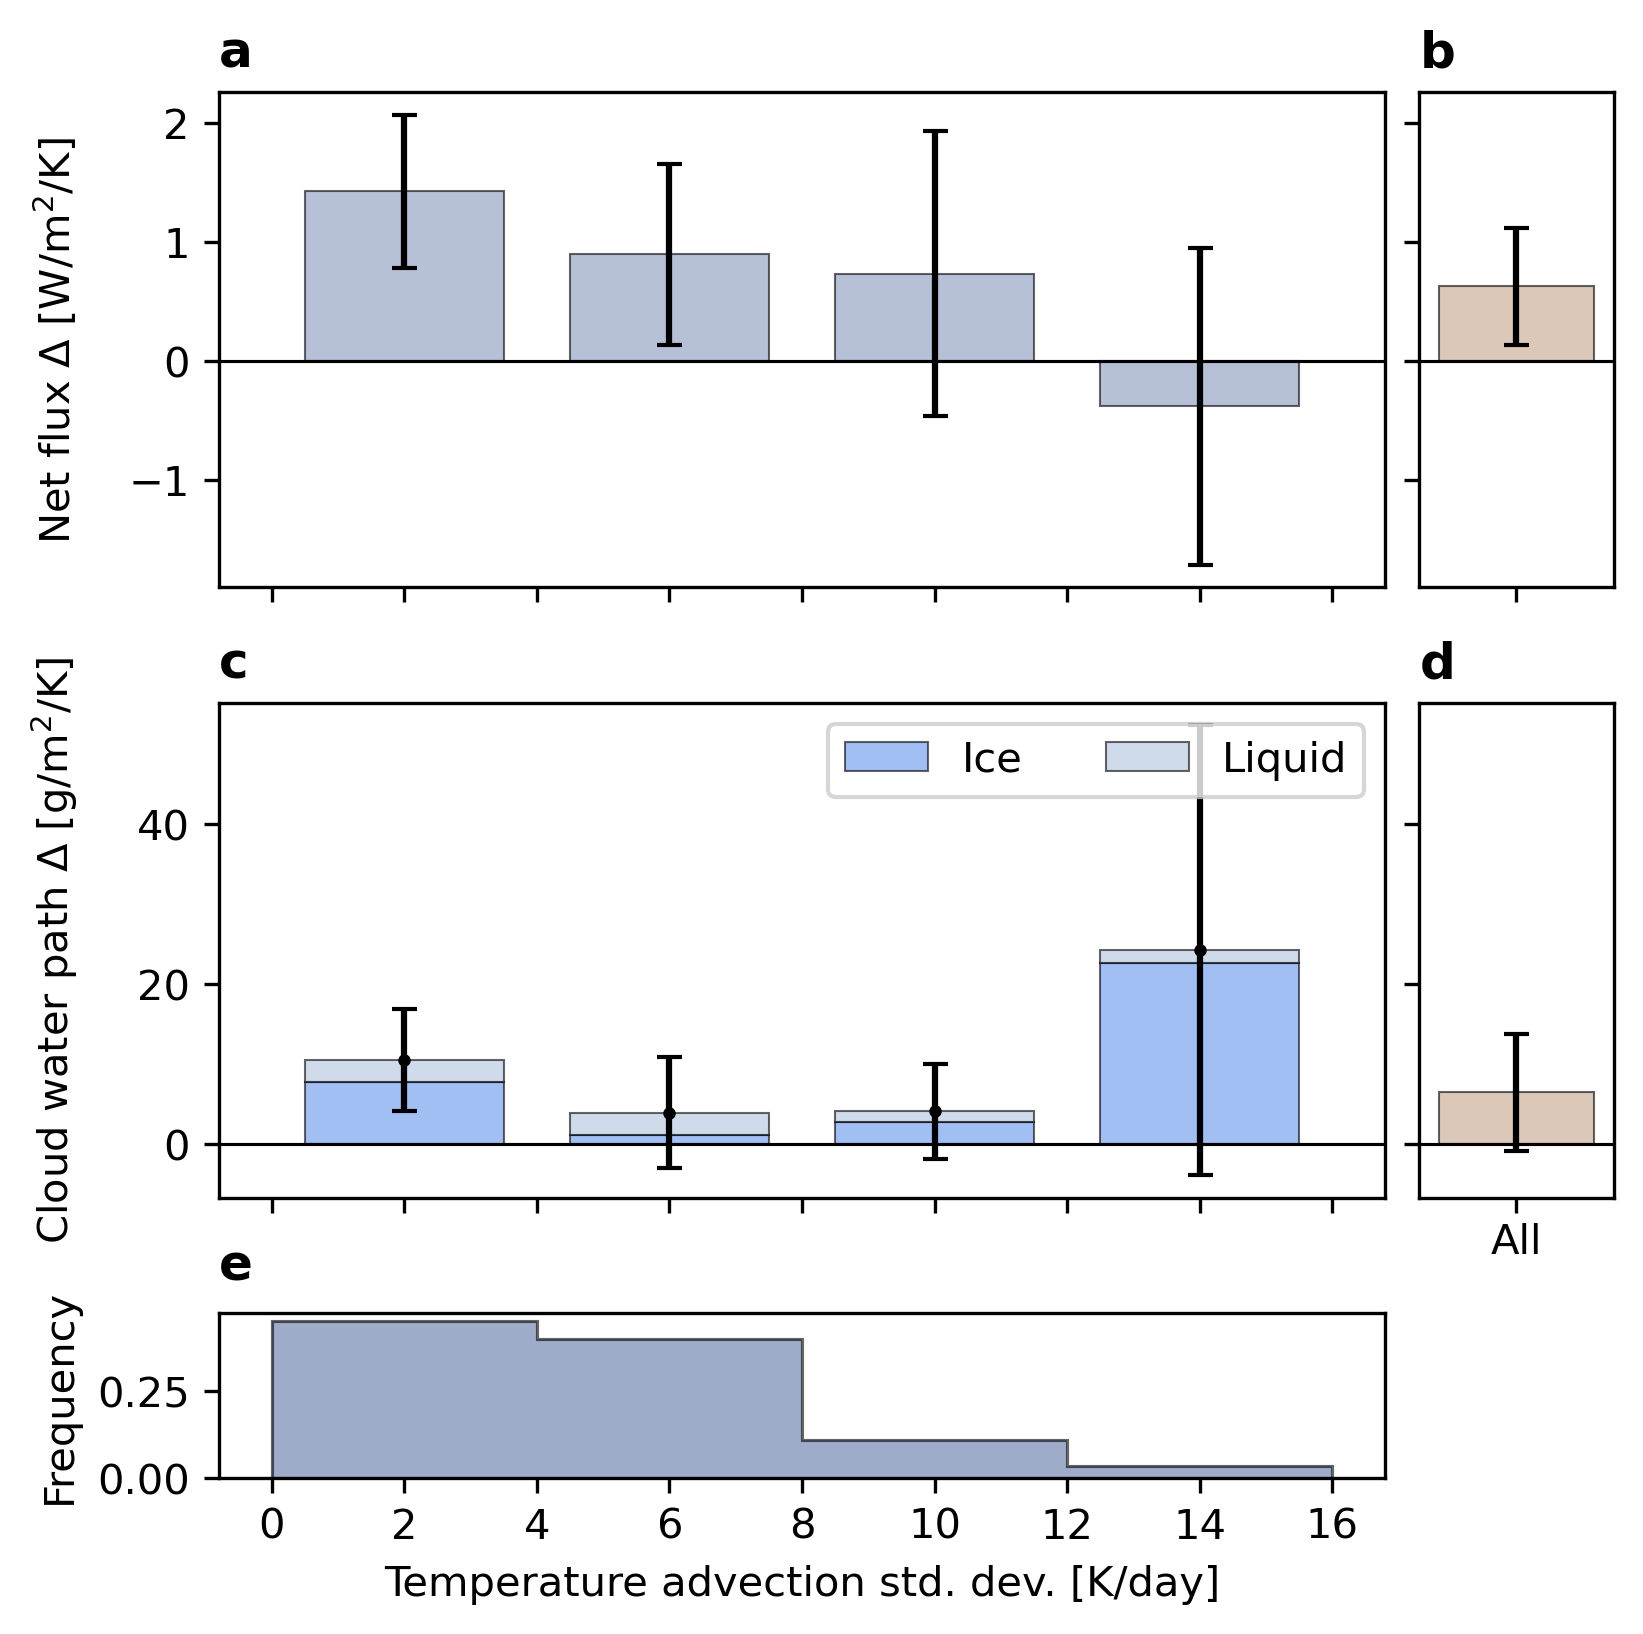

2025-06-21 13:09:43,763 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 2 memory: 1131 MB fds: 461>>
Traceback (most recent call last):
  File "/Users/leah/miniforge3/envs/sci/lib/python3.11/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/leah/miniforge3/envs/sci/lib/python3.11/site-packages/distributed/system_monitor.py", line 160, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leah/miniforge3/envs/sci/lib/python3.11/site-packages/psutil/__init__.py", line 2119, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory


In [93]:
#bins = np.array([-225, -135, -45, 45, 135])
#mids = 0.5*(bins[1:]+bins[:-1])
#errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
bar_kws      = {'alpha':0.6,'edgecolor':'k','linewidth':0.5}
fig, axes = plt.subplots(3,2,sharex='col',figsize=(6,6),width_ratios=[6,1],height_ratios=[3,3,1],sharey='row',dpi=300)
#clear, ice, mixed, liquid
#colors=iter(['royalblue','cornflowerblue','lightsteelblue','slategray'])
for i,resp in enumerate([lwn_anom,twp_anom]):
    #stratified estimate
    ax = axes[i,0]
    reses = gather_strata(resp, tanom, dT)
    slope_lo, slope_hi, slope_med = parse_results(reses,alpha=0.05)
    if ax==axes[1,0]:
        #  stacked bar
        reses_ice = gather_strata(iwp_anom, tanom, dT)
        reses_liq = gather_strata(lwp_anom, tanom, dT)
        _, _, slope_med_ice = parse_results(reses_ice,alpha=0.05)
        _, _, slope_med_liq = parse_results(reses_liq,alpha=0.05)
        scaling = slope_med/(slope_med_ice+slope_med_liq)
        slope_med_ice = slope_med_ice*scaling
        slope_med_liq = slope_med_liq*scaling
        errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'.','mec':'none','mfc':'k'}
        ax.bar(mids,slope_med_ice,color='cornflowerblue',width=3,label='Ice',**bar_kws)
        ax.bar(mids,slope_med_liq,bottom=slope_med_ice,color='lightsteelblue',width=3,label='Liquid',**bar_kws)
    else:
        errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
        #  bar
        ax.bar(mids,slope_med,color='#8698BD',width=3,**bar_kws)
    #  errorbar
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(mids,slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    #crude estimate
    ax = axes[i,1]
    resp = resp.resample(time='MS').mean()
    pred = tanom.resample(time='MS').mean()
    res = do_regression(resp, pred)
    slope_lo, slope_hi, slope_med = parse_results([res])
    if i>0: ax.text(0.5,-0.05,'All',ha='center',va='top',transform=ax.transAxes)
    #  bar
    ax.bar(['Total'],slope_med,color='#C6A48A',width=0.8,**bar_kws)
    #  errorbar
    errorbar_kws = {'alpha':1,'capsize':3,'elinewidth':1.5,'markeredgewidth':1,'ecolor':'k','fmt':'none'}
    yerr = [np.abs(slope_hi-slope_med), np.abs(slope_med-slope_lo)]
    ax.errorbar(['Total'],slope_med,yerr=yerr,**errorbar_kws)
    ax.axhline(0,c='k',lw=0.75)
    ax.set_xlim(-0.5,0.5)

#histogram
ax = axes[-1,0]
keep_months = [12,1,2,3]
sub_mos = lambda da: da.sel(time=da['time.month'].isin(keep_months))
slp_djfm = sub_mos(slp)
counts, _ = np.histogram(dT,bins=bins)
ax.stairs(counts/np.sum(counts),bins,facecolor='#8698BD',alpha=0.8,fill=True)
ax.stairs(counts/np.sum(counts),bins,color='k',lw=0.75,alpha=0.6)
plt.xlabel('surface pressure [hPa]')
plt.ylabel('days')
axes[2,0].set_xlabel(r'Temperature advection std. dev. [K/day]')
#\\partial_t T_{adv}
axes[2,0].set_ylabel('Frequency')
axes[1,0].set_ylabel('Cloud water path $\Delta$ [g/m$^2$/K]')
axes[1,0].legend(loc='upper right',ncols=2)#,bbox_to_anchor=(0.565,1.0),columnspacing=1.5)
print(axes[1,0].get_ylim())
#axes[1,0].set_ylim(-0.7575774160469368,7.99)
axes[0,0].set_ylabel('Net flux $\Delta$ [W/m$^2$/K]')
axes[2,1].set_visible(False)
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axes.flatten()[:-1]:
    if ax == axes[-1,0]:
        pos = 0.0,1.2
    else:
        pos = 0.0,1.05
    ax.text(*pos,next(letter),weight='bold',size='large',transform=ax.transAxes)
fig.align_ylabels()
fig.subplots_adjust(wspace=0.05,hspace=0.3)
#fig.savefig('67-ecmwf_stratified_regression_net_flux_and_total_water_path.pdf',bbox_inches='tight')

# 7. Annual instantaneous closure

In [73]:
REPROCESS=False
if REPROCESS==True:
    folder = Path('~/Documents/arm_data/').expanduser()
    fps = sorted((folder/'ipynb_processed'/'14_v2interp_2004_2019_DJFM'/'out').glob('*.nc'))
    ds = xr.open_mfdataset(fps)
    ds.sel(height=0.008)[['upward_flux','downward_flux','net_flux']].to_netcdf('18-nsa_rrtm_minutely_v2_interpsonde_surf_all.nc')

In [74]:
%%time
#load RRTM output with the two sonde products
folder = Path('~/Documents/arm_data/').expanduser()
ds_msonde  = xr.open_dataset(folder/'ipynb_processed'/'14-4-nsa_rrtm_minutely_v2_vanilla_surf_all.nc')
ds_isonde  = xr.open_dataset(folder/'ipynb_processed'/'18-nsa_rrtm_minutely_v2_interpsonde_surf_all.nc')
ds_msonde, ds_isonde = xr.align(ds_msonde, ds_isonde,join='outer')
#restrict interpsonde calculations 
#number of mins +/- local sonde launch (nsa*C1.b1)
TWIN=30
launch_fps = sorted((folder/'nsasondewnpn').glob('nsasondewnpnC1.b1*.cdf'))
launch_times = np.array([pd.to_datetime(''.join(fp.name.split('.')[-3:-1]),format='%Y%m%d%H%M%S').to_numpy() for fp in launch_fps])
launch_times_shifts = np.concatenate([launch_times+pd.Timedelta(minutes=T) for T in range(-TWIN,TWIN)])
all_times   = pd.date_range(launch_times[0],launch_times[-1],freq='min')
launch_mask = xr.DataArray(data=np.ones_like(all_times,dtype=bool),dims='time',coords={'time':all_times})
#launch_mask = launch_win.time.isin(launch_times_shifts)
ds_isonde, launch_mask = xr.align(ds_isonde,launch_mask)
ds_isonde = ds_isonde.where(launch_mask)
#fill in with interpsonde if mergesonde is missing
ds = xr.where(np.isnan(ds_msonde), ds_isonde, ds_msonde)
#ds = ds_isonde

CPU times: user 5 s, sys: 991 ms, total: 5.99 s
Wall time: 5.45 s


In [75]:
%%time
#calculate residuals
qcrad_djfm = xr.open_dataset(folder/'ipynb_processed'/'47-qcrad_lwflux_minutely_DJFM.nc')
sim_t, rad_t = xr.align(ds,qcrad_djfm)
#exclude non-launch times when using interpsonde
sim_t = xr.where(ds_msonde.notnull(),sim_t,sim_t.where(launch_mask))
#manually mask times when the radiosonde has an impluasible jump to very cold temperatures
#see `rrtm_work/18-2` on alpine for documentation of the issue
screen_days = ['2008-03-14','2005-03-08','2005-03-09']
screen_days = [pd.to_datetime(s).to_numpy() for s in screen_days]
sim_t = sim_t.where(~sim_t['time'].dt.floor('D').isin(screen_days))
#smooth for centered comparisons
sim_smoothed = sim_t['downward_flux'].rolling(time=20,center=True).mean() #min_periods=19
residual = sim_smoothed-rad_t['down_long_hemisp']
residual['time'] = residual['time']+pd.Timedelta(days=32)
#residual_daily = residual.resample(time='D').mean()

CPU times: user 1min 31s, sys: 13.1 s, total: 1min 44s
Wall time: 1min 37s


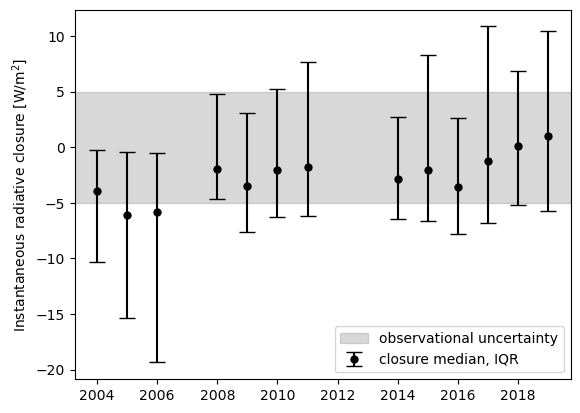

In [76]:
errorbar_iqr_kws = {'alpha': 1,
 'capsize': 6,
 'elinewidth': 1.5,
 'markeredgewidth': 1,
 'ecolor': 'k',
 'fmt': 'o',
 'mec': 'none',
 'mfc': 'k'}
resid = residual
years = np.unique(resid.dropna('time')['time.year'])
meds = np.array([resid.sel(time=resid['time.year']==year).median() for year in years])
lowq = np.array([resid.sel(time=resid['time.year']==year).quantile(0.25) for year in years])
hiq  = np.array([resid.sel(time=resid['time.year']==year).quantile(0.75) for year in years])
yerr_under = meds-lowq
yerr_over  = hiq-meds
plt.errorbar(years,meds,yerr=[yerr_under,yerr_over],label='closure median, IQR',**errorbar_iqr_kws)
plt.ylabel('Instantaneous radiative closure [W/m$^2$]')
xlim = plt.xlim()
plt.fill_between([2000,2020],[-5,-5],[5,5],alpha=0.3,color='grey',label='observational uncertainty')
plt.xlim(*xlim)
plt.legend()
#plt.savefig('60-instantaneous_radiative_closure_bothsonde_restrict.pdf',transparent=False,bbox_inches='tight')

In [95]:
df = pd.DataFrame({'year':years,'median':meds,'IQR':hiq-lowq}).set_index('year').transpose()

In [96]:
df.to_csv('67-2-closure_residuals.csv')

2025-06-12 14:34:20,108 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 23 memory: 349 MB fds: 463>>
Traceback (most recent call last):
  File "/Users/leah/miniforge3/envs/sci/lib/python3.11/site-packages/tornado/ioloop.py", line 919, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/leah/miniforge3/envs/sci/lib/python3.11/site-packages/distributed/system_monitor.py", line 171, in update
    disk_ioc = psutil.disk_io_counters()
               ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leah/miniforge3/envs/sci/lib/python3.11/site-packages/psutil/__init__.py", line 2069, in disk_io_counters
    rawdict = _psplatform.disk_io_counters(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: unable to get the disk's parent.
2025-06-13 03:06:22,775 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:61245', name: 6, 

In [77]:
from cmcrameri import cm as cmc    # nice colorbars
from cmocean import cm as cmo      # nice colorbars
import matplotlib as mpl

log: roma_r,Spectral_r

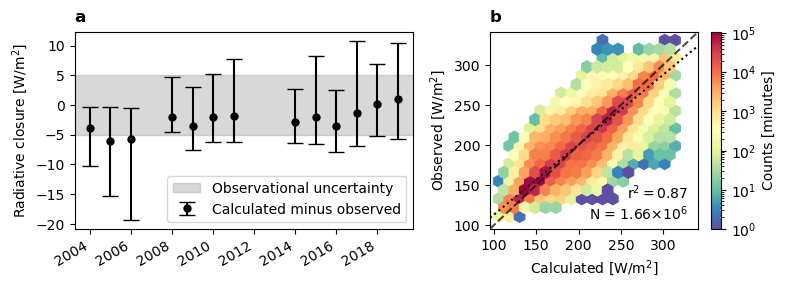

In [78]:
fig, axes = plt.subplots(1,2,figsize=(8,3),width_ratios=[1.3,1])
plt.subplot(121)
errorbar_iqr_kws = {'alpha': 1,
 'capsize': 6,
 'elinewidth': 1.5,
 'markeredgewidth': 1,
 'ecolor': 'k',
 'fmt': 'o',
 'mec': 'none',
 'mfc': 'k'}
resid = residual
years = np.unique(resid.dropna('time')['time.year'])
meds = np.array([resid.sel(time=resid['time.year']==year).median() for year in years])
lowq = np.array([resid.sel(time=resid['time.year']==year).quantile(0.25) for year in years])
hiq  = np.array([resid.sel(time=resid['time.year']==year).quantile(0.75) for year in years])
yerr_under = meds-lowq
yerr_over  = hiq-meds
plt.errorbar(years,meds,yerr=[yerr_under,yerr_over],label='Calculated minus observed',**errorbar_iqr_kws)
plt.ylabel('Radiative closure [W/m$^2$]')
xlim = plt.xlim()
plt.fill_between([2000,2020],[-5,-5],[5,5],alpha=0.3,color='grey',label='Observational uncertainty')
plt.xlim(*xlim)
plt.legend()
plt.gca().xaxis.set_major_locator(mpl.ticker.IndexLocator(base=2,offset=0))
#plt.gca().xaxis.set_minor_locator(mpl.ticker.IndexLocator(base=1,offset=0))
plt.xticks(rotation=30,ha='right')
plt.subplot(122)
#histogram
im = plt.hexbin(sim_smoothed,rad_t['down_long_hemisp'],cmap='Spectral_r',
                norm=mpl.colors.LogNorm(vmin=1, vmax=None),
                gridsize=(17,10),mincnt=1)
plt.colorbar(im,label='Counts [minutes]')
xx,yy = plt.xlim(),plt.ylim()
xlim = min(xx[0],yy[0]), max(xx[1],yy[1])
#origin line
xx = np.linspace(*xlim)
plt.plot(xx,xx,ls='--',c='k',alpha=0.7,label='1:1')
#regression
x, y = sim_smoothed, rad_t['down_long_hemisp']
msk = x.notnull() & y.notnull()
x, y = x.data[msk], y.data[msk]
res = stats.linregress(x,y)
plt.plot(xx,res.intercept+res.slope*xx,c='k',ls=':',label=f'y={res.slope:.2f}x+{res.intercept:.1f}')
#plt.legend(loc='lower right')
plt.xlim(xlim)
plt.ylim(xlim)
plt.xlabel('Calculated [W/m$^2$]')
plt.ylabel('Observed [W/m$^2$]')
plt.text(0.95,0.03,f'r$^2=${res.rvalue**2:.2f}\nN = {msk.sum().data/1e6:.2f}×10$^6$',
         va='bottom',ha='right',
         transform=plt.gca().transAxes)
#add labels
letter = iter('abcdefghijklmnopqrstuvwxyz')
for ax in axes:
    ax.text(0.0,1.05,next(letter),weight='bold',size='large',transform=ax.transAxes)
plt.tight_layout()
#plt.savefig('60-instantaneous_radiative_closure_time_and_regress.pdf',bbox_inches='tight')